In [1]:
#Jump to: Maximizing/Matching CONTROL
 #or: Maximizing/Matching SOCIAL  

In [2]:
import csv
import pandas as pd
import numpy as np
import glob
import matplotlib
import scipy as sp
from matplotlib import pyplot as plt
from itertools import cycle, islice
from scipy import stats

import seaborn as sns

In [3]:
def organize_trial_by_trial(txt_filename):
    reader = csv.reader( open(txt_filename))
    game_data = [row for row in reader]
    df = pd.DataFrame(np.array(game_data))
    df = df.T
    df = df.rename(columns = {0:"game number", 1:"trial", 2:"player", 3:"arm", 4:"probability", 5:"reward", 6:"time", 7:"P1 score", 8:"P2 score"})
    #drops first 20 trials of game 1
    #remove if you want to analyze the whole session
    #df = df[40:]
    #df = df.drop(columns = 'time') #can comment this out if want to look at time
    df = df.drop(['reward', 'time'], axis=1)
    df = df.apply(pd.to_numeric)
    df.head()
    
    return df

In [4]:
#0 means "next" button
#need to exclude zero?

def organize_trial_by_trial_floatclick(txt_filename):
    reader = csv.reader( open(txt_filename))
    game_data = [row for row in reader]
    df = pd.DataFrame(np.array(game_data))
    df = df.T
    df = df.rename(columns = {0:"type", 1:"game number", 2:"trial", 3:"player", 4:"arm", 5:"probability", 6:"P1 score", 7:"P2 score", 8:""})
    #have 402 so need to restrict
    df = df[1:]
    #df = df.drop(columns = 'time') #can comment this out if want to look at time
    df = df.drop(['type'], axis=1)
    df = df.apply(pd.to_numeric)
    df.head()
    
    return df

In [5]:
def organize_trial_by_trial_300(txt_filename):
    reader = csv.reader( open(txt_filename))
    game_data = [row for row in reader]
    df = pd.DataFrame(np.array(game_data))
    df = df.T
    df = df.rename(columns = {0:"type", 1:"game number", 2:"trial", 3:"player", 4:"arm", 5:"probability", 6:"reward", 7:"time", 8:"P1 score", 9:"P2 score"})
    #df = df[40:]
    #df = df.drop(columns = 'time') #can comment this out if want to look at time
    df = df.drop(['type', 'time', 'reward'], axis=1)
    df = df.apply(pd.to_numeric)
    df.head()
    
    return df

In [6]:
def get_score(df, player_number, game_number):
    if game_number == 1:
        row = 199
    elif game_number == 2:
        row = 399
    if player_number == 1:
        column = 'P1 score'
    elif player_number == 2:
        column = 'P2 score'
    score = df.loc[row, column]
    return score

In [7]:
#create a dataframes for scores
scores = pd.DataFrame(columns=['s_g1','s_g2','c_g1','c_g2', 'j_g1', 'j_g2', 'm_g1', 'm_g2'])

In [8]:
#version is 's' for single player and 'j' for joint
def call_get_score(df, version):
    p1_g1 = get_score(df, 1, 1)
    p1_g2 = get_score(df, 1, 2)
    p1_score_diff = p1_g2 - p1_g1
    if version == 'j':
        p1_g1 = get_score(df, 1, 1)
        p1_g2 = get_score(df, 1, 2)
        p1_score_diff = p1_g2 - p1_g1
        p2_g1 = get_score(df, 2, 1)
        p2_g2 = get_score(df, 2, 2)
        p2_score_diff = p2_g2 - p2_g1
        return p1_g1, p1_g2, p2_g1, p2_g2, p1_score_diff, p2_score_diff
    if version == 'm':
        p1_g1 = get_score(df, 1, 1)
        p1_g2 = get_score(df, 1, 2)
        p1_score_diff = p1_g2 - p1_g1
        p2_g1 = get_score(df, 2, 1)
        p2_g2 = get_score(df, 2, 2)
        p2_score_diff = p2_g2 - p2_g1
        return p1_g1, p1_g2, p2_g1, p2_g2, p1_score_diff, p2_score_diff
    return p1_g1, p1_g2, p1_score_diff

In [9]:
#separate data frames for p1 and p2 
def separate_df(df, version):
    #df.set_index(df['trial'])
    df_p1 = df[df['player'] == 1]
    df_p1_g1 = df_p1[df['game number'] == 1]
    df_p1_g2 = df_p1[df['game number'] == 2]
    
    #remove trials for g1
    df_p1_g1 = df_p1_g1[40:60]
    #remove trials for g2
    df_p1_g2 = df_p1_g2[40:60]
    
    if version == 's':
        return df_p1_g1, df_p1_g2
    if version == 'c':
        return df_p1_g1, df_p1_g2
    df_p2 = df[df['player'] ==2 ]
    df_p2_g1 = df_p2[df['game number'] == 1]
    df_p2_g2 = df_p2[df['game number'] == 2]
    
    #remove trials for g1
    df_p2_g1 = df_p2_g1[40:60]
    #remove trials for g2
    df_p2_g2= df_p2_g2[40:60]
    
    return df_p1_g1, df_p1_g2, df_p2_g1, df_p2_g2

In [10]:
#notes from Binghong:

#see reshape to restrict csv file size
#https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.reshape.html 
#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html
#https://www.w3schools.com/python/numpy_array_shape.asp 
#https://stackoverflow.com/

#use drop to filter data frames or cut
#Df=df[20:]

#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html 
#drop columns, python, df

# Single Player Analysis

In [11]:
#in the s files, p2 is the confederate
df = organize_trial_by_trial('data/s01_gamedata.csv')
s01 = df
s01_p1_g1_score,s01_p1_g2_score,s01_score_diff = call_get_score(s01, 's')
s01.head()

,game number,trial,player,arm,probability,P1 score,P2 score
0,1,1,1,2,30,1,0
1,1,1,2,1,90,1,1
2,1,2,1,3,60,2,1
3,1,2,2,1,90,2,2
4,1,3,1,2,30,2,2


In [12]:
#in the s files, p2 is the confederate
#df = organize_trial_by_trial('data/s02_gamedata.csv')
#s02 = df
#s02_p1_g1_score = get_score(s02, 1, 1)
#s02.head()

In [13]:
#in the s files, p2 is the confederate
df = organize_trial_by_trial('data/s03_gamedata.csv')
s03 = df
s03_p1_g1_score,s03_p1_g2_score,s03_score_diff = call_get_score(s03, 's')
s03.head()

,game number,trial,player,arm,probability,P1 score,P2 score
0,1,1,1,3,30,0,0
1,1,1,2,1,90,0,1
2,1,2,1,2,60,1,1
3,1,2,2,1,90,1,2
4,1,3,1,1,90,2,2


In [14]:
#in the s files, p2 is the confederate
df = organize_trial_by_trial('data/s05_gamedata.csv')
s05 = df
s05_p1_g1_score,s05_p1_g2_score,s05_score_diff = call_get_score(s05, 's')
s05.head()

,game number,trial,player,arm,probability,P1 score,P2 score
0,1,1,1,2,30,1,0
1,1,1,2,1,90,1,1
2,1,2,1,3,90,2,1
3,1,2,2,1,90,2,2
4,1,3,1,3,90,3,2


In [15]:
#in the s files, p2 is the confederate
df = organize_trial_by_trial('data/s06_gamedata.csv')
s06 = df
s06_p1_g1_score,s06_p1_g2_score,s06_score_diff = call_get_score(s06, 's')
s06.head()

,game number,trial,player,arm,probability,P1 score,P2 score
0,1,1,1,3,90,1,0
1,1,1,2,1,90,1,1
2,1,2,1,2,60,1,1
3,1,2,2,1,90,1,2
4,1,3,1,3,90,2,2


In [16]:
#in the s files, p2 is the confederate
df = organize_trial_by_trial('data/s07_gamedata.csv')
s07 = df
s07_p1_g1_score,s07_p1_g2_score,s07_score_diff = call_get_score(s07, 's')
s07.head()

,game number,trial,player,arm,probability,P1 score,P2 score
0,1,1,1,3,60,0,0
1,1,1,2,1,90,0,1
2,1,2,1,3,60,1,1
3,1,2,2,1,90,1,2
4,1,3,1,1,90,1,2


In [17]:
pd.set_option('display.max_columns', None)  

In [18]:
#in the s files, p2 is the confederate
df = organize_trial_by_trial('data/s08_gamedata.csv')
s08 = df
s08_p1_g1_score,s08_p1_g2_score,s08_score_diff = call_get_score(s08, 's')
s08.head()

,game number,trial,player,arm,probability,P1 score,P2 score
0,1,1,1,1,30,0,0
1,1,1,2,1,90,0,1
2,1,2,1,2,90,1,1
3,1,2,2,1,90,1,2
4,1,3,1,2,90,2,2


In [19]:
#in the s files, p2 is the confederate
df = organize_trial_by_trial('data/s09_gamedata.csv')
s09 = df
s09_p1_g1_score,s09_p1_g2_score,s09_score_diff = call_get_score(s09, 's')
s09.head()

,game number,trial,player,arm,probability,P1 score,P2 score
0,1,1,1,3,60,1,0
1,1,1,2,1,90,1,1
2,1,2,1,3,60,2,1
3,1,2,2,1,90,2,1
4,1,3,1,1,90,3,1


In [20]:
#in the s files, p2 is the confederate
df = organize_trial_by_trial_floatclick('data/s11_gamedata.csv')
s11 = df
s11_p1_g1_score,s11_p1_g2_score,s11_score_diff = call_get_score(s11, 's')
s11.head()

,game number,trial,player,arm,probability,P1 score,P2 score
1,1,1,2,0,90,1,0
2,1,2,1,1,30,1,1
3,1,2,2,0,90,1,1
4,1,3,1,2,60,1,2
5,1,3,2,0,90,2,2


In [21]:
#in the s files, p2 is the confederate
df = organize_trial_by_trial_300('data/s12_gamedata.csv')
s12 = df
s12_p1_g1_score,s12_p1_g2_score,s12_score_diff = call_get_score(s12, 's')
s12.head()

,game number,trial,player,arm,probability,P1 score,P2 score
0,1,1,1,1,90,1,0
1,1,1,2,1,90,1,1
2,1,2,1,3,30,1,1
3,1,2,2,2,60,1,2
4,1,3,1,1,90,2,2


In [22]:
#in the s files, p2 is the confederate
df = organize_trial_by_trial_floatclick('data/s15_gamedata.csv')
s15 = df
s15_p1_g1_score,s15_p1_g2_score,s15_score_diff = call_get_score(s15, 's')
s15.head()

,game number,trial,player,arm,probability,P1 score,P2 score
1,1,1,2,0,90,1,0
2,1,2,1,1,30,1,1
3,1,2,2,0,90,1,1
4,1,3,1,2,90,1,2
5,1,3,2,0,90,2,2


In [23]:
#in the s files, p2 is the confederate
df = organize_trial_by_trial_floatclick('data/s16_gamedata.csv')
s16 = df
s16_p1_g1_score,s16_p1_g2_score,s16_score_diff = call_get_score(s16, 's')
s16.head()

,game number,trial,player,arm,probability,P1 score,P2 score
1,1,1,2,0,90,1,0
2,1,2,1,3,60,1,1
3,1,2,2,0,90,2,1
4,1,3,1,1,90,2,2
5,1,3,2,0,90,3,2


In [24]:
#in the s files, p2 is the confederate
df = organize_trial_by_trial_300('data/s19_gamedata.csv')
s19 = df
s19_p1_g1_score,s19_p1_g2_score,s19_score_diff = call_get_score(s19, 's')
s19.head()

,game number,trial,player,arm,probability,P1 score,P2 score
0,1,1,1,2,60,1,0
1,1,1,2,1,90,1,0
2,1,2,1,1,90,2,0
3,1,2,2,1,90,2,1
4,1,3,1,3,30,2,1


In [25]:
#in the s files, p2 is the confederate
df = organize_trial_by_trial_floatclick('data/s17_gamedata.csv')
s17 = df
s17_p1_g1_score,s17_p1_g2_score,s17_score_diff = call_get_score(s17, 's')
s17.head()

,game number,trial,player,arm,probability,P1 score,P2 score
1,1,1,2,0,90,1,0
2,1,2,1,3,60,1,1
3,1,2,2,0,90,1,1
4,1,3,1,2,90,1,2
5,1,3,2,0,90,2,2


In [26]:
#in the s files, p2 is the confederate
df = organize_trial_by_trial_floatclick('data/s20_gamedata.csv')
s20 = df
s20_p1_g1_score,s20_p1_g2_score,s20_score_diff = call_get_score(s20, 's')
s20.head()

,game number,trial,player,arm,probability,P1 score,P2 score
1,1,1,2,0,90,1,0
2,1,2,1,2,60,1,1
3,1,2,2,0,90,2,1
4,1,3,1,3,30,2,2
5,1,3,2,0,90,3,2


# Single score diff between G1 and G2

In [27]:
score_diff = pd.DataFrame({'participant':['s01','s03', 's05', 
                               's06', 's07', 's08', 's09', 's11', 's12', 's15', 's16', 's17', 's19', 's20'], 'score_diff':
     [s01_score_diff, s03_score_diff, s05_score_diff, s06_score_diff,
      s07_score_diff, s08_score_diff, s09_score_diff, s11_score_diff, s12_score_diff, s15_score_diff, s16_score_diff, s17_score_diff, s19_score_diff, s20_score_diff]})

In [28]:
score_diff

,participant,score_diff
0,s01,14
1,s03,8
2,s05,11
3,s06,5
4,s07,5
5,s08,-10
6,s09,5
7,s11,1
8,s12,3
9,s15,15


In [29]:
score_diff_mean = score_diff['score_diff'].mean()

In [30]:
score_diff_mean

4.0

# Single scores in G1 and G2

In [31]:
#list out all the scores in game 1 by participant
s_scores_1 = pd.DataFrame({'participant':['s01','s03', 's05', 
                               's06', 's07', 's08', 's09', 's11', 's12', 's15', 's16', 's17', 's19', 's20'], 'score_1':
     [s01_p1_g1_score, s03_p1_g1_score, s05_p1_g1_score,
      s06_p1_g1_score, s07_p1_g1_score, s08_p1_g1_score, s09_p1_g1_score, s11_p1_g1_score, s12_p1_g1_score, s15_p1_g1_score, s16_p1_g1_score, s17_p1_g1_score, s19_p1_g1_score, s20_p1_g1_score]})
#to prevent an extra column that numbers each row:
s_scores_1.set_index('participant', inplace=True, drop=True)

#print
s_scores_1

,score_1
participant,
s01,60
s03,63
s05,77
s06,82
s07,63
s08,90
s09,65
s11,60
s12,83


In [32]:
#list out all the scores in game 2 by participant
s_scores_2 = pd.DataFrame({'participant':['s01', 's03', 's05', 
                               's06', 's07', 's08', 's09', 's11', 's12', 's15', 's16', 's17', 's19', 's20'], 'score_2':
    [s01_p1_g2_score, s03_p1_g2_score, s05_p1_g2_score, 
s06_p1_g2_score, s07_p1_g2_score, s08_p1_g2_score, s09_p1_g2_score, s11_p1_g2_score, s12_p1_g2_score, s15_p1_g2_score, s16_p1_g2_score, s17_p1_g2_score, s19_p1_g2_score, s20_p1_g2_score]})

#to prevent an extra column that numbers each row:
s_scores_2.set_index('participant', inplace=True, drop=True)
#s_scores_1 = pd.DataFrame(data = d1)
#s_scores_2 = pd.DataFrame(data = d2)
s_scores_2

,score_2
participant,
s01,74
s03,71
s05,88
s06,87
s07,68
s08,80
s09,70
s11,61
s12,86


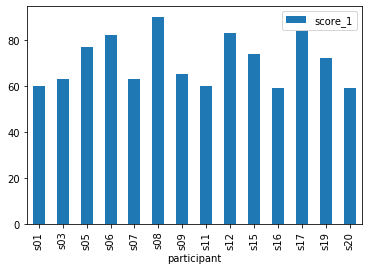

In [33]:
s_scores_1_bar = s_scores_1.plot.bar()

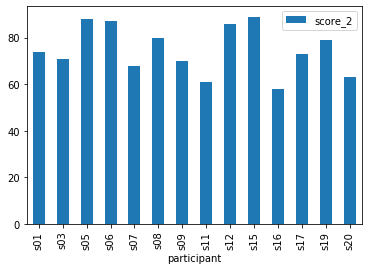

In [34]:
s_scores_2_bar = s_scores_2.plot.bar()

In [35]:
#merge both games by participant:
s_scores = pd.merge(s_scores_1, s_scores_2,on='participant')

In [36]:
s_scores = pd.merge(s_scores_1, s_scores_2,on='participant')
#label columns
s_scores.columns=['Game 1','Game 2']

In [37]:
s_scores

,Game 1,Game 2
participant,,
s01,60,74
s03,63,71
s05,77,88
s06,82,87
s07,63,68
s08,90,80
s09,65,70
s11,60,61
s12,83,86


([<matplotlib.axis.YTick at 0x1a21e22250>,
 <a list of 6 Text yticklabel objects>)

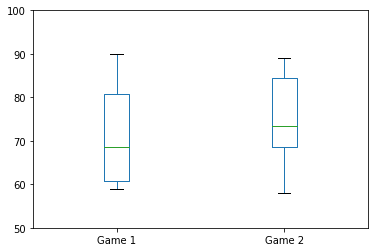

In [38]:
s_scores_box = s_scores.boxplot(labels=['Game 1','Game 2'])
plt.grid(b=None)
plt.yticks(np.arange(50, 105, step=10))

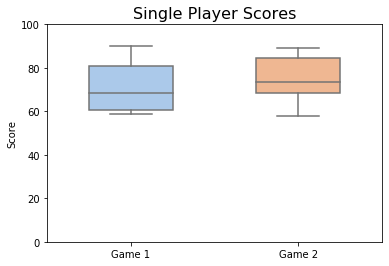

In [39]:
s_scores_box = sns.boxplot( 
                 data=s_scores, 
                 width=0.5,
                 palette="pastel")
s_scores_box.axes.set_title("Single Player Scores",
                    fontsize=16)

plot_file_name="s_score_box.jpg"
 
plt.ylim(0, 100)
s_scores_box.axes.set(ylabel='Score')

# save as jpeg
s_scores_box.figure.savefig(plot_file_name,
                    format='jpeg',
                    dpi=100)

In [40]:
s_scores_p = sp.stats.ttest_rel(s_scores['Game 1'],s_scores['Game 2'])

In [41]:
s_scores_p

Ttest_relResult(statistic=-1.96521473776207, pvalue=0.07112499604880738)

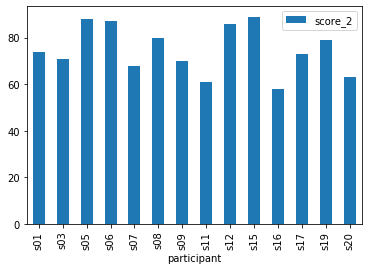

In [42]:
s_scores_2_bar = s_scores_2.plot.bar()

In [43]:
#combine g1 and g2 to one dataframe
s_combo = s_scores_1.append(s_scores_2)

/Users/simonefroley/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [44]:
'''s_combo = pd.DataFrame({'participant':['s01', 's01', 's03', 's03','s05', 's05'
                              's06', 's06','s07','s07','s08','s08','s09','s09', 's11', 's11', 's12', 's12', 's15', 's15', 's16', 's16', 's17', 's17', 's19', 's19', 's20', 's20'], 'score':
     [s01_p1_g1_score, s01_p1_g2_score, s02_p1_g1_score, s03_p1_g1_score, s03_p1_g2_score, s05_p1_g1_score,
      s05_p1_g2_score,s06_p1_g1_score,s06_p1_g2_score, s07_p1_g1_score,s07_p1_g2_score, s08_p1_g1_score,s08_p1_g2_score,
      s09_p1_g1_score, s09_p1_g2_score, s11_p1_g1_score, s11_p1_g2_score, s12_p1_g1_score, s12_p1_g2_score, s15_p1_g1_score, s15_p1_g2_score, s16_p1_g1_score, s16_p1_g2_score, s17_p1_g1_score, s17_p1_g2_score, s19_p1_g1_score, s19_p1_g2_score, s20_p1_g1_score, s20_p1_g2_score]})
s_combo.set_index('participant', inplace=True, drop=True)'''

"s_combo = pd.DataFrame({'participant':['s01', 's01', 's03', 's03','s05', 's05'\n                              's06', 's06','s07','s07','s08','s08','s09','s09', 's11', 's11', 's12', 's12', 's15', 's15', 's16', 's16', 's17', 's17', 's19', 's19', 's20', 's20'], 'score':\n     [s01_p1_g1_score, s01_p1_g2_score, s02_p1_g1_score, s03_p1_g1_score, s03_p1_g2_score, s05_p1_g1_score,\n      s05_p1_g2_score,s06_p1_g1_score,s06_p1_g2_score, s07_p1_g1_score,s07_p1_g2_score, s08_p1_g1_score,s08_p1_g2_score,\n      s09_p1_g1_score, s09_p1_g2_score, s11_p1_g1_score, s11_p1_g2_score, s12_p1_g1_score, s12_p1_g2_score, s15_p1_g1_score, s15_p1_g2_score, s16_p1_g1_score, s16_p1_g2_score, s17_p1_g1_score, s17_p1_g2_score, s19_p1_g1_score, s19_p1_g2_score, s20_p1_g1_score, s20_p1_g2_score]})\ns_combo.set_index('participant', inplace=True, drop=True)"

In [45]:

#new_index = ('s01_g1','s01_g2','s02_g1','s03_g1','s03_g2','s05_g1','s05_g2', 
                               #'s06_g1','s06_g2','s07_g1','s07_g2','s08_g1','s08_g2','s09_g1','s09_g2')
#s_combo.index = new_index

In [46]:
s_combo = s_combo.sort_values(by=['participant'])

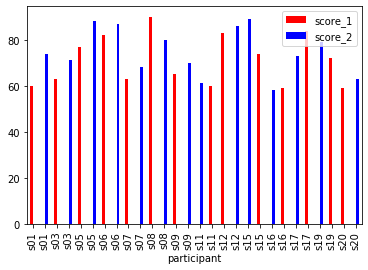

In [47]:
#unnecessary graph
#need to make g1 and g2 bars diff colors
colors = list(islice(cycle(['red','blue','red', 'red','blue','red','blue','red','blue','red','blue','red','blue','red','blue']),None,len(s_combo)))
#my_colors = list(islice(cycle(['b', 'r', 'g', 'y', 'k']), None, len(df)))
s_combo_bar = s_combo.plot(kind='bar',color=colors)

In [48]:
s_scores_1_mean = s_scores_1.mean()

In [49]:
s_scores_1_mean

score_1    70.785714
dtype: float64

In [50]:
s_scores_1_std = s_scores_1.std()

In [51]:
s_scores_1_std

score_1    10.864045
dtype: float64

In [52]:
s_scores_2_mean = s_scores_2.mean()

In [53]:
s_scores_2_mean

score_2    74.785714
dtype: float64

In [54]:
s_scores_2_std = s_scores_2.std()

In [55]:
s_scores_2_std

score_2    10.356555
dtype: float64

In [56]:
s_scores_med = s_scores.median()
s_scores_med

Game 1    68.5
Game 2    73.5
dtype: float64

# Single choice probabilities

In [57]:
s01_p1_g1, s01_p1_g2 = separate_df(s01, 's')

/Users/simonefroley/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/Users/simonefroley/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [58]:
s01_p1_g2

,game number,trial,player,arm,probability,P1 score,P2 score
280,2,41,1,2,90,28,36
282,2,42,1,3,30,28,37
284,2,43,1,3,30,29,38
286,2,44,1,3,30,30,39
288,2,45,1,2,90,31,40
290,2,46,1,2,90,32,41
292,2,47,1,2,90,33,42
294,2,48,1,1,60,34,43
296,2,49,1,2,90,35,44
298,2,50,1,3,30,36,45


In [59]:
s01_p1_g1, s01_p1_g2 = separate_df(s01, 's')
s03_p1_g1, s03_p1_g2 = separate_df(s03, 's')
s05_p1_g1, s05_p1_g2 = separate_df(s05, 's')
s06_p1_g1, s06_p1_g2 = separate_df(s06, 's')
s07_p1_g1, s07_p1_g2 = separate_df(s07, 's')
s08_p1_g1, s08_p1_g2 = separate_df(s08, 's')
s09_p1_g1, s09_p1_g2 = separate_df(s09, 's')
s11_p1_g1, s11_p1_g2 = separate_df(s11, 's')
s12_p1_g1, s12_p1_g2 = separate_df(s12, 's')
s15_p1_g1, s15_p1_g2 = separate_df(s15, 's')
s16_p1_g1, s16_p1_g2 = separate_df(s16, 's')
s17_p1_g1, s17_p1_g2 = separate_df(s17, 's')
s19_p1_g1, s19_p1_g2 = separate_df(s19, 's')
s20_p1_g1, s20_p1_g2 = separate_df(s20, 's')

/Users/simonefroley/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/Users/simonefroley/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [60]:
s01_p1_g1_count = s01_p1_g1['probability'].value_counts(sort=False)
s01_p1_g2_count = s01_p1_g2['probability'].value_counts(sort=False)
s03_p1_g1_count = s03_p1_g1['probability'].value_counts(sort=False)
s03_p1_g2_count = s03_p1_g2['probability'].value_counts(sort=False)
s05_p1_g1_count = s05_p1_g1['probability'].value_counts(sort=False)
s05_p1_g2_count = s05_p1_g2['probability'].value_counts(sort=False)
s06_p1_g1_count = s06_p1_g1['probability'].value_counts(sort=False)
s06_p1_g2_count = s06_p1_g2['probability'].value_counts(sort=False)
s07_p1_g1_count = s07_p1_g1['probability'].value_counts(sort=False)
s07_p1_g2_count = s07_p1_g2['probability'].value_counts(sort=False)
s08_p1_g1_count = s08_p1_g1['probability'].value_counts(sort=False)
s08_p1_g2_count = s08_p1_g2['probability'].value_counts(sort=False)
s09_p1_g1_count = s09_p1_g1['probability'].value_counts(sort=False)
s09_p1_g2_count = s09_p1_g2['probability'].value_counts(sort=False)
s11_p1_g1_count = s11_p1_g1['probability'].value_counts(sort=False)
s11_p1_g2_count = s11_p1_g2['probability'].value_counts(sort=False)
s12_p1_g1_count = s12_p1_g1['probability'].value_counts(sort=False)
s12_p1_g2_count = s12_p1_g2['probability'].value_counts(sort=False)
s15_p1_g1_count = s15_p1_g1['probability'].value_counts(sort=False)
s15_p1_g2_count = s15_p1_g2['probability'].value_counts(sort=False)
s16_p1_g1_count = s16_p1_g1['probability'].value_counts(sort=False)
s16_p1_g2_count = s16_p1_g2['probability'].value_counts(sort=False)
s17_p1_g1_count = s17_p1_g1['probability'].value_counts(sort=False)
s17_p1_g2_count = s17_p1_g2['probability'].value_counts(sort=False)
s19_p1_g1_count = s19_p1_g1['probability'].value_counts(sort=False)
s19_p1_g2_count = s19_p1_g2['probability'].value_counts(sort=False)
s20_p1_g1_count = s20_p1_g1['probability'].value_counts(sort=False)
s20_p1_g2_count = s20_p1_g2['probability'].value_counts(sort=False)

In [61]:
#to see each individual count of probabilities, print: 
#s01_p1_g1_count

# Single choices in G1 

In [62]:
s_g1_counts = pd.DataFrame([s01_p1_g1_count, s03_p1_g1_count, s05_p1_g1_count, s06_p1_g1_count, s07_p1_g1_count, 
                s08_p1_g1_count, s09_p1_g1_count, s11_p1_g1_count, s12_p1_g1_count, s15_p1_g1_count, s16_p1_g1_count,
                    s17_p1_g1_count, s19_p1_g1_count, s20_p1_g1_count],
                          index=['s01_p1_g1_count', 's03_p1_g1_count', 
                            's05_p1_g1_count', 's06_p1_g1_count', 's07_p1_g1_count', 's08_p1_g1_count', 
                                 's09_p1_g1_count', 's11_p1_g1_count', 's12_p1_g1_count', 's15_p1_g1_count', 
                                 's16_p1_g1_count','s17_p1_g1_count', 's19_p1_g1_count', 's20_p1_g1_count'])

In [63]:
#How to prevent NaN: df = df.fillna(0)
s_g1_counts = s_g1_counts.fillna(0)

#print
s_g1_counts

,30,60,90
s01_p1_g1_count,6.0,9.0,5.0
s03_p1_g1_count,4.0,8.0,8.0
s05_p1_g1_count,0.0,16.0,4.0
s06_p1_g1_count,0.0,1.0,19.0
s07_p1_g1_count,5.0,6.0,9.0
s08_p1_g1_count,0.0,2.0,18.0
s09_p1_g1_count,2.0,5.0,13.0
s11_p1_g1_count,7.0,8.0,5.0
s12_p1_g1_count,1.0,4.0,15.0
s15_p1_g1_count,0.0,3.0,17.0


In [64]:
s_g1_counts.sum(axis=1)

s01_p1_g1_count    20.0
s03_p1_g1_count    20.0
s05_p1_g1_count    20.0
s06_p1_g1_count    20.0
s07_p1_g1_count    20.0
s08_p1_g1_count    20.0
s09_p1_g1_count    20.0
s11_p1_g1_count    20.0
s12_p1_g1_count    20.0
s15_p1_g1_count    20.0
s16_p1_g1_count    20.0
s17_p1_g1_count    20.0
s19_p1_g1_count    20.0
s20_p1_g1_count    20.0
dtype: float64

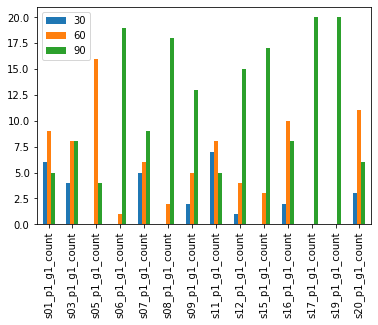

In [65]:
s_g1_counts_bar = s_g1_counts.plot.bar()

# save as jpeg
s_g1_counts_bar.figure.savefig(plot_file_name,
                    format='jpeg',
                    dpi=100)

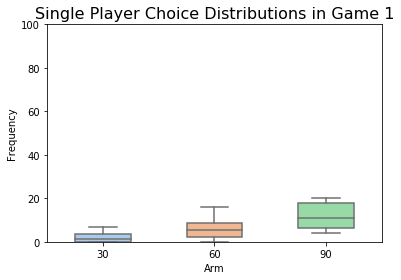

In [66]:
s_g1_counts_box = sns.boxplot( 
                 data=s_g1_counts, 
                 width=0.5,
                 palette="pastel")
s_g1_counts_box.axes.set_title("Single Player Choice Distributions in Game 1",
                    fontsize=16)

plot_file_name="s_g1_counts_box.jpg"
 
plt.ylim(0, 100)
s_g1_counts_box.axes.set(xlabel='Arm',ylabel='Frequency')

# save as jpeg
s_g1_counts_box.figure.savefig(plot_file_name,
                    format='jpeg',
                    dpi=100)

In [67]:
#0 is low (30), 1 is med (60), 2 is high (90)
s_g1_low = np.mean(s_g1_counts.iloc[:,0])
s_g1_med = np.mean(s_g1_counts.iloc[:,1])
s_g1_high = np.mean(s_g1_counts.iloc[:,2])

In [68]:
s_g1_low

2.142857142857143

In [69]:
s_g1_med

5.928571428571429

In [70]:
s_g1_high

11.928571428571429

In [71]:
s_g1_low_std = np.std(s_g1_counts.iloc[:,0])
s_g1_med_std = np.std(s_g1_counts.iloc[:,1])
s_g1_high_std = np.std(s_g1_counts.iloc[:,2])

In [72]:
s_g1_low_std

2.3861847269271523

In [73]:
s_g1_med_std

4.51132362132518

In [74]:
s_g1_high_std

5.8975089864194326

# Single choices in G2

In [75]:
s_g2_counts = pd.DataFrame([s01_p1_g2_count, s03_p1_g2_count, 
                            s05_p1_g2_count, s06_p1_g2_count, s07_p1_g2_count, s08_p1_g2_count, s09_p1_g2_count,
                            s11_p1_g2_count, s12_p1_g2_count, s15_p1_g2_count, s16_p1_g2_count,
                    s17_p1_g2_count, s19_p1_g2_count, s20_p1_g2_count],
index= ['s01_p1_g2_count', 's03_p1_g2_count', 's05_p1_g2_count', 's06_p1_g2_count',
                                 's07_p1_g2_count', 's08_p1_g2_count', 's09_p1_g2_count', 's11_p1_g2_count', 
                                 's12_p1_g2_count', 's15_p1_g2_count', 's16_p1_g2_count','s17_p1_g2_count', 
                                 's19_p1_g2_count', 's20_p1_g2_count'])

In [76]:
#How to prevent NaN: df = df.fillna(0)
s_g2_counts = s_g2_counts.fillna(0)

#print
s_g2_counts

,30,60,90
s01_p1_g2_count,10.0,2.0,8.0
s03_p1_g2_count,4.0,3.0,13.0
s05_p1_g2_count,0.0,0.0,20.0
s06_p1_g2_count,0.0,2.0,18.0
s07_p1_g2_count,3.0,5.0,12.0
s08_p1_g2_count,0.0,3.0,17.0
s09_p1_g2_count,3.0,6.0,11.0
s11_p1_g2_count,4.0,4.0,12.0
s12_p1_g2_count,1.0,0.0,19.0
s15_p1_g2_count,0.0,2.0,18.0


In [77]:
s_g2_counts.sum(axis=1)

s01_p1_g2_count    20.0
s03_p1_g2_count    20.0
s05_p1_g2_count    20.0
s06_p1_g2_count    20.0
s07_p1_g2_count    20.0
s08_p1_g2_count    20.0
s09_p1_g2_count    20.0
s11_p1_g2_count    20.0
s12_p1_g2_count    20.0
s15_p1_g2_count    20.0
s16_p1_g2_count    20.0
s17_p1_g2_count    20.0
s19_p1_g2_count    20.0
s20_p1_g2_count    20.0
dtype: float64

In [78]:
s15_p1_g1

,game number,trial,player,arm,probability,P1 score,P2 score
82,1,42,1,2,90,23,39
84,1,43,1,2,90,23,40
86,1,44,1,2,90,24,41
88,1,45,1,2,90,25,42
90,1,46,1,3,60,26,43
92,1,47,1,2,90,27,43
94,1,48,1,2,90,28,43
96,1,49,1,2,90,29,44
98,1,50,1,3,60,30,45
100,1,51,1,2,90,31,46


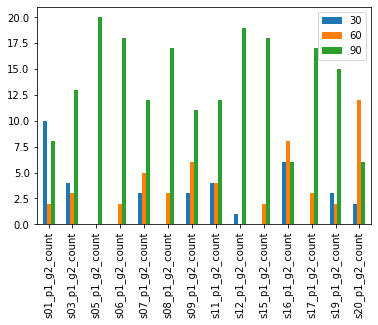

In [79]:
s_g2_counts_bar = s_g2_counts.plot.bar()

# save as jpeg
s_g2_counts_bar.figure.savefig(plot_file_name,
                    format='jpeg',
                    dpi=100)

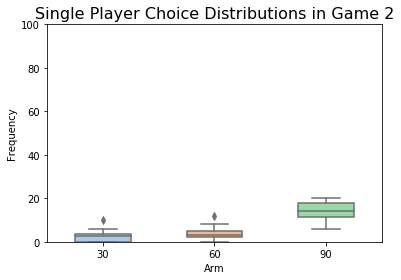

In [80]:
s_g2_counts_box = sns.boxplot( 
                 data=s_g2_counts, 
                 width=0.5,
                 palette="pastel")
s_g2_counts_box.axes.set_title("Single Player Choice Distributions in Game 2",
                    fontsize=16)

plot_file_name="s_g2_counts_box.jpg"
 
plt.ylim(0, 100)
s_g2_counts_box.axes.set(xlabel='Arm',ylabel='Frequency')

# save as jpeg
s_g2_counts_box.figure.savefig(plot_file_name,
                    format='jpeg',
                    dpi=100)

In [81]:
s_g2_low = np.mean(s_g2_counts.iloc[:,0])
s_g2_med = np.mean(s_g2_counts.iloc[:,1])
s_g2_high = np.mean(s_g2_counts.iloc[:,2])

In [82]:
s_g2_low

2.5714285714285716

In [83]:
s_g2_med

3.7142857142857144

In [84]:
s_g2_high

13.714285714285714

In [85]:
s_g2_low_std = np.std(s_g2_counts.iloc[:,0])
s_g2_med_std = np.std(s_g2_counts.iloc[:,1])
s_g2_high_std = np.std(s_g2_counts.iloc[:,2])

In [86]:
s_g2_low_std

2.770102775666474

In [87]:
s_g2_med_std

3.103651568914347

In [88]:
s_g2_high_std

4.573660169594892

# Single arrays

In [89]:
#pip install researchpy

In [90]:
import researchpy as rp

In [91]:
s_90_1 = np.array(s_g1_counts.iloc[:,2])
s_90_2 = np.array(s_g2_counts.iloc[:,2])

In [92]:
s_90_1

array([ 5.,  8.,  4., 19.,  9., 18., 13.,  5., 15., 17.,  8., 20., 20.,
        6.])

In [93]:
s_90_2

array([ 8., 13., 20., 18., 12., 17., 11., 12., 19., 18.,  6., 17., 15.,
        6.])

In [94]:
s_60_1 = np.array(s_g1_counts.iloc[:,1])
s_60_2 = np.array(s_g2_counts.iloc[:,1])

In [95]:
s_60_1

array([ 9.,  8., 16.,  1.,  6.,  2.,  5.,  8.,  4.,  3., 10.,  0.,  0.,
       11.])

In [96]:
s_60_2

array([ 2.,  3.,  0.,  2.,  5.,  3.,  6.,  4.,  0.,  2.,  8.,  3.,  2.,
       12.])

In [97]:
s_30_1 = np.array(s_g1_counts.iloc[:,0])
s_30_2 = np.array(s_g2_counts.iloc[:,0])

In [98]:
s_30_1

array([6., 4., 0., 0., 5., 0., 2., 7., 1., 0., 2., 0., 0., 3.])

In [99]:
s_30_2

array([10.,  4.,  0.,  0.,  3.,  0.,  3.,  4.,  1.,  0.,  6.,  0.,  3.,
        2.])

# Single choice statistics

In [100]:
s_90_p = sp.stats.ttest_rel(s_90_1,s_90_2)
s_60_p = sp.stats.ttest_rel(s_60_1,s_60_2)
s_30_p = sp.stats.ttest_rel(s_30_1,s_30_2)

In [101]:
s_90_p

Ttest_relResult(statistic=-1.2620716842901607, pvalue=0.22909617799064536)

In [102]:
s_60_p

Ttest_relResult(statistic=1.6795020173899164, pvalue=0.11691257166694517)

In [103]:
s_30_p

Ttest_relResult(statistic=-0.7909920664569657, pvalue=0.44314093482351424)

# Confederate Player Analysis

In [104]:
#in the s files, p2 is the confederate
df = organize_trial_by_trial('data/c02_gamedata.csv')
c02 = df
c02_p1_g1_score,c02_p1_g2_score,c02_score_diff = call_get_score(c02, 'c')
c02.head()

,game number,trial,player,arm,probability,P1 score,P2 score
0,1,1,1,2,30,0,0
1,1,1,2,1,90,0,1
2,1,2,1,2,30,0,1
3,1,2,2,1,90,0,2
4,1,3,1,1,90,0,2


In [105]:
#in the s files, p2 is the confederate
df = organize_trial_by_trial('data/c03_gamedata.csv')
c03 = df
c03_p1_g1_score,c03_p1_g2_score,c03_score_diff = call_get_score(c03, 'c')
c03.head()

,game number,trial,player,arm,probability,P1 score,P2 score
0,1,1,1,3,90,1,0
1,1,1,2,3,30,1,1
2,1,2,1,2,60,1,1
3,1,2,2,3,30,1,2
4,1,3,1,1,30,1,2


In [106]:
#in the s files, p2 is the confederate
#df = organize_trial_by_trial('data/c04_gamedata.csv')
#c04 = df
#c04_p1_g1_score,c04_p1_g2_score,c04_score_diff = call_get_score(c04, 'c')
#c04.head()

In [107]:
#in the s files, p2 is the confederate
df = organize_trial_by_trial('data/c05_gamedata.csv')
c05 = df
c05_p1_g1_score,c05_p1_g2_score,c05_score_diff = call_get_score(c05, 'c')
c05.head()

,game number,trial,player,arm,probability,P1 score,P2 score
0,1,1,1,2,60,0,0
1,1,1,2,3,30,0,1
2,1,2,1,1,30,1,1
3,1,2,2,3,30,1,1
4,1,3,1,3,90,2,1


In [108]:
#in the s files, p2 is the confederate
df = organize_trial_by_trial('data/c06_gamedata.csv')
c06 = df
c06_p1_g1_score,c06_p1_g2_score,c06_score_diff = call_get_score(c06, 'c')
c06.head()

,game number,trial,player,arm,probability,P1 score,P2 score
0,1,1,1,3,60,0,0
1,1,1,2,3,30,0,0
2,1,2,1,1,30,0,0
3,1,2,2,3,30,0,0
4,1,3,1,3,60,1,0


In [109]:
#in the s files, p2 is the confederate
df = organize_trial_by_trial('data/c09_gamedata.csv')
c09 = df
c09_p1_g1_score,c09_p1_g2_score,c09_score_diff = call_get_score(c09, 'c')
c09.head()

,game number,trial,player,arm,probability,P1 score,P2 score
0,1,1,1,3,60,1,0
1,1,1,2,1,90,1,0
2,1,2,1,3,60,2,0
3,1,2,2,1,90,2,1
4,1,3,1,1,90,3,1


In [110]:
#in the s files, p2 is the confederate
df = organize_trial_by_trial('data/c10_gamedata.csv')
c10 = df
c10_p1_g1_score,c10_p1_g2_score,c10_score_diff = call_get_score(c10, 'c')
c10.head()

,game number,trial,player,arm,probability,P1 score,P2 score
0,1,1,1,2,60,1,0
1,1,1,2,1,90,1,1
2,1,2,1,3,30,1,1
3,1,2,2,1,90,1,2
4,1,3,1,2,60,2,2


In [111]:
#in the s files, p2 is the confederate
df = organize_trial_by_trial('data/c11_gamedata.csv')
c11 = df
c11_p1_g1_score,c11_p1_g2_score,c11_score_diff = call_get_score(c11, 'c')
c11.head()

,game number,trial,player,arm,probability,P1 score,P2 score
0,1,1,1,2,90,1,0
1,1,1,2,2,60,1,1
2,1,2,1,1,60,1,1
3,1,2,2,2,60,1,2
4,1,3,1,1,60,1,2


In [112]:
pd.set_option('display.max_columns', None)  

In [113]:
#in the s files, p2 is the confederate
df = organize_trial_by_trial_floatclick('data/c12_gamedata.csv')
c12 = df
c12_p1_g1_score,c12_p1_g2_score,c12_score_diff = call_get_score(c12, 'c')
c12.head()

,game number,trial,player,arm,probability,P1 score,P2 score
1,1,1,2,0,90,1,0
2,1,2,1,2,60,1,0
3,1,3,2,0,90,2,0
4,1,4,1,3,30,2,1
5,1,5,2,0,90,2,1


In [114]:
#in the s files, p2 is the confederate
df = organize_trial_by_trial_floatclick('data/c13_gamedata.csv')
c13 = df
c13_p1_g1_score,c13_p1_g2_score,c13_score_diff = call_get_score(c13, 'c')
c13.head()

,game number,trial,player,arm,probability,P1 score,P2 score
1,1,1,2,0,60,0,0
2,1,2,1,3,30,0,1
3,1,3,2,0,60,0,1
4,1,4,1,2,60,0,1
5,1,5,2,0,60,1,1


In [115]:
#in the s files, p2 is the confederate
df = organize_trial_by_trial_floatclick('data/c14_gamedata.csv')
c14 = df
c14_p1_g1_score,c14_p1_g2_score,c14_score_diff = call_get_score(c14, 'c')
c14.head()

,game number,trial,player,arm,probability,P1 score,P2 score
1,1,1,2,0,30,0,0
2,1,2,1,3,30,0,0
3,1,3,2,0,30,0,0
4,1,4,1,2,60,0,0
5,1,5,2,0,30,1,0


In [116]:
#in the s files, p2 is the confederate
df = organize_trial_by_trial_floatclick('data/c16_gamedata.csv')
c16 = df
c16_p1_g1_score,c16_p1_g2_score,c16_score_diff = call_get_score(c16, 'c')
c12.head()

,game number,trial,player,arm,probability,P1 score,P2 score
1,1,1,2,0,90,1,0
2,1,2,1,2,60,1,0
3,1,3,2,0,90,2,0
4,1,4,1,3,30,2,1
5,1,5,2,0,90,2,1


In [117]:
#in the s files, p2 is the confederate
df = organize_trial_by_trial_floatclick('data/c17_gamedata.csv')
c17 = df
c17_p1_g1_score,c17_p1_g2_score,c17_score_diff = call_get_score(c17, 'c')
c17.head()#in the s files, p2 is the confederate


,game number,trial,player,arm,probability,P1 score,P2 score
1,1,1,2,0,60,0,0
2,1,2,1,3,30,0,0
3,1,3,2,0,60,0,0
4,1,4,1,1,90,0,1
5,1,5,2,0,60,1,1


# Confederate score difference between G1 and G2

In [118]:
score_diff_confederate = pd.DataFrame({'participant':['c02', 'c03', 
                               'c05', 'c06', 'c09', 'c10', 'c11', 'c12', 'c13', 'c14', 'c16', 'c17'], 'score_diff_confederate':
     [c02_score_diff, c03_score_diff,
      c05_score_diff, c06_score_diff, c09_score_diff, c10_score_diff, c11_score_diff, c12_score_diff, c13_score_diff, c14_score_diff, c16_score_diff, c17_score_diff ]})

In [119]:
score_diff_confederate

,participant,score_diff_confederate
0,c02,11
1,c03,-6
2,c05,11
3,c06,-6
4,c09,-17
5,c10,-2
6,c11,13
7,c12,-6
8,c13,4
9,c14,-3


In [120]:
score_diff_confederate_mean = score_diff_confederate['score_diff_confederate'].mean()

In [121]:
#score_diff_ex_mean = score_diff_confederate_ex['score_diff_confederate'].mean()

In [122]:
score_diff_confederate_mean

-0.9166666666666666

In [123]:
#score_diff_ex_mean

# Confederate scores in G1 and G2

In [124]:
#list out all the scores in game 1 by participant
c_scores_1 = pd.DataFrame({'participant':['c02', 'c03', 
                               'c05', 'c06', 'c09', 'c10', 'c11', 'c12', 'c13', 'c14', 'c16', 'c17'], 'confederate_score_1':
     [c02_p1_g1_score, c03_p1_g1_score,
      c05_p1_g1_score, c06_p1_g1_score, c09_p1_g1_score, c10_p1_g1_score, c11_p1_g1_score, c12_p1_g1_score, c13_p1_g1_score, c14_p1_g1_score, c16_p1_g1_score, c17_p1_g1_score]})
#to prevent an extra column that numbers each row:
c_scores_1.set_index('participant', inplace=True, drop=True)

#print
c_scores_1

,confederate_score_1
participant,
c02,74
c03,79
c05,61
c06,59
c09,61
c10,81
c11,69
c12,59
c13,64


In [125]:
#list out all the scores in game 2 by participant
c_scores_2 = pd.DataFrame({'participant':['c02', 'c03', 
                              'c05', 'c06', 'c09', 'c10', 'c11', 'c12', 'c13', 'c14', 'c16', 'c17'], 'confederate_score_2':[c02_p1_g2_score, c03_p1_g2_score, c05_p1_g2_score, c06_p1_g2_score, c09_p1_g2_score, c10_p1_g2_score, c11_p1_g2_score, c12_p1_g2_score, c13_p1_g2_score, c14_p1_g2_score, c16_p1_g2_score, c17_p1_g2_score]})

#to prevent an extra column that numbers each row:
c_scores_2.set_index('participant', inplace=True, drop=True)
#s_scores_1 = pd.DataFrame(data = d1)
#s_scores_2 = pd.DataFrame(data = d2)

#print
c_scores_2

,confederate_score_2
participant,
c02,85
c03,73
c05,72
c06,53
c09,44
c10,79
c11,82
c12,53
c13,68


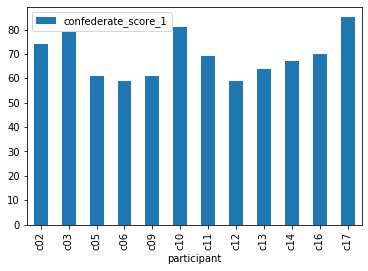

In [126]:
c_scores_1_bar = c_scores_1.plot.bar()

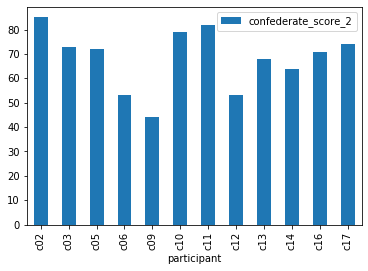

In [127]:
c_scores_2_bar = c_scores_2.plot.bar()

In [128]:
#merge both games by participant:
c_scores = pd.merge(c_scores_1, c_scores_2, on = 'participant')

In [129]:
#label columns
c_scores.columns=['Game 1','Game 2']

In [130]:
c_scores

,Game 1,Game 2
participant,,
c02,74,85
c03,79,73
c05,61,72
c06,59,53
c09,61,44
c10,81,79
c11,69,82
c12,59,53
c13,64,68


([<matplotlib.axis.YTick at 0x1a22de8890>,
 <a list of 6 Text yticklabel objects>)

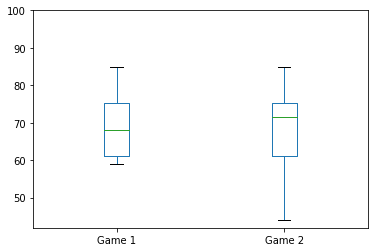

In [131]:
c_scores_box = c_scores.boxplot(labels=['Game 1','Game 2'])
plt.grid(b=None)
plt.yticks(np.arange(50, 105, step=10))

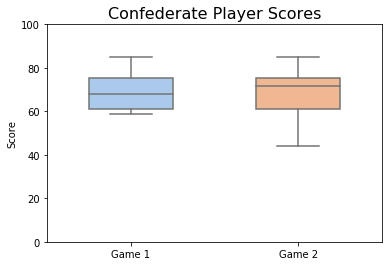

In [132]:
c_scores_box = sns.boxplot( 
                 data=c_scores, 
                 width=0.5,
                 palette="pastel")
c_scores_box.axes.set_title("Confederate Player Scores",
                    fontsize=16)

plot_file_name="c_score_box.jpg"
 
plt.ylim(0, 100)
c_scores_box.axes.set(ylabel='Score')

# save as jpeg
c_scores_box.figure.savefig(plot_file_name,
                    format='jpeg',
                    dpi=100)

In [133]:
c_scores_p = sp.stats.ttest_rel(c_scores['Game 1'],c_scores['Game 2'])

In [134]:
c_scores_p

Ttest_relResult(statistic=0.34188840128339476, pvalue=0.7388773653404721)

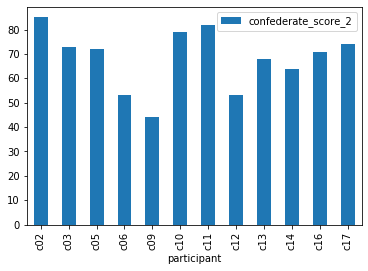

In [135]:
c_scores_2_bar = c_scores_2.plot.bar()

In [136]:
#combine g1 and g2 to one dataframe
c_combo = c_scores_1.append(c_scores_2)

/Users/simonefroley/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:7123: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [137]:
'''c_combo = pd.DataFrame({'participant':['c02', 'c02', 'c03', 'c03',
                              'c06','c06','c09','c09','c10','c10','c11','c11','c12','c12','c13','c13','c14','c14','c16','c16','c17','c17'], 'score':
     [c02_p1_g1_score, c02_p1_g2_score, c03_p1_g1_score, c03_p1_g2_score, c05_p1_g1_score, c05_p1_g2_score, c06_p1_g1_score, c06_p1_g2_score, c09_p1_g1_score, c09_p1_g2_score, c10_p1_g1_score, c10_p1_g2_score, c11_p1_g1_score, c11_p1_g2_score, c12_p1_g1_score, c12_p1_g2_score, c13_p1_g1_score, c13_p1_g2_score, c14_p1_g1_score, c14_p1_g2_score, c16_p1_g1_score, c16_p1_g2_score, c17_p1_g1_score, c17_p1_g2_score]})
c_combo.set_index('participant', inplace=True, drop=True)'''

"c_combo = pd.DataFrame({'participant':['c02', 'c02', 'c03', 'c03',\n                              'c06','c06','c09','c09','c10','c10','c11','c11','c12','c12','c13','c13','c14','c14','c16','c16','c17','c17'], 'score':\n     [c02_p1_g1_score, c02_p1_g2_score, c03_p1_g1_score, c03_p1_g2_score, c05_p1_g1_score, c05_p1_g2_score, c06_p1_g1_score, c06_p1_g2_score, c09_p1_g1_score, c09_p1_g2_score, c10_p1_g1_score, c10_p1_g2_score, c11_p1_g1_score, c11_p1_g2_score, c12_p1_g1_score, c12_p1_g2_score, c13_p1_g1_score, c13_p1_g2_score, c14_p1_g1_score, c14_p1_g2_score, c16_p1_g1_score, c16_p1_g2_score, c17_p1_g1_score, c17_p1_g2_score]})\nc_combo.set_index('participant', inplace=True, drop=True)"

In [138]:
#new_index = ('c02_g1','c02_g2','c03_g1','c03_g2','c04_g1','c04_g2','c05_g1','c05_g2','c06_g1','c06_g2','c09_g1','c09_g2','c10_g1','c10_g2','c11_g1','c11_g2','c12_g1','c12_g2','c13_g1','c13_g2','c14_g1','c14_g2','c16_g1','c16_g2','c17_g1','c17_g2')
#c_combo.index = new_index

In [139]:
c_combo = c_combo.sort_values(by=['participant'])

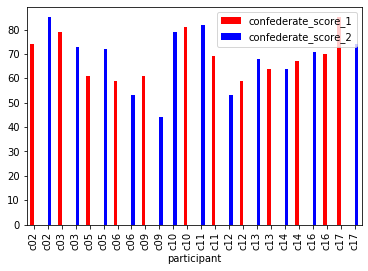

In [140]:
#unnecessary graph
#need to make g1 and g2 bars diff colors
colors = list(islice(cycle(['red','blue','red', 'red','blue','red','blue','red','blue','red','blue','red','blue','red','blue']),None,len(c_combo)))
#my_colors = list(islice(cycle(['b', 'r', 'g', 'y', 'k']), None, len(df)))
c_combo_bar = c_combo.plot(kind='bar',color=colors)

In [141]:
c_scores_1_mean = c_scores_1.mean()

In [142]:
c_scores_1_mean

confederate_score_1    69.083333
dtype: float64

In [143]:
c_scores_1_std = c_scores_1.std()

In [144]:
c_scores_1_std

confederate_score_1    8.959082
dtype: float64

In [145]:
c_scores_2_mean = c_scores_2.mean()

In [146]:
c_scores_2_mean

confederate_score_2    68.166667
dtype: float64

In [147]:
c_scores_2_std = c_scores_2.std()

In [148]:
c_scores_2_std

confederate_score_2    12.554125
dtype: float64

In [149]:
c_scores_med = c_scores.median()
c_scores_med

Game 1    68.0
Game 2    71.5
dtype: float64

# Confederate choice probabilities

In [150]:
#s01_p1_g1, s01_p1_g2 = separate_df(s01, 's')
c02_p1_g1, c02_p1_g2 = separate_df(c02, 'c')
c03_p1_g1, c03_p1_g2 = separate_df(c03, 'c')
c05_p1_g1, c05_p1_g2 = separate_df(c05, 'c')
c06_p1_g1, c06_p1_g2 = separate_df(c06, 'c')
c09_p1_g1, c09_p1_g2 = separate_df(c09, 'c')
c10_p1_g1, c10_p1_g2 = separate_df(c10, 'c')
c11_p1_g1, c11_p1_g2 = separate_df(c11, 'c')
c12_p1_g1, c12_p1_g2 = separate_df(c12, 'c')
c13_p1_g1, c13_p1_g2 = separate_df(c13, 'c')
c14_p1_g1, c14_p1_g2 = separate_df(c14, 'c')
c16_p1_g1, c16_p1_g2 = separate_df(c16, 'c')
c17_p1_g1, c17_p1_g2 = separate_df(c17, 'c')

/Users/simonefroley/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/Users/simonefroley/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [151]:
c02_p1_g1_count = c02_p1_g1['probability'].value_counts(sort=False)
c02_p1_g2_count = c02_p1_g2['probability'].value_counts(sort=False)
c03_p1_g1_count = c03_p1_g1['probability'].value_counts(sort=False)
c03_p1_g2_count = c03_p1_g2['probability'].value_counts(sort=False)
c05_p1_g1_count = c05_p1_g1['probability'].value_counts(sort=False)
c05_p1_g2_count = c05_p1_g2['probability'].value_counts(sort=False)
c06_p1_g1_count = c06_p1_g1['probability'].value_counts(sort=False)
c06_p1_g2_count = c06_p1_g2['probability'].value_counts(sort=False)
c09_p1_g1_count = c09_p1_g1['probability'].value_counts(sort=False)
c09_p1_g2_count = c09_p1_g2['probability'].value_counts(sort=False)
c10_p1_g1_count = c10_p1_g1['probability'].value_counts(sort=False)
c10_p1_g2_count = c10_p1_g2['probability'].value_counts(sort=False)
c11_p1_g1_count = c11_p1_g1['probability'].value_counts(sort=False)
c11_p1_g2_count = c11_p1_g2['probability'].value_counts(sort=False)
c12_p1_g1_count = c12_p1_g1['probability'].value_counts(sort=False)
c12_p1_g2_count = c12_p1_g2['probability'].value_counts(sort=False)
c13_p1_g1_count = c13_p1_g1['probability'].value_counts(sort=False)
c13_p1_g2_count = c13_p1_g2['probability'].value_counts(sort=False)
c14_p1_g1_count = c14_p1_g1['probability'].value_counts(sort=False)
c14_p1_g2_count = c14_p1_g2['probability'].value_counts(sort=False)
c16_p1_g1_count = c16_p1_g1['probability'].value_counts(sort=False)
c16_p1_g2_count = c16_p1_g2['probability'].value_counts(sort=False)
c17_p1_g1_count = c17_p1_g1['probability'].value_counts(sort=False)
c17_p1_g2_count = c17_p1_g2['probability'].value_counts(sort=False)

# Confederate choices in G1

In [152]:
c_g1_counts = pd.DataFrame([c02_p1_g1_count, c03_p1_g1_count,
                            c05_p1_g1_count, c06_p1_g1_count, c09_p1_g1_count, c10_p1_g1_count, c11_p1_g1_count, c12_p1_g1_count, c13_p1_g1_count, c14_p1_g1_count, c16_p1_g1_count, c17_p1_g1_count],
         index=['c02_p1_g1_count', 'c03_p1_g1_count', 'c05_p1_g1_count', 'c06_p1_g1_count', 
                'c09_p1_g1_count', 'c10_p1_g1_count', 'c11_p1_g1_count', 'c12_p1_g1_count', 'c13_p1_g1_count', 'c14_p1_g1_count', 
                'c16_p1_g1_count', 'c17_p1_g1_count'])

In [153]:
#How to prevent NaN: df = df.fillna(0)
c_g1_counts = c_g1_counts.fillna(0)

#print
c_g1_counts

,30,60,90
c02_p1_g1_count,1.0,4.0,15.0
c03_p1_g1_count,3.0,0.0,17.0
c05_p1_g1_count,7.0,7.0,6.0
c06_p1_g1_count,3.0,5.0,12.0
c09_p1_g1_count,6.0,9.0,5.0
c10_p1_g1_count,1.0,1.0,18.0
c11_p1_g1_count,3.0,8.0,9.0
c12_p1_g1_count,8.0,8.0,4.0
c13_p1_g1_count,7.0,6.0,7.0
c14_p1_g1_count,2.0,4.0,14.0


In [154]:
c_g1_counts.sum(axis=1)

c02_p1_g1_count    20.0
c03_p1_g1_count    20.0
c05_p1_g1_count    20.0
c06_p1_g1_count    20.0
c09_p1_g1_count    20.0
c10_p1_g1_count    20.0
c11_p1_g1_count    20.0
c12_p1_g1_count    20.0
c13_p1_g1_count    20.0
c14_p1_g1_count    20.0
c16_p1_g1_count    20.0
c17_p1_g1_count    20.0
dtype: float64

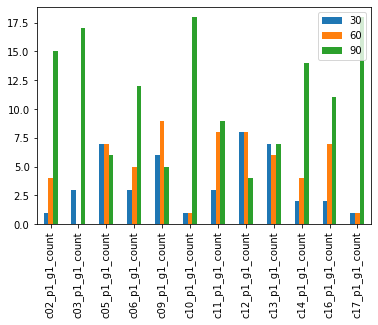

In [155]:
c_g1_counts_bar = c_g1_counts.plot.bar()

# save as jpeg
c_g1_counts_bar.figure.savefig(plot_file_name,
                    format='jpeg',
                    dpi=100)

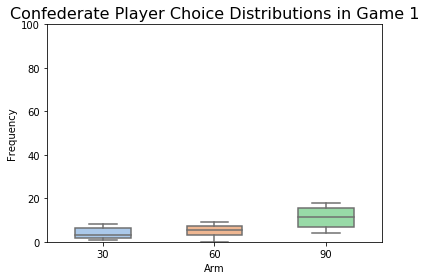

In [156]:
c_g1_counts_box = sns.boxplot( 
                 data=c_g1_counts, 
                 width=0.5,
                 palette="pastel")
c_g1_counts_box.axes.set_title("Confederate Player Choice Distributions in Game 1",
                    fontsize=16)

plot_file_name="c_g1_counts_box.jpg"
 
plt.ylim(0, 100)
c_g1_counts_box.axes.set(xlabel='Arm',ylabel='Frequency')

# save as jpeg
c_g1_counts_box.figure.savefig(plot_file_name,
                    format='jpeg',
                    dpi=100)

In [157]:
#0 is low (30), 1 is med (60), 2 is high (90)
c_g1_low = np.mean(c_g1_counts.iloc[:,0])
c_g1_med = np.mean(c_g1_counts.iloc[:,1])
c_g1_high = np.mean(c_g1_counts.iloc[:,2])

In [158]:
c_g1_low

3.6666666666666665

In [159]:
c_g1_med

5.0

In [160]:
c_g1_high

11.333333333333334

In [161]:
c_g1_low_std = np.std(c_g1_counts.iloc[:,0])
c_g1_med_std = np.std(c_g1_counts.iloc[:,1])
c_g1_high_std = np.std(c_g1_counts.iloc[:,2])

In [162]:
c_g1_low_std

2.494438257849294

In [163]:
c_g1_med_std

2.9154759474226504

In [164]:
c_g1_high_std

4.904646323187388

# Confederate choices in G2

In [165]:
c_g2_counts = pd.DataFrame([c02_p1_g2_count, c03_p1_g2_count,
                            c05_p1_g2_count, c06_p1_g2_count, c09_p1_g2_count, c10_p1_g2_count, c11_p1_g2_count, c12_p1_g2_count, c13_p1_g2_count, c14_p1_g2_count, c16_p1_g2_count, c17_p1_g2_count],
         index=['c02_p1_g2_count', 'c03_p1_g2_count', 'c05_p1_g2_count', 'c06_p1_g2_count', 
                'c09_p1_g2_count', 'c10_p1_g2_count', 'c11_p1_g2_count', 'c12_p1_g2_count', 'c13_p1_g2_count', 'c14_p1_g2_count', 
                'c16_p1_g2_count', 'c17_p1_g2_count'])

In [166]:
#How to prevent NaN: df = df.fillna(0)
c_g2_counts = c_g2_counts.fillna(0)

#print
c_g2_counts

,30,60,90
c02_p1_g2_count,1.0,5.0,14.0
c03_p1_g2_count,0.0,2.0,18.0
c05_p1_g2_count,6.0,6.0,8.0
c06_p1_g2_count,7.0,7.0,6.0
c09_p1_g2_count,10.0,8.0,2.0
c10_p1_g2_count,0.0,2.0,18.0
c11_p1_g2_count,1.0,4.0,15.0
c12_p1_g2_count,4.0,10.0,6.0
c13_p1_g2_count,4.0,2.0,14.0
c14_p1_g2_count,6.0,9.0,5.0


In [167]:
c_g2_counts.sum(axis=1)

c02_p1_g2_count    20.0
c03_p1_g2_count    20.0
c05_p1_g2_count    20.0
c06_p1_g2_count    20.0
c09_p1_g2_count    20.0
c10_p1_g2_count    20.0
c11_p1_g2_count    20.0
c12_p1_g2_count    20.0
c13_p1_g2_count    20.0
c14_p1_g2_count    20.0
c16_p1_g2_count    20.0
c17_p1_g2_count    20.0
dtype: float64

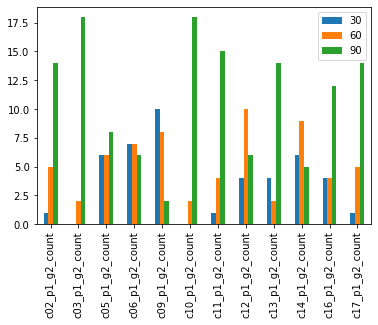

In [168]:
c_g2_counts_bar = c_g2_counts.plot.bar()

# save as jpeg
c_g2_counts_bar.figure.savefig(plot_file_name,
                    format='jpeg',
                    dpi=100)

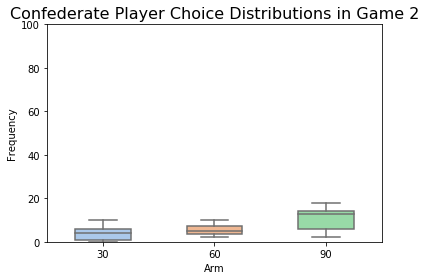

In [169]:
c_g2_counts_box = sns.boxplot( 
                 data=c_g2_counts, 
                 width=0.5,
                 palette="pastel")
c_g2_counts_box.axes.set_title("Confederate Player Choice Distributions in Game 2",
                    fontsize=16)

plot_file_name="c_g2_counts_box.jpg"
 
plt.ylim(0, 100)
s=c_g2_counts_box.axes.set(xlabel='Arm',ylabel='Frequency')

# save as jpeg
c_g2_counts_box.figure.savefig(plot_file_name,
                    format='jpeg',
                    dpi=100)

In [170]:
c_g2_low = np.mean(c_g2_counts.iloc[:,0])
c_g2_med = np.mean(c_g2_counts.iloc[:,1])
c_g2_high = np.mean(c_g2_counts.iloc[:,2])

In [171]:
c_g2_low

3.6666666666666665

In [172]:
c_g2_med

5.333333333333333

In [173]:
c_g2_high

11.0

In [174]:
c_g2_low_std = np.std(c_g2_counts.iloc[:,0])
c_g2_med_std = np.std(c_g2_counts.iloc[:,1])
c_g2_high_std = np.std(c_g2_counts.iloc[:,2])

In [175]:
c_g2_low_std

3.0368111930481

In [176]:
c_g2_med_std

2.6246692913372702

In [177]:
c_g2_high_std 

5.1478150704935

# Confederate arrays

In [178]:
#pip install researchpy

In [179]:
import researchpy as rp

In [180]:
c_90_1 = np.array(c_g1_counts.iloc[:,2])
c_90_2 = np.array(c_g2_counts.iloc[:,2])

In [181]:
c_90_1

array([15., 17.,  6., 12.,  5., 18.,  9.,  4.,  7., 14., 11., 18.])

In [182]:
c_90_2

array([14., 18.,  8.,  6.,  2., 18., 15.,  6., 14.,  5., 12., 14.])

In [183]:
c_60_1 = np.array(c_g1_counts.iloc[:,1])
c_60_2 = np.array(c_g2_counts.iloc[:,1])

In [184]:
c_60_1

array([4., 0., 7., 5., 9., 1., 8., 8., 6., 4., 7., 1.])

In [185]:
c_60_2

array([ 5.,  2.,  6.,  7.,  8.,  2.,  4., 10.,  2.,  9.,  4.,  5.])

In [186]:
c_30_1 = np.array(c_g1_counts.iloc[:,0])
c_30_2 = np.array(c_g2_counts.iloc[:,0])

In [187]:
c_30_1

array([1., 3., 7., 3., 6., 1., 3., 8., 7., 2., 2., 1.])

In [188]:
c_30_2

array([ 1.,  0.,  6.,  7., 10.,  0.,  1.,  4.,  4.,  6.,  4.,  1.])

# Confederate choice statistics

In [189]:
c_90_p = sp.stats.ttest_rel(c_90_1,c_90_2)
c_60_p = sp.stats.ttest_rel(c_60_1,c_60_2)
c_30_p = sp.stats.ttest_rel(c_30_1,c_30_2)

In [190]:
c_90_p

Ttest_relResult(statistic=0.24894142079195158, pvalue=0.8079930045928573)

In [191]:
c_60_p

Ttest_relResult(statistic=-0.389517827488081, pvalue=0.7043286669080466)

In [192]:
c_30_p

Ttest_relResult(statistic=0.0, pvalue=1.0)

In [193]:
#maximizing and matching?

In [194]:
#maximizing and matching?

In [195]:
s_g1_counts

,30,60,90
s01_p1_g1_count,6.0,9.0,5.0
s03_p1_g1_count,4.0,8.0,8.0
s05_p1_g1_count,0.0,16.0,4.0
s06_p1_g1_count,0.0,1.0,19.0
s07_p1_g1_count,5.0,6.0,9.0
s08_p1_g1_count,0.0,2.0,18.0
s09_p1_g1_count,2.0,5.0,13.0
s11_p1_g1_count,7.0,8.0,5.0
s12_p1_g1_count,1.0,4.0,15.0
s15_p1_g1_count,0.0,3.0,17.0


In [196]:
s_g1_counts.sum(axis=1)

s01_p1_g1_count    20.0
s03_p1_g1_count    20.0
s05_p1_g1_count    20.0
s06_p1_g1_count    20.0
s07_p1_g1_count    20.0
s08_p1_g1_count    20.0
s09_p1_g1_count    20.0
s11_p1_g1_count    20.0
s12_p1_g1_count    20.0
s15_p1_g1_count    20.0
s16_p1_g1_count    20.0
s17_p1_g1_count    20.0
s19_p1_g1_count    20.0
s20_p1_g1_count    20.0
dtype: float64

In [197]:
s_g2_counts

,30,60,90
s01_p1_g2_count,10.0,2.0,8.0
s03_p1_g2_count,4.0,3.0,13.0
s05_p1_g2_count,0.0,0.0,20.0
s06_p1_g2_count,0.0,2.0,18.0
s07_p1_g2_count,3.0,5.0,12.0
s08_p1_g2_count,0.0,3.0,17.0
s09_p1_g2_count,3.0,6.0,11.0
s11_p1_g2_count,4.0,4.0,12.0
s12_p1_g2_count,1.0,0.0,19.0
s15_p1_g2_count,0.0,2.0,18.0


In [198]:
s_g2_counts.sum(axis=1)

s01_p1_g2_count    20.0
s03_p1_g2_count    20.0
s05_p1_g2_count    20.0
s06_p1_g2_count    20.0
s07_p1_g2_count    20.0
s08_p1_g2_count    20.0
s09_p1_g2_count    20.0
s11_p1_g2_count    20.0
s12_p1_g2_count    20.0
s15_p1_g2_count    20.0
s16_p1_g2_count    20.0
s17_p1_g2_count    20.0
s19_p1_g2_count    20.0
s20_p1_g2_count    20.0
dtype: float64

In [199]:
c_g1_counts

,30,60,90
c02_p1_g1_count,1.0,4.0,15.0
c03_p1_g1_count,3.0,0.0,17.0
c05_p1_g1_count,7.0,7.0,6.0
c06_p1_g1_count,3.0,5.0,12.0
c09_p1_g1_count,6.0,9.0,5.0
c10_p1_g1_count,1.0,1.0,18.0
c11_p1_g1_count,3.0,8.0,9.0
c12_p1_g1_count,8.0,8.0,4.0
c13_p1_g1_count,7.0,6.0,7.0
c14_p1_g1_count,2.0,4.0,14.0


In [200]:
c_g1_counts.sum(axis=1)

c02_p1_g1_count    20.0
c03_p1_g1_count    20.0
c05_p1_g1_count    20.0
c06_p1_g1_count    20.0
c09_p1_g1_count    20.0
c10_p1_g1_count    20.0
c11_p1_g1_count    20.0
c12_p1_g1_count    20.0
c13_p1_g1_count    20.0
c14_p1_g1_count    20.0
c16_p1_g1_count    20.0
c17_p1_g1_count    20.0
dtype: float64

In [201]:
c_g2_counts

,30,60,90
c02_p1_g2_count,1.0,5.0,14.0
c03_p1_g2_count,0.0,2.0,18.0
c05_p1_g2_count,6.0,6.0,8.0
c06_p1_g2_count,7.0,7.0,6.0
c09_p1_g2_count,10.0,8.0,2.0
c10_p1_g2_count,0.0,2.0,18.0
c11_p1_g2_count,1.0,4.0,15.0
c12_p1_g2_count,4.0,10.0,6.0
c13_p1_g2_count,4.0,2.0,14.0
c14_p1_g2_count,6.0,9.0,5.0


In [202]:
c_g2_counts.sum(axis=1)

c02_p1_g2_count    20.0
c03_p1_g2_count    20.0
c05_p1_g2_count    20.0
c06_p1_g2_count    20.0
c09_p1_g2_count    20.0
c10_p1_g2_count    20.0
c11_p1_g2_count    20.0
c12_p1_g2_count    20.0
c13_p1_g2_count    20.0
c14_p1_g2_count    20.0
c16_p1_g2_count    20.0
c17_p1_g2_count    20.0
dtype: float64

# Maximizing/Matching CONTROL

In [427]:
#Here we compare the choice distributions to idealized models of two decision-making strategies: 
#matching and maximizing. Matching would be choosing each each hole proportionally to its reward rate, 
#and maximizing would be always choosing the high reward hole.

In [428]:
#JSD: Jensen Shannon Divergence. Measures the similarity between two probability distributions. Taken from 
#https://gist.github.com/zhiyzuo/f80e2b1cfb493a5711330d271a228a3d. *Note: probability distributions need to be
#normalized.'''
#parameters: p and q are the two probability distributions to be compared.

def jsd(p, q, base=np.e):
    
    
    #Implementation of pairwise `jsd` based on https://en.wikipedia.org/wiki/Jensen%E2%80%93Shannon_divergence
    # convert to np.array
    p, q = np.asarray(p), np.asarray(q)
    # normalize p, q to probabilities
    p, q = p/p.sum(), q/q.sum()
    m = 1./2*(p + q)
    return sp.stats.entropy(p,m, base=base)/2. +  sp.stats.entropy(q, m, base=base)/2.

In [429]:
#Are ppl using a strategy similar to their partner's? This functions calls jsd for p1 and for p2. *UNFINISHED* 
#DO NOT USE.
#calls jsd for p1 and p2 and for p1 and p2 with the mean
#def compare_strat(p1,p2):
    #strat = jsd(p1,p2)
   # comp_1 = jsd(p1,[j_g1_low,j_g1_med,j_g1_high])
    #comp_2 = jsd(p2,[j_g1_low,j_g1_med,j_g1_high])
    #return strat, comp_1, comp_2

In [430]:
#Idealized probability distributions to use for comparison. You can change these or add more models.

maximize = [0,0,100]
match = [30/180 * 100,60/180 * 100,90/180 * 100]
random = [30/90 * 100,30/90 * 100,30/90 * 100]
social = [0,100,0]

In [431]:
#This function calls jsd. 
#Input: counts- a player's choice distributions in a particular game (ex. s01_p1_g1_counts)
#Output: maxi- JSD score for the maximizing strategy
        #matchi- JSD score for the matching strategy
def call_jsd(counts):
    maxi = jsd(counts,maximize) #(p, q)
    matchi = jsd(counts,match)
    rando = jsd(counts,random)
    soci = jsd(counts, social)
    return maxi,matchi,rando,soci

In [432]:
from scipy import stats

In [433]:
#if same, 0
test = jsd(random,random)

In [434]:
test

0.0

In [435]:
def check_type(df,*social):
    types = pd.DataFrame(index=['type'])
    

In [439]:
#Call 'call_jsd' for each participant for each game in the single player sessions.
#with 0, put in actual probabilities in brackets

s01_g1_max,s01_g1_match,s01_g1_rand,s01_g1_soc = call_jsd(s01_p1_g1_count)
s01_g2_max,s01_g2_match,s01_g2_rand,s01_g2_soc = call_jsd(s01_p1_g2_count)
s03_g1_max,s03_g1_match,s03_g1_rand,s03_g1_soc = call_jsd(s03_p1_g1_count)
s03_g2_max,s03_g2_match,s03_g2_rand,s03_g2_soc = call_jsd(s03_p1_g2_count)
s05_g1_max,s05_g1_match,s05_g1_rand,s05_g1_soc= call_jsd([0, 16, 4])
s05_g2_max,s05_g2_match,s05_g2_rand,s05_g2_soc = call_jsd([0, 0, 20])
s06_g1_max,s06_g1_match,s06_g1_rand,s06_g1_soc = call_jsd([0, 1, 19])
s06_g2_max,s06_g2_match,s06_g2_rand,s06_g2_soc = call_jsd([0, 2, 18])
s07_g1_max,s07_g1_match,s07_g1_rand,s07_g1_soc = call_jsd(s07_p1_g1_count)
s07_g2_max,s07_g2_match,s07_g2_rand,s07_g2_soc = call_jsd(s07_p1_g2_count)
s08_g1_max,s08_g1_match,s08_g1_rand,s08_g1_soc = call_jsd([0, 2, 18])
s08_g2_max,s08_g2_match,s08_g2_rand,s08_g2_soc = call_jsd([0, 3, 17])
s09_g1_max,s09_g1_match,s09_g1_rand,s09_g1_soc = call_jsd(s09_p1_g1_count)
s09_g2_max,s09_g2_match,s09_g2_rand,s09_g2_soc = call_jsd(s09_p1_g2_count)
s11_g1_max,s11_g1_match,s11_g1_rand,s11_g1_soc = call_jsd(s11_p1_g1_count)
s11_g2_max,s11_g2_match,s11_g2_rand,s11_g2_soc = call_jsd(s11_p1_g2_count)
s12_g1_max,s12_g1_match,s12_g1_rand,s12_g1_soc = call_jsd(s12_p1_g1_count)
s12_g2_max,s12_g2_match,s12_g2_rand,s12_g2_soc = call_jsd([1, 0, 19])
s15_g1_max,s15_g1_match,s15_g1_rand,s15_g1_soc = call_jsd([0, 3, 17])
s15_g2_max,s15_g2_match,s15_g2_rand,s15_g2_soc = call_jsd([0, 2, 18])
s16_g1_max,s16_g1_match,s16_g1_rand,s16_g1_soc = call_jsd(s16_p1_g1_count)
s16_g2_max,s16_g2_match,s16_g2_rand,s16_g2_soc = call_jsd(s16_p1_g2_count)
s17_g1_max,s17_g1_match,s17_g1_rand,s17_g1_soc = call_jsd([0, 0, 20])
s17_g2_max,s17_g2_match,s17_g2_rand,s17_g2_soc = call_jsd([0, 3, 17])
s19_g1_max,s19_g1_match,s19_g1_rand,s19_g1_soc = call_jsd([0, 0, 20])
s19_g2_max,s19_g2_match,s19_g2_rand,s19_g2_soc = call_jsd(s19_p1_g2_count)
s20_g1_max,s20_g1_match,s20_g1_rand,s20_g1_soc = call_jsd(s20_p1_g1_count)
s20_g2_max,s20_g2_match,s20_g2_rand,s20_g2_soc = call_jsd(s20_p1_g2_count)
c02_g1_max,c02_g1_match,c02_g1_rand,c02_g1_soc = call_jsd(c02_p1_g1_count)
c02_g2_max,c02_g2_match,c02_g2_rand,c02_g2_soc = call_jsd(c02_p1_g2_count)
c03_g1_max,c03_g1_match,c03_g1_rand,c03_g1_soc = call_jsd([3, 0, 17])
c03_g2_max,c03_g2_match,c03_g2_rand,c03_g2_soc = call_jsd([0, 2, 18])
c05_g1_max,c05_g1_match,c05_g1_rand,c05_g1_soc = call_jsd(c05_p1_g1_count)
c05_g2_max,c05_g2_match,c05_g2_rand,c05_g2_soc = call_jsd(c05_p1_g2_count)
c06_g1_max,c06_g1_match,c06_g1_rand,c06_g1_soc = call_jsd(c06_p1_g1_count)
c06_g2_max,c06_g2_match,c06_g2_rand,c06_g2_soc = call_jsd(c06_p1_g1_count)
c09_g1_max,c09_g1_match,c09_g1_rand,c09_g1_soc = call_jsd(c09_p1_g1_count)
c09_g2_max,c09_g2_match,c09_g2_rand,c09_g2_soc = call_jsd(c09_p1_g2_count)
c10_g1_max,c10_g1_match,c10_g1_rand,c10_g1_soc = call_jsd(c10_p1_g1_count)
c10_g2_max,c10_g2_match,c10_g2_rand,c10_g2_soc = call_jsd([0, 2, 18])
c11_g1_max,c11_g1_match,c11_g1_rand,c11_g1_soc = call_jsd(c11_p1_g1_count)
c11_g2_max,c11_g2_match,c11_g2_rand,c11_g2_soc= call_jsd(c11_p1_g2_count)
c12_g1_max,c12_g1_match,c12_g1_rand,c12_g1_soc = call_jsd(c12_p1_g1_count)
c12_g2_max,c12_g2_match,c12_g2_rand,c12_g2_soc = call_jsd(c12_p1_g2_count)
c13_g1_max,c13_g1_match,c13_g1_rand,c13_g1_soc = call_jsd(c13_p1_g1_count)
c13_g2_max,c13_g2_match,c13_g2_rand,c13_g2_soc = call_jsd(c13_p1_g2_count)
c14_g1_max,c14_g1_match,c14_g1_rand,c14_g1_soc = call_jsd(c14_p1_g1_count)
c14_g2_max,c14_g2_match,c14_g2_rand,c14_g2_soc = call_jsd(c14_p1_g2_count)
c16_g1_max,c16_g1_match,c16_g1_rand,c16_g1_soc = call_jsd(c16_p1_g1_count)
c16_g2_max,c16_g2_match,c16_g2_rand,c16_g2_soc = call_jsd(c16_p1_g2_count)
c17_g1_max,c17_g1_match,c17_g1_rand,c17_g1_soc = call_jsd(c17_p1_g1_count)
c17_g2_max,c17_g2_match,c17_g2_rand,c17_g2_soc = call_jsd([0,1,19])

In [440]:
#Create a dataframe for single player game 1 jsd scores, with a column for each strategy.'''
control_jsd_g1 = pd.DataFrame({'max':[s01_g1_max,s03_g1_max,s05_g1_max,s06_g1_max,s07_g1_max,s08_g1_max,
                                s09_g1_max, s11_g1_max, s12_g1_max, s15_g1_max, s16_g1_max, s17_g1_max, 
                                      s19_g1_max, s20_g1_max, c02_g1_max, c03_g1_max, c05_g1_max, c06_g1_max, 
                                      c09_g1_max, c10_g1_max, c11_g1_max, c12_g1_max, c13_g1_max, c14_g1_max, 
                                      c16_g1_max, c17_g1_max],
                      'match':[s01_g1_match,s03_g1_match,s05_g1_match
                               ,s06_g1_match,s07_g1_match,s08_g1_match,s09_g1_match, s11_g1_match, 
                               s12_g1_match, s15_g1_match, s16_g1_match, s17_g1_match, s19_g1_match, 
                               s20_g1_match, c02_g1_match, c03_g1_match, c05_g1_match, c06_g1_match, 
                                      c09_g1_match, c10_g1_match, c11_g1_match, c12_g1_match, c13_g1_match, c14_g1_match, 
                                      c16_g1_match, c17_g1_match],
                    'rand':[s01_g1_rand,s03_g1_rand,s05_g1_rand,s06_g1_rand,s07_g1_rand,s08_g1_rand,
                                s09_g1_rand, s11_g1_rand, s12_g1_rand, s15_g1_rand, s16_g1_rand, s17_g1_rand, 
                                      s19_g1_rand, s20_g1_rand, c02_g1_rand, c03_g1_rand, c05_g1_rand, c06_g1_rand, 
                                      c09_g1_rand, c10_g1_rand, c11_g1_rand, c12_g1_rand, c13_g1_rand, c14_g1_rand, 
                                      c16_g1_rand, c17_g1_rand],
                        'soc':[s01_g1_soc,s03_g1_soc,s05_g1_soc,s06_g1_soc,s07_g1_soc,s08_g1_soc,
                                s09_g1_soc, s11_g1_soc, s12_g1_soc, s15_g1_soc, s16_g1_soc, s17_g1_soc, 
                                      s19_g1_soc, s20_g1_soc, c02_g1_soc, c03_g1_soc, c05_g1_soc, c06_g1_soc, 
                                      c09_g1_soc, c10_g1_soc, c11_g1_soc, c12_g1_soc, c13_g1_soc, c14_g1_soc, 
                                      c16_g1_soc, c17_g1_soc]},
                              
                        index=['s01', 's03','s05','s06','s07','s08','s09', 's11', 's12', 's15', 's16', 's17', 's19', 's20', 'c02', 'c03', 
                               'c05', 'c06', 'c09', 'c10', 'c11', 'c12', 'c13', 'c14', 'c16', 'c17'])

In [441]:
#closer to 0 = closer to that pure strategy
control_jsd_g1

,max,match,rand,soc
s01,0.342014,0.021189,0.007785,0.244099
s03,0.422810,0.059473,0.011457,0.274358
s05,0.422810,0.140468,0.173445,0.074882
s06,0.017649,0.151897,0.251394,0.592639
s07,0.380396,0.055476,0.007785,0.342014
s08,0.035974,0.119873,0.216261,0.525597
s09,0.525597,0.152177,0.062078,0.380396
s11,0.306858,0.012365,0.004605,0.274358
s12,0.592639,0.215642,0.108175,0.422810
s15,0.055030,0.098537,0.191694,0.470500


In [442]:
# get the column name of min values in every row
strategy_control_jsd_g1 = control_jsd_g1.idxmin(axis=1)
 
print("min values of row are at following columns :")
print(strategy_control_jsd_g1)


min values of row are at following columns :
s01     rand
s03     rand
s05      soc
s06      max
s07     rand
s08      max
s09     rand
s11     rand
s12     rand
s15      max
s16     rand
s17      max
s19      max
s20     rand
c02     rand
c03      max
c05     rand
c06     rand
c09     rand
c10     rand
c11     rand
c12    match
c13     rand
c14     rand
c16     rand
c17     rand
dtype: object


In [443]:
strategy_control_jsd_g1.value_counts()

rand     18
max       6
match     1
soc       1
dtype: int64

In [444]:
#control_types_g1 = check_type(control_jsd_g1)

In [445]:
#control_types_g1.drop([0])

In [446]:
#(control_types_g1 == 'maxi').sum()

In [447]:
#Create a dataframe for single player game 1 jsd scores, with a column for each strategy.'''
control_jsd_g2 = pd.DataFrame({'max':[s01_g2_max,s03_g2_max,s05_g2_max,s06_g2_max,s07_g2_max,s08_g2_max,
                                s09_g2_max, s11_g2_max, s12_g2_max, s15_g2_max, s16_g2_max, s17_g2_max, 
                                      s19_g2_max, s20_g2_max, c02_g2_max, c03_g2_max, c05_g2_max, c06_g2_max, 
                                      c09_g2_max, c10_g2_max, c11_g2_max, c12_g2_max, c13_g2_max, c14_g2_max, 
                                      c16_g2_max, c17_g2_max],
                      'match':[s01_g2_match,s03_g2_match,s05_g2_match
                               ,s06_g2_match,s07_g2_match,s08_g2_match,s09_g2_match, s11_g2_match, 
                               s12_g2_match, s15_g2_match, s16_g2_match, s17_g2_match, s19_g2_match, 
                               s20_g2_match, c02_g2_match, c03_g2_match, c05_g2_match, c06_g2_match, 
                                      c09_g2_match, c10_g2_match, c11_g2_match, c12_g2_match, c13_g2_match, c14_g2_match, 
                                      c16_g2_match, c17_g2_match],
                    'rand':[s01_g2_rand,s03_g2_rand,s05_g2_rand,s06_g2_rand,s07_g2_rand,s08_g2_rand,
                                s09_g2_rand, s11_g2_rand, s12_g2_rand, s15_g2_rand, s16_g2_rand, s17_g2_rand, 
                                      s19_g2_rand, s20_g2_rand, c02_g2_rand, c03_g2_rand, c05_g2_rand, c06_g2_rand, 
                                      c09_g2_rand, c10_g2_rand, c11_g2_rand, c12_g2_rand, c13_g2_rand, c14_g2_rand, 
                                      c16_g2_rand, c17_g2_rand],
                        'soc':[s01_g2_soc,s03_g2_soc,s05_g2_soc,s06_g2_soc,s07_g2_soc,s08_g2_soc,
                                s09_g2_soc, s11_g2_soc, s12_g2_soc, s15_g2_soc, s16_g2_soc, s17_g2_soc, 
                                      s19_g2_soc, s20_g2_soc, c02_g2_soc, c03_g2_soc, c05_g2_soc, c06_g2_soc, 
                                      c09_g2_soc, c10_g2_soc, c11_g2_soc, c12_g2_soc, c13_g2_soc, c14_g2_soc, 
                                      c16_g2_soc, c17_g2_soc]},
                              
                        index=['s01', 's03','s05','s06','s07','s08','s09', 's11', 's12', 's15', 's16', 's17', 's19', 's20', 'c02', 'c03', 
                               'c05', 'c06', 'c09', 'c10', 'c11', 'c12', 'c13', 'c14', 'c16', 'c17'])

In [448]:
control_jsd_g2

,max,match,rand,soc
s01,0.215762,0.057887,0.043045,0.525597
s03,0.422810,0.127450,0.052205,0.470500
s05,0.000000,0.215762,0.318257,0.693147
s06,0.035974,0.119873,0.216261,0.525597
s07,0.470500,0.117691,0.040130,0.380396
s08,0.055030,0.098537,0.191694,0.470500
s09,0.470500,0.104181,0.031689,0.342014
s11,0.422810,0.106628,0.036160,0.422810
s12,0.017649,0.167590,0.251394,0.693147
s15,0.035974,0.119873,0.216261,0.525597


In [449]:
# get the column name of min values in every row
strategy_control_jsd_g2 = control_jsd_g2.idxmin(axis=1)
 
print("min values of row are at following columns :")
print(strategy_control_jsd_g2)


min values of row are at following columns :
s01     rand
s03     rand
s05      max
s06      max
s07     rand
s08      max
s09     rand
s11     rand
s12      max
s15      max
s16     rand
s17      max
s19     rand
s20     rand
c02     rand
c03      max
c05     rand
c06     rand
c09    match
c10      max
c11     rand
c12     rand
c13     rand
c14     rand
c16     rand
c17      max
dtype: object


In [450]:
strategy_control_jsd_g2.value_counts()

rand     16
max       9
match     1
dtype: int64

In [451]:
#control_types_g2 = check_type(control_jsd_g2)

In [226]:
#control_types_g2.drop([0])

In [227]:
#(control_types_g2 == 'maxi').sum()

In [228]:
#how different max and match dists are from eachother
#neither max or match(?)
#threshold = jsd(maximize,match)

In [229]:
import matplotlib.lines as mlines

In [230]:
#colors_jsd = [['lightcoral','red','lightcoral','red','bisque','orange','bisque','orange','palegreen','green','palegreen','green',
              #'lightblue','blue','lightblue','blue','mediumslateblue','indigo','mediumslateblue','indigo','lightpink','deeppink',
              #'lightpink','deeppink','yellow','gold','yellow','gold','lightgray','gray','lightgray','gray']              

In [231]:
import itertools

In [232]:
#Here I print the means of the JSD values in each condition, just to see what they are.'''

In [233]:
#run t test to see sig between max and match per game
#put in box plot
control_jsd_g1.mean()

max      0.225146
match    0.073886
rand     0.096379
soc      0.391850
dtype: float64

In [234]:
control_jsd_g2.mean()

max      0.203077
match    0.099893
rand     0.128325
soc      0.448837
dtype: float64

# Control strategy stats 

In [235]:
control_jsd_g1.dropna(inplace = True) 

# Max strategy

In [236]:
control_max_g1 = control_jsd_g1.loc[ : , 'max' ]

In [237]:
control_max_g1

s01    0.215762
s03    0.380396
s05    0.251473
s06    0.017649
s07    0.306858
s08    0.035974
s09    0.342014
s11    0.306858
s12    0.215762
s15    0.055030
s16    0.342014
s17    0.013011
s19    0.000000
s20    0.342014
c02    0.244099
c03    0.055030
c05    0.342014
c06    0.342014
c09    0.380396
c10    0.000000
c11    0.422810
c12    0.306858
c13    0.342014
c14    0.342014
c16    0.215762
c17    0.035974
Name: max, dtype: float64

In [238]:
control_max_g2 = control_jsd_g2.loc[ : , 'max' ]

In [239]:
control_max_g2

s01    0.244099
s03    0.380396
s05    0.000000
s06    0.074882
s07    0.422810
s08    0.055030
s09    0.189094
s11    0.244099
s12    0.017649
s15    0.035974
s16    0.274358
s17    0.089110
s19    0.000000
s20    0.592639
c02    0.000000
c03    0.000000
c05    0.342014
c06    0.342014
c09    0.306858
c10    0.035974
c11    0.525597
c12    0.189094
c13    0.422810
c14    0.422810
c16    0.055030
c17    0.017649
Name: max, dtype: float64

In [240]:
control_max_g1_mean = control_max_g1.mean()

In [241]:
control_max_g1_mean

0.2251461782292409

In [242]:
control_max_g1_std = control_max_g1.std()

In [243]:
control_max_g1_std

0.14465403616068484

In [244]:
control_max_g2_mean = control_max_g2.mean()

In [245]:
control_max_g2_mean

0.20307667100687835

In [246]:
control_max_g2_std = control_max_g2.std()
control_max_g2_std

0.18472867323517675

Max T-Test 

In [247]:
control_max_p = sp.stats.ttest_rel(control_max_g1,control_max_g2)

In [248]:
control_max_p

Ttest_relResult(statistic=0.962766221426645, pvalue=0.34488553427457613)

# Match strategy

In [249]:
control_match_g1 = control_jsd_g1.loc[ : , 'match' ]

In [250]:
control_match_g1

s01    0.000321
s03    0.039378
s05    0.006066
s06    0.151897
s07    0.016412
s08    0.119873
s09    0.049419
s11    0.034388
s12    0.066152
s15    0.098537
s16    0.029358
s17    0.163186
s19    0.215762
s20    0.021189
c02    0.071843
c03    0.138690
c05    0.049419
c06    0.084498
c09    0.033822
c10    0.215762
c11    0.054191
c12    0.011771
c13    0.029358
c14    0.049419
c16    0.066152
c17    0.104180
Name: match, dtype: float64

In [251]:
control_match_g2 = control_jsd_g2.loc[ : , 'match' ]

In [252]:
control_match_g2

s01    0.067595
s03    0.067828
s05    0.215762
s06    0.083649
s07    0.051255
s08    0.085795
s09    0.062718
s11    0.005292
s12    0.167590
s15    0.104180
s16    0.005059
s17    0.076101
s19    0.215762
s20    0.142779
c02    0.215762
c03    0.215762
c05    0.023809
c06    0.084498
c09    0.012365
c10    0.119873
c11    0.138213
c12    0.001254
c13    0.077250
c14    0.106628
c16    0.098537
c17    0.151897
Name: match, dtype: float64

In [253]:
control_match_g1_mean = control_match_g1.mean()

In [254]:
control_match_g1_mean

0.07388626117184005

In [255]:
control_match_g1_std = control_match_g1.std()

In [256]:
control_match_g1_std

0.06094224892394445

In [257]:
control_match_g2_mean = control_match_g2.mean()

In [258]:
control_match_g2_mean

0.09989270632625674

In [259]:
control_match_g2_std = control_match_g2.std()

In [260]:
control_match_g2_std

0.06737411551645703

In [261]:
control_match_p = sp.stats.ttest_rel(control_match_g1,control_match_g2)

In [262]:
control_match_p

Ttest_relResult(statistic=-1.8672622630590225, pvalue=0.07363358166026425)

# Random strategy

In [263]:
control_rand_g1 = control_jsd_g1.loc[ : , 'rand' ]

In [264]:
control_rand_g1

s01    0.026319
s03    0.004605
s05    0.031625
s06    0.251394
s07    0.000642
s08    0.216261
s09    0.007785
s11    0.004605
s12    0.132304
s15    0.191694
s16    0.000642
s17    0.263472
s19    0.318257
s20    0.007785
c02    0.133307
c03    0.191694
c05    0.007785
c06    0.031689
c09    0.014363
c10    0.318257
c11    0.012884
c12    0.012884
c13    0.000642
c14    0.007785
c16    0.132304
c17    0.184874
Name: rand, dtype: float64

In [265]:
control_rand_g2 = control_jsd_g2.loc[ : , 'rand' ]

In [266]:
control_rand_g2

s01    0.041858
s03    0.014363
s05    0.318257
s06    0.173445
s07    0.017251
s08    0.150116
s09    0.133307
s11    0.007785
s12    0.251394
s15    0.184874
s16    0.011457
s17    0.163491
s19    0.318257
s20    0.078055
c02    0.318257
c03    0.318257
c05    0.002395
c06    0.031689
c09    0.004605
c10    0.216261
c11    0.052892
c12    0.031689
c13    0.017251
c14    0.036160
c16    0.191694
c17    0.251394
Name: rand, dtype: float64

In [267]:
control_rand_g1_mean = control_rand_g1.mean()

In [268]:
control_rand_g1_mean

0.09637927858593555

In [269]:
control_rand_g1_std = control_rand_g1.std()

In [270]:
control_rand_g1_std

0.11034846762214916

In [271]:
control_rand_g2_mean = control_rand_g2.mean()

In [272]:
control_rand_g2_mean

0.1283252510031665

In [273]:
control_rand_g2_std = control_rand_g2.std()
control_rand_g2_std

0.11544476771881021

In [274]:
control_rand_p = sp.stats.ttest_rel(control_rand_g1,control_rand_g2)

In [275]:
control_rand_p

Ttest_relResult(statistic=-1.901459907151789, pvalue=0.06882716470973808)

# Social strategy

In [276]:
control_soc_g1 = control_jsd_g1.loc[ : , 'soc' ]

In [277]:
control_soc_g1

s01    0.306858
s03    0.274358
s05    0.251473
s06    0.592639
s07    0.306858
s08    0.525597
s09    0.380396
s11    0.380396
s12    0.215762
s15    0.470500
s16    0.306858
s17    0.613256
s19    0.693147
s20    0.244099
c02    0.189094
c03    0.693147
c05    0.380396
c06    0.470500
c09    0.215762
c10    0.693147
c11    0.244099
c12    0.244099
c13    0.306858
c14    0.380396
c16    0.215762
c17    0.592639
Name: soc, dtype: float64

In [278]:
control_soc_g2 = control_jsd_g2.loc[ : , 'soc' ]

In [279]:
control_soc_g2

s01    0.525597
s03    0.380396
s05    0.693147
s06    0.422810
s07    0.215762
s08    0.592639
s09    0.244099
s11    0.342014
s12    0.693147
s15    0.592639
s16    0.274358
s17    0.393010
s19    0.693147
s20    0.163897
c02    0.693147
c03    0.693147
c05    0.274358
c06    0.470500
c09    0.274358
c10    0.525597
c11    0.342014
c12    0.342014
c13    0.342014
c14    0.422810
c16    0.470500
c17    0.592639
Name: soc, dtype: float64

In [280]:
control_soc_g1_mean = control_soc_g1.mean()

In [281]:
control_soc_g1_mean

0.3918498090714647

In [282]:
control_soc_g1_std = control_soc_g1.std()

In [283]:
control_soc_g1_std

0.1667098745270291

In [284]:
control_soc_g2_mean = control_soc_g2.mean()

In [285]:
control_soc_g2_mean

0.44883710753916783

In [286]:
control_soc_g2_std = control_soc_g2.std()

In [287]:
control_soc_g2_std

0.16694407713730425

In [288]:
control_soc_p = sp.stats.ttest_rel(control_soc_g1,control_soc_g2)

In [289]:
control_soc_p

Ttest_relResult(statistic=-1.5195897980883175, pvalue=0.14116123248639798)

# Joint Analysis

In [241]:
df = organize_trial_by_trial('data/j01_gamedata.csv')
j01 = df
j01_p1_g1_score,j01_p1_g2_score,j01_p2_g1_score,j01_p2_g2_score,j01_p1_diff,j01_p2_diff = call_get_score(j01, 'j')
j01.head()

,game number,trial,player,arm,probability,P1 score,P2 score
0,1,1,1,3,60,1,0
1,1,1,2,3,60,1,1
2,1,2,1,1,90,2,1
3,1,2,2,2,90,2,2
4,1,3,1,2,30,2,2


In [242]:
df = organize_trial_by_trial('data/j02_gamedata.csv')
j02 = df
j02_p1_g1_score,j02_p1_g2_score,j02_p2_g1_score,j02_p2_g2_score,j02_p1_diff,j02_p2_diff = call_get_score(j02, 'j')
j02.head()

,game number,trial,player,arm,probability,P1 score,P2 score
0,1,1,1,3,30,0,0
1,1,1,2,1,60,0,1
2,1,2,1,2,90,1,1
3,1,2,2,3,90,1,2
4,1,3,1,2,90,2,2


In [243]:
df = organize_trial_by_trial('data/j03_gamedata.csv')
j03 = df
j03_p1_g1_score,j03_p1_g2_score,j03_p2_g1_score,j03_p2_g2_score,j03_p1_diff,j03_p2_diff = call_get_score(j03, 'j')
j03.head()

,game number,trial,player,arm,probability,P1 score,P2 score
0,1,1,1,2,90,1,0
1,1,1,2,2,30,1,0
2,1,2,1,3,30,2,0
3,1,2,2,1,60,2,1
4,1,3,1,2,90,3,1


In [244]:
df = organize_trial_by_trial('data/j04_gamedata.csv')
j04 = df
j04_p1_g1_score,j04_p1_g2_score,j04_p2_g1_score,j04_p2_g2_score,j04_p1_diff,j04_p2_diff = call_get_score(j04, 'j')
j04.head()

,game number,trial,player,arm,probability,P1 score,P2 score
0,1,1,1,2,30,0,0
1,1,1,2,2,90,0,0
2,1,2,1,3,60,1,0
3,1,2,2,2,90,1,1
4,1,3,1,2,30,1,1


In [245]:
df = organize_trial_by_trial('data/j05_gamedata.csv')
j05 = df
j05_p1_g1_score,j05_p1_g2_score,j05_p2_g1_score,j05_p2_g2_score,j05_p1_diff,j05_p2_diff = call_get_score(j05, 'j')
j05.head()

,game number,trial,player,arm,probability,P1 score,P2 score
0,1,1,1,2,90,1,0
1,1,1,2,1,90,1,1
2,1,2,1,3,60,2,1
3,1,2,2,2,30,2,1
4,1,3,1,1,30,2,1


In [246]:
df = organize_trial_by_trial('data/j06_gamedata.csv')
j06 = df
j06_p1_g1_score,j06_p1_g2_score,j06_p2_g1_score,j06_p2_g2_score,j06_p1_diff,j06_p2_diff = call_get_score(j06, 'j')
j06.head()

,game number,trial,player,arm,probability,P1 score,P2 score
0,1,1,1,3,30,0,0
1,1,1,2,2,60,0,1
2,1,2,1,1,90,1,1
3,1,2,2,3,90,1,2
4,1,3,1,2,60,2,2


In [247]:
df = organize_trial_by_trial('data/j07_gamedata.csv')
j07 = df
j07_p1_g1_score,j07_p1_g2_score,j07_p2_g1_score,j07_p2_g2_score,j07_p1_diff,j07_p2_diff = call_get_score(j07, 'j')
j07.head()

,game number,trial,player,arm,probability,P1 score,P2 score
0,1,1,1,2,60,1,0
1,1,1,2,3,30,1,0
2,1,2,1,1,30,1,0
3,1,2,2,2,60,1,1
4,1,3,1,3,90,2,1


In [248]:
df = organize_trial_by_trial('data/j08_gamedata.csv')
j08 = df
j08_p1_g1_score,j08_p1_g2_score,j08_p2_g1_score,j08_p2_g2_score,j08_p1_diff,j08_p2_diff = call_get_score(j08, 'j')
j08.head()

,game number,trial,player,arm,probability,P1 score,P2 score
0,1,1,1,3,60,1,0
1,1,1,2,2,30,1,0
2,1,2,1,3,60,2,0
3,1,2,2,1,90,2,1
4,1,3,1,3,60,3,1


In [249]:
df = organize_trial_by_trial_floatclick('data/j10_gamedata.csv')
j10 = df
j10_p1_g1_score,j10_p1_g2_score,j10_p2_g1_score,j10_p2_g2_score,j10_p1_diff,j10_p2_diff = call_get_score(j10, 'j')
j10.head()

,game number,trial,player,arm,probability,P1 score,P2 score
1,1,1,2,1,60,1,0
2,1,2,1,2,30,1,1
3,1,2,2,1,60,1,1
4,1,3,1,3,90,1,2
5,1,3,2,1,60,2,2


In [250]:
df = organize_trial_by_trial_floatclick('data/j11_gamedata.csv')
j11 = df
j11_p1_g1_score,j11_p1_g2_score,j11_p2_g1_score,j11_p2_g2_score,j11_p1_diff,j11_p2_diff = call_get_score(j11, 'j')
j11.head()

,game number,trial,player,arm,probability,P1 score,P2 score
1,1,1,2,1,90,1,0
2,1,2,1,2,60,1,0
3,1,2,2,3,30,1,0
4,1,3,1,3,90,1,0
5,1,3,2,1,90,2,0


In [251]:
j01_p1_g1, j01_p1_g2, j01_p2_g1, j01_p2_g2 = separate_df(j01, 'j')
j02_p1_g1, j02_p1_g2, j02_p2_g1, j02_p2_g2 = separate_df(j02, 'j')
j03_p1_g1, j03_p1_g2, j03_p2_g1, j03_p2_g2 = separate_df(j03, 'j')
j04_p1_g1, j04_p1_g2, j04_p2_g1, j04_p2_g2 = separate_df(j04, 'j')
j05_p1_g1, j05_p1_g2, j05_p2_g1, j05_p2_g2 = separate_df(j05, 'j')
j06_p1_g1, j06_p1_g2, j06_p2_g1, j06_p2_g2 = separate_df(j06, 'j')
j07_p1_g1, j07_p1_g2, j07_p2_g1, j07_p2_g2 = separate_df(j07, 'j')
j08_p1_g1, j08_p1_g2, j08_p2_g1, j08_p2_g2 = separate_df(j08, 'j')
j10_p1_g1, j10_p1_g2, j10_p2_g1, j10_p2_g2 = separate_df(j10, 'j')
j11_p1_g1, j11_p1_g2, j11_p2_g1, j11_p2_g2 = separate_df(j11, 'j')


/Users/simonefroley/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/Users/simonefroley/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/simonefroley/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/simonefroley/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [252]:
j01_p1_g1_count = j01_p1_g1['probability'].value_counts(sort=False)
j01_p1_g2_count = j01_p1_g2['probability'].value_counts(sort=False)
j01_p2_g1_count = j01_p2_g1['probability'].value_counts(sort=False)
j01_p2_g2_count = j01_p2_g2['probability'].value_counts(sort=False)
j02_p1_g1_count = j02_p1_g1['probability'].value_counts(sort=False)
j02_p1_g2_count = j02_p1_g2['probability'].value_counts(sort=False)
j02_p2_g1_count = j02_p2_g1['probability'].value_counts(sort=False)
j02_p2_g2_count = j02_p2_g2['probability'].value_counts(sort=False)
j03_p1_g1_count = j03_p1_g1['probability'].value_counts(sort=False)
j03_p1_g2_count = j03_p1_g2['probability'].value_counts(sort=False)
j03_p2_g1_count = j03_p2_g1['probability'].value_counts(sort=False)
j03_p2_g2_count = j03_p2_g2['probability'].value_counts(sort=False)
j04_p1_g1_count = j04_p1_g1['probability'].value_counts(sort=False)
j04_p1_g2_count = j04_p1_g2['probability'].value_counts(sort=False)
j04_p2_g1_count = j04_p2_g1['probability'].value_counts(sort=False)
j04_p2_g2_count = j04_p2_g2['probability'].value_counts(sort=False)
j05_p1_g1_count = j05_p1_g1['probability'].value_counts(sort=False)
j05_p1_g2_count = j05_p1_g2['probability'].value_counts(sort=False)
j05_p2_g1_count = j05_p2_g1['probability'].value_counts(sort=False)
j05_p2_g2_count = j05_p2_g2['probability'].value_counts(sort=False)
j06_p1_g1_count = j06_p1_g1['probability'].value_counts(sort=False)
j06_p1_g2_count = j06_p1_g2['probability'].value_counts(sort=False)
j06_p2_g1_count = j06_p2_g1['probability'].value_counts(sort=False)
j06_p2_g2_count = j06_p2_g2['probability'].value_counts(sort=False)
j07_p1_g1_count = j07_p1_g1['probability'].value_counts(sort=False)
j07_p1_g2_count = j07_p1_g2['probability'].value_counts(sort=False)
j07_p2_g1_count = j07_p2_g1['probability'].value_counts(sort=False)
j07_p2_g2_count = j07_p2_g2['probability'].value_counts(sort=False)
j08_p1_g1_count = j08_p1_g1['probability'].value_counts(sort=False)
j08_p1_g2_count = j08_p1_g2['probability'].value_counts(sort=False)
j08_p2_g1_count = j08_p2_g1['probability'].value_counts(sort=False)
j08_p2_g2_count = j08_p2_g2['probability'].value_counts(sort=False)
j10_p1_g1_count = j10_p1_g1['probability'].value_counts(sort=False)
j10_p1_g2_count = j10_p1_g2['probability'].value_counts(sort=False)
j10_p2_g1_count = j10_p2_g1['probability'].value_counts(sort=False)
j10_p2_g2_count = j10_p2_g2['probability'].value_counts(sort=False)
j11_p1_g1_count = j11_p1_g1['probability'].value_counts(sort=False)
j11_p1_g2_count = j11_p1_g2['probability'].value_counts(sort=False)
j11_p2_g1_count = j11_p2_g1['probability'].value_counts(sort=False)
j11_p2_g2_count = j11_p2_g2['probability'].value_counts(sort=False)

# Combined Joint scores G1

In [253]:
j_scores_1 = pd.DataFrame({'participant':['j01_p1', 'j01_p2','j02_p1', 'j02_p2','j03_p1', 'j03_p2','j04_p1', 'j04_p2','j05_p1', 'j05_p2','j06_p1','j06_p2','j07_p1', 'j07_p2','j08_p1', 'j08_p2','j10_p1', 'j10_p2','j11_p1', 'j11_p2'], 'j_score_1':
     [j01_p1_g1_score, j01_p2_g1_score, j02_p1_g1_score, j02_p2_g1_score, j03_p1_g1_score, j03_p2_g1_score,
      j04_p1_g1_score, j04_p2_g1_score, j05_p1_g1_score, j05_p2_g1_score, j06_p1_g1_score, j06_p2_g1_score,
      j07_p1_g1_score, j07_p2_g1_score, j08_p1_g1_score, j08_p2_g1_score, j10_p1_g1_score, j10_p2_g1_score, j11_p1_g1_score, j11_p2_g1_score]})
j_scores_1.set_index('participant', inplace=True, drop=True)
j_scores_1

,j_score_1
participant,
j01_p1,57
j01_p2,61
j02_p1,54
j02_p2,68
j03_p1,69
j03_p2,67
j04_p1,64
j04_p2,56
j05_p1,77


# Combined Joint scores G2

In [254]:
j_scores_2 = pd.DataFrame({'participant':['j01_p1', 'j01_p2','j02_p1', 'j02_p2','j03_p1', 'j03_p2','j04_p1', 'j04_p2','j05_p1', 'j05_p2','j06_p1','j06_p2','j07_p1', 'j07_p2','j08_p1', 'j08_p2','j10_p1', 'j10_p2','j11_p1', 'j11_p2'], 'j_score_2':
     [j01_p1_g2_score, j01_p2_g2_score, j02_p1_g2_score, j02_p2_g2_score, j03_p1_g2_score, j03_p2_g2_score,
      j04_p1_g2_score, j04_p2_g2_score, j05_p1_g2_score, j05_p2_g2_score, j06_p1_g2_score, j06_p2_g2_score,
      j07_p1_g2_score, j07_p2_g2_score, j08_p1_g2_score, j08_p2_g2_score, j10_p1_g2_score, j10_p2_g2_score, j11_p1_g2_score, j11_p2_g2_score]})
j_scores_2.set_index('participant', inplace=True, drop=True)
j_scores_2

,j_score_2
participant,
j01_p1,73
j01_p2,60
j02_p1,72
j02_p2,76
j03_p1,82
j03_p2,75
j04_p1,60
j04_p2,54
j05_p1,70


In [255]:
j_scores = pd.merge(j_scores_1, j_scores_2, on = 'participant')
j_scores.columns=['Game 1','Game 2']
#jp1_scores.set_index('participant', inplace=True, drop=True)
j_scores

,Game 1,Game 2
participant,,
j01_p1,57,73
j01_p2,61,60
j02_p1,54,72
j02_p2,68,76
j03_p1,69,82
j03_p2,67,75
j04_p1,64,60
j04_p2,56,54
j05_p1,77,70


In [256]:
j_scores_1_mean = j_scores_1.mean()

In [257]:
j_scores_1_mean

j_score_1    66.8
dtype: float64

In [258]:
j_scores_1_std = j_scores_1.std()

In [259]:
j_scores_1_std

j_score_1    9.539944
dtype: float64

In [260]:
j_scores_2_mean = j_scores_2.mean()

In [261]:
j_scores_2_mean

j_score_2    74.1
dtype: float64

In [262]:
j_scores_2_std = j_scores_2.std()

In [263]:
j_scores_2_std

j_score_2    8.403633
dtype: float64

In [264]:
j_scores_med = j_scores.median()
j_scores_med

Game 1    66.5
Game 2    75.5
dtype: float64

In [265]:
j_scores_p = sp.stats.ttest_rel(j_scores['Game 1'],j_scores['Game 2'])

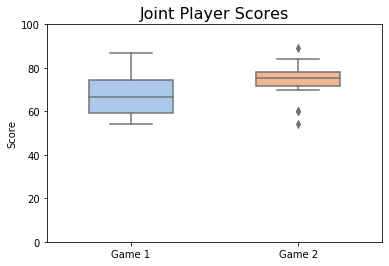

In [266]:
j_scores_box = sns.boxplot( 
                 data=j_scores, 
                 width=0.5,
                 palette="pastel")
j_scores_box.axes.set_title("Joint Player Scores",
                    fontsize=16)

plot_file_name="j_score_box.jpg"
 
plt.ylim(0, 100)
j_scores_box.axes.set(ylabel='Score')

# save as jpeg
j_scores_box.figure.savefig(plot_file_name,
                    format='jpeg',
                    dpi=100)

In [267]:
j_scores_p

Ttest_relResult(statistic=-3.548498529057052, pvalue=0.002145546053304259)

# Joint combined choices in G1

In [268]:
j_g1_counts = pd.DataFrame([j01_p1_g1_count, j01_p2_g1_count, j02_p1_g1_count, j02_p2_g1_count, j03_p1_g1_count, 
              j03_p2_g1_count, j04_p1_g1_count, j04_p2_g1_count, j05_p1_g1_count, j05_p2_g1_count, j06_p1_g1_count, 
              j06_p2_g1_count, j07_p1_g1_count, j07_p2_g1_count, j08_p1_g1_count, j08_p2_g1_count, 
              j10_p1_g1_count, j10_p2_g1_count, j11_p1_g1_count, j11_p2_g1_count],
                index = ['j01_p1_g1_count', 'j01_p2_g1_count', 'j02_p1_g1_count', 'j02_p2_g1_count', 
                 'j03_p1_g1_count', 'j03_p2_g1_count', 'j04_p1_g1_count', 'j04_p2_g1_count', 'j05_p1_g1_count', 
                  'j05_p2_g1_count', 'j06_p1_g1_count', 'j06_p2_g1_count', 'j07_p1_g1_count', 
                    'j07_p2_g1_count', 'j08_p1_g1_count', 'j08_p2_g1_count', 'j10_p1_g1_count', 'j10_p2_g1_count', 
                    'j11_p1_g1_count', 'j11_p2_g1_count'])


In [269]:
j_g1_counts = j_g1_counts.fillna(0)

In [270]:
j_g1_counts 

,30,60,90
j01_p1_g1_count,8.0,9.0,3.0
j01_p2_g1_count,8.0,6.0,6.0
j02_p1_g1_count,5.0,6.0,9.0
j02_p2_g1_count,0.0,11.0,9.0
j03_p1_g1_count,6.0,7.0,7.0
j03_p2_g1_count,8.0,5.0,7.0
j04_p1_g1_count,5.0,8.0,7.0
j04_p2_g1_count,4.0,10.0,6.0
j05_p1_g1_count,1.0,3.0,16.0
j05_p2_g1_count,4.0,4.0,12.0


In [271]:
j_g1_counts.sum(axis=1)

j01_p1_g1_count    20.0
j01_p2_g1_count    20.0
j02_p1_g1_count    20.0
j02_p2_g1_count    20.0
j03_p1_g1_count    20.0
j03_p2_g1_count    20.0
j04_p1_g1_count    20.0
j04_p2_g1_count    20.0
j05_p1_g1_count    20.0
j05_p2_g1_count    20.0
j06_p1_g1_count    20.0
j06_p2_g1_count    20.0
j07_p1_g1_count    20.0
j07_p2_g1_count    20.0
j08_p1_g1_count    20.0
j08_p2_g1_count    20.0
j10_p1_g1_count    20.0
j10_p2_g1_count    20.0
j11_p1_g1_count    20.0
j11_p2_g1_count    20.0
dtype: float64

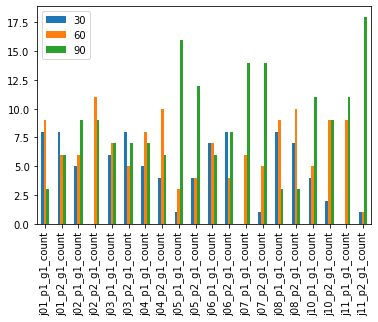

In [272]:
j_g1_counts_bar = j_g1_counts.plot.bar()

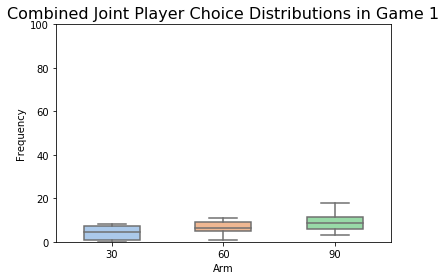

In [273]:
j_g1_counts_box = sns.boxplot( 
                 data=j_g1_counts, 
                 width=0.5,
                 palette="pastel")
j_g1_counts_box.axes.set_title("Combined Joint Player Choice Distributions in Game 1",
                    fontsize=16)

plot_file_name="j_g1_counts_box.jpg"
 
plt.ylim(0, 100)
j_g1_counts_box.axes.set(xlabel='Arm',ylabel='Frequency')

# save as jpeg
j_g1_counts_box.figure.savefig(plot_file_name,
                    format='jpeg',
                    dpi=100)

In [274]:
j_g1_low = np.mean(j_g1_counts.iloc[:,0])
j_g1_med = np.mean(j_g1_counts.iloc[:,1])
j_g1_high = np.mean(j_g1_counts.iloc[:,2])

In [275]:
j_g1_low

4.35

In [276]:
j_g1_med

6.7

In [277]:
j_g1_high

8.95

In [278]:
j_g1_low_std = np.std(j_g1_counts.iloc[:,0])
j_g1_med_std = np.std(j_g1_counts.iloc[:,1])
j_g1_high_std = np.std(j_g1_counts.iloc[:,2])

In [279]:
j_g1_low_std

3.004579837514723

In [280]:
j_g1_med_std

2.5903667693977237

In [281]:
j_g1_high_std

4.153010955921016

# Joint combined choices in G2

In [282]:
j_g2_counts = pd.DataFrame([j01_p1_g2_count, j01_p2_g2_count, j02_p1_g2_count, j02_p2_g2_count, j03_p1_g2_count, 
              j03_p2_g2_count, j04_p1_g2_count, j04_p2_g2_count, j05_p1_g2_count, j05_p2_g2_count, j06_p1_g2_count, 
              j06_p2_g2_count, j07_p1_g2_count, j07_p2_g2_count, j08_p1_g2_count, j08_p2_g2_count, 
              j10_p1_g2_count, j10_p2_g2_count, j11_p1_g2_count, j11_p2_g2_count],
                index = ['j01_p1_g2_count', 'j01_p2_g2_count', 'j02_p1_g2_count', 'j02_p2_g2_count', 
                 'j03_p1_g2_count', 'j03_p2_g2_count', 'j04_p1_g2_count', 'j04_p2_g2_count', 'j05_p1_g2_count', 
                  'j05_p2_g2_count', 'j06_p1_g2_count', 'j06_p2_g2_count', 'j07_p1_g1_count', 'j07_p1_g2_count', 
                 'j08_p1_g2_count', 'j08_p2_g2_count', 'j10_p1_g2_count', 'j10_p2_g2_count', 
                    'j11_p1_g2_count', 'j11_p2_g2_count'])


In [283]:
j_g2_counts = j_g2_counts.fillna(0)
j_g2_counts 

,30,60,90
j01_p1_g2_count,3.0,6.0,11.0
j01_p2_g2_count,4.0,7.0,9.0
j02_p1_g2_count,7.0,5.0,8.0
j02_p2_g2_count,1.0,7.0,12.0
j03_p1_g2_count,0.0,11.0,9.0
j03_p2_g2_count,0.0,0.0,20.0
j04_p1_g2_count,9.0,6.0,5.0
j04_p2_g2_count,8.0,9.0,3.0
j05_p1_g2_count,3.0,1.0,16.0
j05_p2_g2_count,0.0,9.0,11.0


In [284]:
j_g2_counts.sum(axis=1)

j01_p1_g2_count    20.0
j01_p2_g2_count    20.0
j02_p1_g2_count    20.0
j02_p2_g2_count    20.0
j03_p1_g2_count    20.0
j03_p2_g2_count    20.0
j04_p1_g2_count    20.0
j04_p2_g2_count    20.0
j05_p1_g2_count    20.0
j05_p2_g2_count    20.0
j06_p1_g2_count    20.0
j06_p2_g2_count    20.0
j07_p1_g1_count    20.0
j07_p1_g2_count    20.0
j08_p1_g2_count    20.0
j08_p2_g2_count    20.0
j10_p1_g2_count    20.0
j10_p2_g2_count    20.0
j11_p1_g2_count    20.0
j11_p2_g2_count    20.0
dtype: float64

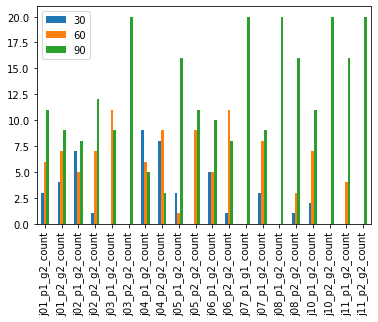

In [285]:
j_g2_counts_bar = j_g2_counts.plot.bar()

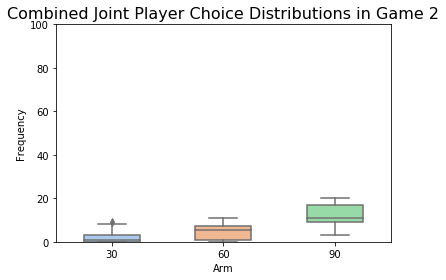

In [286]:
j_g2_counts_box = sns.boxplot( 
                 data=j_g2_counts, 
                 width=0.5,
                 palette="pastel")
j_g2_counts_box.axes.set_title("Combined Joint Player Choice Distributions in Game 2",
                    fontsize=16)

plot_file_name="j_g2_counts_box.jpg"
 
plt.ylim(0, 100)
j_g2_counts_box.axes.set(xlabel='Arm',ylabel='Frequency')

# save as jpeg
j_g2_counts_box.figure.savefig(plot_file_name,
                    format='jpeg',
                    dpi=100)

In [287]:
j_g2_low = np.mean(j_g2_counts.iloc[:,0])
j_g2_med = np.mean(j_g2_counts.iloc[:,1])
j_g2_high = np.mean(j_g2_counts.iloc[:,2])

In [288]:
j_g2_low

2.35

In [289]:
j_g2_med

4.95

In [290]:
j_g2_high

12.7

In [291]:
j_g2_low_std = np.std(j_g2_counts.iloc[:,0])
j_g2_med_std = np.std(j_g2_counts.iloc[:,1])
j_g2_high_std = np.std(j_g2_counts.iloc[:,2])

In [292]:
j_g2_low_std

2.815581645060218

In [293]:
j_g2_med_std

3.6942522924131755

In [294]:
j_g2_high_std

5.264028875300742

# Joint combined arrays

In [295]:
#pip install researchpy

In [296]:
import researchpy as rp

In [297]:
j_90_1 = np.array(j_g1_counts.iloc[:,2])
j_90_2 = np.array(j_g2_counts.iloc[:,2])

In [298]:
j_90_1

array([ 3.,  6.,  9.,  9.,  7.,  7.,  7.,  6., 16., 12.,  6.,  8., 14.,
       14.,  3.,  3., 11.,  9., 11., 18.])

In [299]:
j_90_2

array([11.,  9.,  8., 12.,  9., 20.,  5.,  3., 16., 11., 10.,  8., 20.,
        9., 20., 16., 11., 20., 16., 20.])

In [300]:
j_60_1 = np.array(j_g1_counts.iloc[:,1])
j_60_2 = np.array(j_g2_counts.iloc[:,1])

In [301]:
j_60_1

array([ 9.,  6.,  6., 11.,  7.,  5.,  8., 10.,  3.,  4.,  7.,  4.,  6.,
        5.,  9., 10.,  5.,  9.,  9.,  1.])

In [302]:
j_60_2

array([ 6.,  7.,  5.,  7., 11.,  0.,  6.,  9.,  1.,  9.,  5., 11.,  0.,
        8.,  0.,  3.,  7.,  0.,  4.,  0.])

In [303]:
j_30_1 = np.array(j_g1_counts.iloc[:,0])
j_30_2 = np.array(j_g2_counts.iloc[:,0])

In [304]:
j_30_1

array([8., 8., 5., 0., 6., 8., 5., 4., 1., 4., 7., 8., 0., 1., 8., 7., 4.,
       2., 0., 1.])

In [305]:
j_30_2

array([3., 4., 7., 1., 0., 0., 9., 8., 3., 0., 5., 1., 0., 3., 0., 1., 2.,
       0., 0., 0.])

# Joint combined choice statistics

In [306]:
j_90_p = sp.stats.ttest_rel(j_90_1,j_90_2)
j_60_p = sp.stats.ttest_rel(j_60_1,j_60_2)
j_30_p = sp.stats.ttest_rel(j_30_1,j_30_2)

In [307]:
j_90_p

Ttest_relResult(statistic=-2.8162660314547323, pvalue=0.011025683828064126)

In [308]:
j_60_p

Ttest_relResult(statistic=1.7505759420922755, pvalue=0.09614968845808645)

In [309]:
j_30_p

Ttest_relResult(statistic=2.3134633509213707, pvalue=0.032054923224996444)

In [310]:
#maximizing and matching?

# Multi Analysis

In [311]:
df = organize_trial_by_trial('data/m05_gamedata.csv')
m05 = df
m05_p1_g1_score,m05_p1_g2_score,m05_p2_g1_score,m05_p2_g2_score,m05_p1_score_diff,m05_p2_score_diff = call_get_score(m05, 'm')
m05.head()

,game number,trial,player,arm,probability,P1 score,P2 score
0,1,1,1,3,30,1,0
1,1,1,2,2,60,1,1
2,1,2,1,3,30,2,1
3,1,2,2,2,60,2,2
4,1,3,1,1,90,3,2


In [312]:
df = organize_trial_by_trial_floatclick('data/m06_gamedata.csv')
m06 = df
m06_p1_g1_score,m06_p1_g2_score,m06_p2_g1_score,m06_p2_g2_score,m06_p1_score_diff,m06_p2_score_diff = call_get_score(m06, 'm')
m06.head()

,game number,trial,player,arm,probability,P1 score,P2 score
1,1,1,2,2,30,1,0
2,1,2,1,1,90,1,0
3,1,3,2,2,30,2,0
4,1,4,1,2,60,2,0
5,1,5,2,1,90,3,0


In [313]:
df = organize_trial_by_trial_floatclick('data/m08_gamedata.csv')
m08 = df
m08_p1_g1_score,m08_p1_g2_score,m08_p2_g1_score,m08_p2_g2_score,m08_p1_score_diff,m08_p2_score_diff = call_get_score(m08, 'm')
m08.head()

,game number,trial,player,arm,probability,P1 score,P2 score
1,1,1,2,2,60,1,0
2,1,2,1,1,90,1,1
3,1,3,2,2,60,2,1
4,1,4,1,2,60,2,2
5,1,5,2,1,30,2,2


In [314]:
#df = organize_trial_by_trial_floatclick('data/m09_gamedata.csv')
#m09 = df
#m09_p1_g1_score,m09_p1_g2_score,m09_p2_g1_score,m09_p2_g2_score,m09_p1_score_diff,m09_p2_score_diff = call_get_score(m09, 'm')
#m09.head()

In [315]:
df = organize_trial_by_trial_floatclick('data/m10_gamedata.csv')
m10 = df
m10_p1_g1_score,m10_p1_g2_score,m10_p2_g1_score,m10_p2_g2_score,m10_p1_score_diff,m10_p2_score_diff = call_get_score(m10, 'm')
m10.head()

,game number,trial,player,arm,probability,P1 score,P2 score
1,1,1,2,2,60,1,0
2,1,2,1,1,90,1,1
3,1,3,2,2,60,2,1
4,1,4,1,2,60,2,2
5,1,5,2,1,30,2,2


In [316]:
df = organize_trial_by_trial_floatclick('data/m11_gamedata.csv')
m11 = df
m11_p1_g1_score,m11_p1_g2_score,m11_p2_g1_score,m11_p2_g2_score,m11_p1_score_diff,m11_p2_score_diff = call_get_score(m11, 'm')
m11.head()

,game number,trial,player,arm,probability,P1 score,P2 score
1,1,1,2,2,60,1,0
2,1,2,1,1,90,1,1
3,1,3,2,3,90,2,1
4,1,4,1,3,30,2,2
5,1,5,2,3,90,3,2


In [317]:
#df = organize_trial_by_trial_floatclick('data/m12_gamedata.csv')
#m12 = df
#m12_p1_g1_score,m12_p1_g2_score,m12_p2_g1_score,m12_p2_g2_score,m12_p1_score_diff,m12_p2_score_diff = call_get_score(m12, 'm')
#m12.head()

In [318]:
df = organize_trial_by_trial_floatclick('data/m13_gamedata.csv')
m13 = df
m13_p1_g1_score,m13_p1_g2_score,m13_p2_g1_score,m13_p2_g2_score,m13_p1_score_diff,m13_p2_score_diff = call_get_score(m13, 'm')
m13.head()

,game number,trial,player,arm,probability,P1 score,P2 score
1,1,1,2,3,90,1,0
2,1,2,1,3,30,1,1
3,1,3,2,1,30,1,1
4,1,4,1,1,90,1,1
5,1,5,2,1,30,2,1


In [319]:
df = organize_trial_by_trial_floatclick('data/m14_gamedata.csv')
m14 = df
m14_p1_g1_score,m14_p1_g2_score,m14_p2_g1_score,m14_p2_g2_score,m14_p1_score_diff,m14_p2_score_diff = call_get_score(m14, 'm')
m14.head()

,game number,trial,player,arm,probability,P1 score,P2 score
1,1,1,2,3,60,1,0
2,1,2,1,3,30,1,1
3,1,3,2,3,60,2,1
4,1,4,1,1,90,2,1
5,1,5,2,2,90,3,1


In [320]:
m05_p1_g1, m05_p1_g2, m05_p2_g1, m05_p2_g2 = separate_df(m05, 'm')
m06_p1_g1, m06_p1_g2, m06_p2_g1, m06_p2_g2 = separate_df(m06, 'm')
m08_p1_g1, m08_p1_g2, m08_p2_g1, m08_p2_g2 = separate_df(m08, 'm')
m10_p1_g1, m10_p1_g2, m10_p2_g1, m10_p2_g2 = separate_df(m10, 'm')
m11_p1_g1, m11_p1_g2, m11_p2_g1, m11_p2_g2 = separate_df(m11, 'm')
m13_p1_g1, m13_p1_g2, m13_p2_g1, m13_p2_g2 = separate_df(m13, 'm')
m14_p1_g1, m14_p1_g2, m14_p2_g1, m14_p2_g2 = separate_df(m14, 'm')

/Users/simonefroley/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/Users/simonefroley/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/simonefroley/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/simonefroley/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [321]:
m05_p1_g1_count = m05_p1_g1['probability'].value_counts(sort=False)
m05_p1_g2_count = m05_p1_g2['probability'].value_counts(sort=False)
m05_p2_g1_count = m05_p2_g1['probability'].value_counts(sort=False)
m05_p2_g2_count = m05_p2_g2['probability'].value_counts(sort=False)
m06_p1_g1_count = m06_p1_g1['probability'].value_counts(sort=False)
m06_p1_g2_count = m06_p1_g2['probability'].value_counts(sort=False)
m06_p2_g1_count = m06_p2_g1['probability'].value_counts(sort=False)
m06_p2_g2_count = m06_p2_g2['probability'].value_counts(sort=False)
m08_p1_g1_count = m08_p1_g1['probability'].value_counts(sort=False)
m08_p1_g2_count = m08_p1_g2['probability'].value_counts(sort=False)
m08_p2_g1_count = m08_p2_g1['probability'].value_counts(sort=False)
m08_p2_g2_count = m08_p2_g2['probability'].value_counts(sort=False)
m10_p1_g1_count = m10_p1_g1['probability'].value_counts(sort=False)
m10_p1_g2_count = m10_p1_g2['probability'].value_counts(sort=False)
m10_p2_g1_count = m10_p2_g1['probability'].value_counts(sort=False)
m10_p2_g2_count = m10_p2_g2['probability'].value_counts(sort=False)
m11_p1_g1_count = m11_p1_g1['probability'].value_counts(sort=False)
m11_p1_g2_count = m11_p1_g2['probability'].value_counts(sort=False)
m11_p2_g1_count = m11_p2_g1['probability'].value_counts(sort=False)
m11_p2_g2_count = m11_p2_g2['probability'].value_counts(sort=False)
m13_p1_g1_count = m13_p1_g1['probability'].value_counts(sort=False)
m13_p1_g2_count = m13_p1_g2['probability'].value_counts(sort=False)
m13_p2_g1_count = m13_p2_g1['probability'].value_counts(sort=False)
m13_p2_g2_count = m13_p2_g2['probability'].value_counts(sort=False)
m14_p1_g1_count = m14_p1_g1['probability'].value_counts(sort=False)
m14_p1_g2_count = m14_p1_g2['probability'].value_counts(sort=False)
m14_p2_g1_count = m14_p2_g1['probability'].value_counts(sort=False)
m14_p2_g2_count = m14_p2_g2['probability'].value_counts(sort=False)

# Combined multi scores G1

In [322]:
m_scores_1 = pd.DataFrame({'participant':['m05_p1', 'm05_p2','m06_p1', 'm06_p2', 'm08_p1', 'm08_p2', 'm10_p1', 'm10_p2', 'm11_p1', 'm11_p2', 'm13_p1', 'm13_p2', 'm14_p1', 'm14_p2'], 'm_score_1':
     [m05_p1_g1_score, m05_p2_g1_score, m06_p1_g1_score, m06_p2_g1_score, m08_p1_g1_score, m08_p2_g1_score,
      m10_p1_g1_score, m10_p2_g1_score, m11_p1_g1_score, m11_p2_g1_score, m13_p1_g1_score, m13_p2_g1_score,
      m14_p1_g1_score, m14_p2_g1_score]})
m_scores_1.set_index('participant', inplace=True, drop=True)
m_scores_1

,m_score_1
participant,
m05_p1,86
m05_p2,75
m06_p1,57
m06_p2,71
m08_p1,69
m08_p2,82
m10_p1,69
m10_p2,57
m11_p1,80


# Combined multi scores G2

In [323]:
m_scores_2 = pd.DataFrame({'participant':['m05_p1', 'm05_p2','m06_p1', 'm06_p2', 'm08_p1', 'm08_p2', 'm10_p1', 'm10_p2', 'm11_p1', 'm11_p2', 'm13_p1', 'm13_p2', 'm14_p1', 'm14_p2'], 'm_score_1':
     [m05_p1_g2_score, m05_p2_g2_score, m06_p1_g2_score, m06_p2_g2_score, m08_p1_g2_score, m08_p2_g2_score,
      m10_p1_g2_score, m10_p2_g2_score, m11_p1_g2_score, m11_p2_g2_score, m13_p1_g2_score, m13_p2_g2_score,
      m14_p1_g2_score, m14_p2_g2_score]})
m_scores_2.set_index('participant', inplace=True, drop=True)
m_scores_2

,m_score_1
participant,
m05_p1,68
m05_p2,86
m06_p1,62
m06_p2,68
m08_p1,80
m08_p2,88
m10_p1,66
m10_p2,62
m11_p1,83


In [324]:
m_scores = pd.merge(m_scores_1, m_scores_2, on = 'participant')
m_scores.columns=['Game 1','Game 2']
#jp1_scores.set_index('participant', inplace=True, drop=True)
m_scores

,Game 1,Game 2
participant,,
m05_p1,86,68
m05_p2,75,86
m06_p1,57,62
m06_p2,71,68
m08_p1,69,80
m08_p2,82,88
m10_p1,69,66
m10_p2,57,62
m11_p1,80,83


In [325]:
m_scores_1_mean = m_scores_1.mean()

In [326]:
m_scores_1_mean

m_score_1    70.071429
dtype: float64

In [327]:
m_scores_1_std = m_scores_1.std()

In [328]:
m_scores_1_std

m_score_1    11.166325
dtype: float64

In [329]:
m_scores_2_mean = m_scores_2.mean()

In [330]:
m_scores_2_mean

m_score_1    71.428571
dtype: float64

In [331]:
m_scores_2_std = m_scores_2.std()

In [332]:
m_scores_2_std

m_score_1    11.507284
dtype: float64

In [333]:
m_scores_med = m_scores.median()
m_scores_med

Game 1    70.0
Game 2    68.0
dtype: float64

In [334]:
m_scores_p = sp.stats.ttest_rel(m_scores['Game 1'],m_scores['Game 2'])

In [335]:
m_scores_p

Ttest_relResult(statistic=-0.4688088775680356, pvalue=0.6469706054464561)

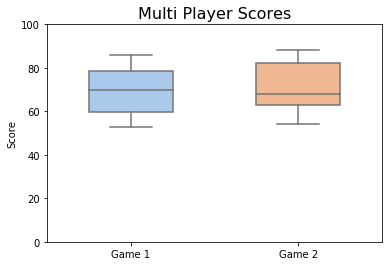

In [336]:
m_scores_box = sns.boxplot( 
                 data=m_scores, 
                 width=0.5,
                 palette="pastel")
m_scores_box.axes.set_title("Multi Player Scores",
                    fontsize=16)

plot_file_name="m_score_box.jpg"
 
plt.ylim(0, 100)
m_scores_box.axes.set(ylabel='Score')

# save as jpeg
m_scores_box.figure.savefig(plot_file_name,
                    format='jpeg',
                    dpi=100)

In [337]:
m_scores_p

Ttest_relResult(statistic=-0.4688088775680356, pvalue=0.6469706054464561)

# Multi combined choices in G1

In [338]:
m_g1_counts = pd.DataFrame([m05_p1_g1_count, m05_p2_g1_count, m06_p1_g1_count, m06_p2_g1_count, m08_p1_g1_count, m08_p2_g1_count, 
              m10_p1_g1_count, m10_p2_g1_count, m11_p1_g1_count, m11_p2_g1_count, m13_p1_g1_count, m13_p2_g1_count, 
              m14_p1_g1_count, m14_p2_g1_count],
                index = ['m05_p1_g1_count', 'm05_p2_g1_count', 'm06_p1_g1_count', 'm06_p2_g1_count',
                 'm08_p1_g1_count', 'm08_p2_g1_count', 'm10_p1_g1_count', 'm10_p2_g1_count', 'm11_p1_g1_count', 
                'm11_p2_g1_count', 'm13_p1_g1_count', 'm13_p2_g1_count', 'm14_p1_g1_count', 'm14_p2_g1_count'])


In [339]:
m_g1_counts = m_g1_counts.fillna(0) 

In [340]:
m_g1_counts

,30,60,90
m05_p1_g1_count,2.0,5.0,13.0
m05_p2_g1_count,2.0,6.0,12.0
m06_p1_g1_count,7.0,6.0,7.0
m06_p2_g1_count,6.0,7.0,7.0
m08_p1_g1_count,2.0,5.0,13.0
m08_p2_g1_count,1.0,2.0,17.0
m10_p1_g1_count,3.0,5.0,12.0
m10_p2_g1_count,7.0,9.0,4.0
m11_p1_g1_count,0.0,0.0,20.0
m11_p2_g1_count,0.0,0.0,20.0


In [341]:
m_g1_counts.sum(axis=1)

m05_p1_g1_count    20.0
m05_p2_g1_count    20.0
m06_p1_g1_count    20.0
m06_p2_g1_count    20.0
m08_p1_g1_count    20.0
m08_p2_g1_count    20.0
m10_p1_g1_count    20.0
m10_p2_g1_count    20.0
m11_p1_g1_count    20.0
m11_p2_g1_count    20.0
m13_p1_g1_count    20.0
m13_p2_g1_count    20.0
m14_p1_g1_count    20.0
m14_p2_g1_count    20.0
dtype: float64

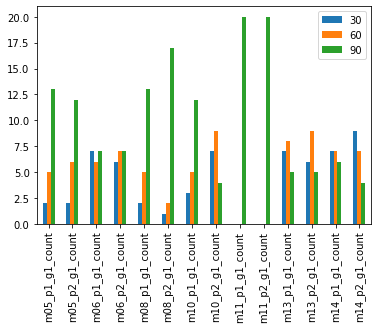

In [342]:
m_g1_counts_bar = m_g1_counts.plot.bar()

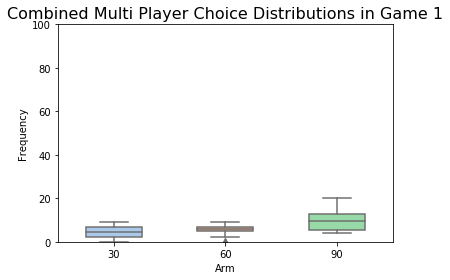

In [343]:
m_g1_counts_box = sns.boxplot( 
                 data = m_g1_counts, 
                 width=0.5,
                 palette="pastel")
m_g1_counts_box.axes.set_title("Combined Multi Player Choice Distributions in Game 1",
                    fontsize=16)

plot_file_name="m_g1_counts_box.jpg"
 
plt.ylim(0, 100)
m_g1_counts_box.axes.set(xlabel='Arm',ylabel='Frequency')

# save as jpeg
m_g1_counts_box.figure.savefig(plot_file_name,
                    format='jpeg',
                    dpi=100)

In [344]:
m_g1_low = np.mean(m_g1_counts.iloc[:,0])
m_g1_med = np.mean(m_g1_counts.iloc[:,1])
m_g1_high = np.mean(m_g1_counts.iloc[:,2])

In [345]:
m_g1_low

4.214285714285714

In [346]:
m_g1_med

5.428571428571429

In [347]:
m_g1_high

10.357142857142858

In [348]:
m_g1_low_std = np.std(m_g1_counts.iloc[:,0])
m_g1_med_std = np.std(m_g1_counts.iloc[:,1])
m_g1_high_std = np.std(m_g1_counts.iloc[:,2])

In [349]:
m_g1_low_std

2.9563145837964107

In [350]:
m_g1_med_std

2.821202522590214

In [351]:
m_g1_high_std

5.536981421795284

# Multi combined choices in G2

In [352]:
m_g2_counts = pd.DataFrame([m05_p1_g2_count, m05_p2_g2_count, m06_p1_g2_count, m06_p2_g2_count, m08_p1_g2_count, m08_p2_g2_count, 
              m10_p1_g2_count, m10_p2_g2_count, m11_p1_g2_count, m11_p2_g2_count, m13_p1_g2_count, m13_p2_g2_count, 
              m14_p1_g2_count, m14_p2_g2_count],
                index = ['m05_p1_g2_count', 'm05_p2_g2_count', 'm06_p1_g2_count', 'm06_p2_g2_count',
                 'm08_p1_g2_count', 'm08_p2_g2_count', 'm10_p1_g2_count', 'm10_p2_g2_count', 'm11_p1_g2_count', 
                'm11_p2_g2_count', 'm13_p1_g2_count', 'm13_p2_g2_count', 'm14_p1_g2_count', 'm14_p2_g2_count'])


In [353]:
m_g2_counts = m_g2_counts.fillna(0) 

In [354]:
m_g2_counts

,30,60,90
m05_p1_g2_count,0.0,13.0,7.0
m05_p2_g2_count,0.0,0.0,20.0
m06_p1_g2_count,4.0,9.0,7.0
m06_p2_g2_count,5.0,7.0,8.0
m08_p1_g2_count,2.0,0.0,18.0
m08_p2_g2_count,0.0,3.0,17.0
m10_p1_g2_count,6.0,5.0,9.0
m10_p2_g2_count,4.0,11.0,5.0
m11_p1_g2_count,0.0,0.0,20.0
m11_p2_g2_count,0.0,0.0,20.0


In [355]:
m_g2_counts.sum(axis=1)

m05_p1_g2_count    20.0
m05_p2_g2_count    20.0
m06_p1_g2_count    20.0
m06_p2_g2_count    20.0
m08_p1_g2_count    20.0
m08_p2_g2_count    20.0
m10_p1_g2_count    20.0
m10_p2_g2_count    20.0
m11_p1_g2_count    20.0
m11_p2_g2_count    20.0
m13_p1_g2_count    20.0
m13_p2_g2_count    20.0
m14_p1_g2_count    20.0
m14_p2_g2_count    20.0
dtype: float64

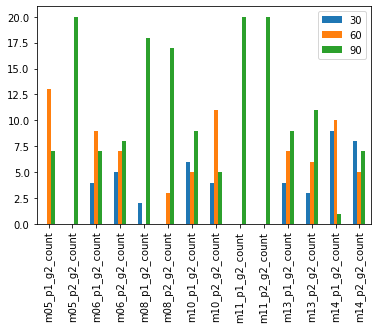

In [356]:
m_g2_counts_bar = m_g2_counts.plot.bar()

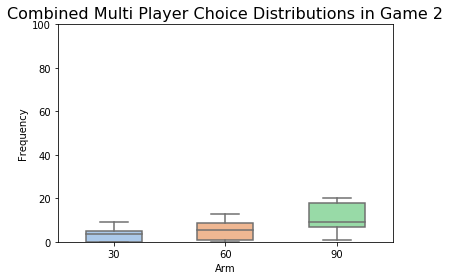

In [357]:
m_g2_counts_box = sns.boxplot( 
                 data = m_g2_counts, 
                 width=0.5,
                 palette="pastel")
m_g2_counts_box.axes.set_title("Combined Multi Player Choice Distributions in Game 2",
                    fontsize=16)

plot_file_name="m_g2_counts_box.jpg"
 
plt.ylim(0, 100)
m_g2_counts_box.axes.set(xlabel='Arm',ylabel='Frequency')

# save as jpeg
m_g2_counts_box.figure.savefig(plot_file_name,
                    format='jpeg',
                    dpi=100)

In [358]:
m_g2_low = np.mean(m_g2_counts.iloc[:,0])
m_g2_med = np.mean(m_g2_counts.iloc[:,1])
m_g2_high = np.mean(m_g2_counts.iloc[:,2])

In [359]:
m_g2_low

3.2142857142857144

In [360]:
m_g2_med

5.428571428571429

In [361]:
m_g2_high

11.357142857142858

In [362]:
m_g2_low_std = np.std(m_g2_counts.iloc[:,0])
m_g2_med_std = np.std(m_g2_counts.iloc[:,1])
m_g2_high_std = np.std(m_g2_counts.iloc[:,2])

In [363]:
m_g2_low_std

2.956314583796411

In [364]:
m_g2_med_std

4.2378277069118075

In [365]:
m_g2_high_std

6.136624745355229

# Multi combined arrays

In [366]:
#pip install researchpy

In [367]:
import researchpy as rp

In [368]:
m_90_1 = np.array(m_g1_counts.iloc[:,2])
m_90_2 = np.array(m_g2_counts.iloc[:,2])

In [369]:
m_90_1

array([13., 12.,  7.,  7., 13., 17., 12.,  4., 20., 20.,  5.,  5.,  6.,
        4.])

In [370]:
m_90_2

array([ 7., 20.,  7.,  8., 18., 17.,  9.,  5., 20., 20.,  9., 11.,  1.,
        7.])

In [371]:
m_60_1 = np.array(m_g1_counts.iloc[:,1])
m_60_2 = np.array(m_g2_counts.iloc[:,1])

In [372]:
m_60_1

array([5., 6., 6., 7., 5., 2., 5., 9., 0., 0., 8., 9., 7., 7.])

In [373]:
m_60_2

array([13.,  0.,  9.,  7.,  0.,  3.,  5., 11.,  0.,  0.,  7.,  6., 10.,
        5.])

In [374]:
m_30_1 = np.array(m_g1_counts.iloc[:,0])
m_30_2 = np.array(m_g2_counts.iloc[:,0])

In [375]:
m_30_1

array([2., 2., 7., 6., 2., 1., 3., 7., 0., 0., 7., 6., 7., 9.])

In [376]:
m_30_2

array([0., 0., 4., 5., 2., 0., 6., 4., 0., 0., 4., 3., 9., 8.])

# Multi combined choice statistics

In [377]:
m_90_p = sp.stats.ttest_rel(m_90_1,m_90_2)
m_60_p = sp.stats.ttest_rel(m_60_1,m_60_2)
m_30_p = sp.stats.ttest_rel(m_30_1,m_30_2)

In [378]:
m_90_p

Ttest_relResult(statistic=-0.9354143466934853, pvalue=0.3666265339953576)

In [379]:
m_60_p

Ttest_relResult(statistic=0.0, pvalue=1.0)

In [380]:
m_30_p

Ttest_relResult(statistic=1.9891007362952826, pvalue=0.06815665747816366)

In [381]:
#maximizing and matching?

# Total social counts (M & J)

In [382]:
social_counts_g1 = pd.DataFrame([j01_p1_g1_count, j01_p2_g1_count, j02_p1_g1_count, j02_p2_g1_count, j03_p1_g1_count, 
              j03_p2_g1_count, j04_p1_g1_count, j04_p2_g1_count, j05_p1_g1_count, j05_p2_g1_count, j06_p1_g1_count, 
              j06_p2_g1_count, j07_p1_g1_count, j07_p2_g1_count, j08_p1_g1_count, j08_p2_g1_count, 
              j10_p1_g1_count, j10_p2_g1_count, j11_p1_g1_count, j11_p2_g1_count, m05_p1_g1_count, m05_p2_g1_count, m06_p1_g1_count, m06_p2_g1_count, m08_p1_g1_count, m08_p2_g1_count, 
              m10_p1_g1_count, m10_p2_g1_count, m11_p1_g1_count, m11_p2_g1_count, m13_p1_g1_count, m13_p2_g1_count, 
              m14_p1_g1_count, m14_p2_g1_count],
                index = ['j01_p1_g1_count', 'j01_p2_g1_count', 'j02_p1_g1_count', 'j02_p2_g1_count', 
                 'j03_p1_g1_count', 'j03_p2_g1_count', 'j04_p1_g1_count', 'j04_p2_g1_count', 'j05_p1_g1_count', 
                  'j05_p2_g1_count', 'j06_p1_g1_count', 'j06_p2_g1_count', 'j07_p1_g1_count', 
                    'j07_p2_g1_count', 'j08_p1_g1_count', 'j08_p2_g1_count', 'j10_p1_g1_count', 'j10_p2_g1_count', 
                    'j11_p1_g1_count', 'j11_p2_g1_count', 'm05_p1_g1_count', 'm05_p2_g1_count', 'm06_p1_g1_count', 'm06_p2_g1_count',
                 'm08_p1_g1_count', 'm08_p2_g1_count', 'm10_p1_g1_count', 'm10_p2_g1_count', 'm11_p1_g1_count', 
                'm11_p2_g1_count', 'm13_p1_g1_count', 'm13_p2_g1_count', 'm14_p1_g1_count', 'm14_p2_g1_count'])

In [383]:
#How to prevent NaN: df = df.fillna(0)
social_counts_g1=social_counts_g1.fillna(0)

In [468]:
social_counts_g1

,30,60,90
j01_p1_g1_count,8.0,9.0,3.0
j01_p2_g1_count,8.0,6.0,6.0
j02_p1_g1_count,5.0,6.0,9.0
j02_p2_g1_count,0.0,11.0,9.0
j03_p1_g1_count,6.0,7.0,7.0
j03_p2_g1_count,8.0,5.0,7.0
j04_p1_g1_count,5.0,8.0,7.0
j04_p2_g1_count,4.0,10.0,6.0
j05_p1_g1_count,1.0,3.0,16.0
j05_p2_g1_count,4.0,4.0,12.0


In [469]:
social_counts_g1.sum(axis=1)

j01_p1_g1_count    20.0
j01_p2_g1_count    20.0
j02_p1_g1_count    20.0
j02_p2_g1_count    20.0
j03_p1_g1_count    20.0
j03_p2_g1_count    20.0
j04_p1_g1_count    20.0
j04_p2_g1_count    20.0
j05_p1_g1_count    20.0
j05_p2_g1_count    20.0
j06_p1_g1_count    20.0
j06_p2_g1_count    20.0
j07_p1_g1_count    20.0
j07_p2_g1_count    20.0
j08_p1_g1_count    20.0
j08_p2_g1_count    20.0
j10_p1_g1_count    20.0
j10_p2_g1_count    20.0
j11_p1_g1_count    20.0
j11_p2_g1_count    20.0
m05_p1_g1_count    20.0
m05_p2_g1_count    20.0
m06_p1_g1_count    20.0
m06_p2_g1_count    20.0
m08_p1_g1_count    20.0
m08_p2_g1_count    20.0
m10_p1_g1_count    20.0
m10_p2_g1_count    20.0
m11_p1_g1_count    20.0
m11_p2_g1_count    20.0
m13_p1_g1_count    20.0
m13_p2_g1_count    20.0
m14_p1_g1_count    20.0
m14_p2_g1_count    20.0
dtype: float64

In [470]:
social_counts_g2 = pd.DataFrame([j01_p1_g2_count, j01_p2_g2_count, j02_p1_g2_count, j02_p2_g2_count, j03_p1_g2_count, 
              j03_p2_g2_count, j04_p1_g2_count, j04_p2_g2_count, j05_p1_g2_count, j05_p2_g2_count, j06_p1_g2_count, 
              j06_p2_g2_count, j07_p1_g2_count, j07_p2_g2_count, j08_p1_g2_count, j08_p2_g2_count, 
              j10_p1_g2_count, j10_p2_g2_count, j11_p1_g2_count, j11_p2_g2_count, m05_p1_g2_count, m05_p2_g2_count, m06_p1_g2_count, m06_p2_g2_count, m08_p1_g2_count, m08_p2_g2_count, 
              m10_p1_g2_count, m10_p2_g2_count, m11_p1_g2_count, m11_p2_g2_count, m13_p1_g2_count, m13_p2_g2_count, 
              m14_p1_g2_count, m14_p2_g2_count],
                index = ['j01_p1_g2_count', 'j01_p2_g2_count', 'j02_p1_g2_count', 'j02_p2_g2_count', 
                 'j03_p1_g2_count', 'j03_p2_g2_count', 'j04_p1_g2_count', 'j04_p2_g2_count', 'j05_p1_g2_count', 
                  'j05_p2_g2_count', 'j06_p1_g2_count', 'j06_p2_g2_count', 'j07_p1_g2_count', 
                    'j07_p2_g2_count', 'j08_p1_g2_count', 'j08_p2_g2_count', 'j10_p1_g2_count', 'j10_p2_g2_count', 
                    'j11_p1_g2_count', 'j11_p2_g2_count', 'm05_p1_g2_count', 'm05_p2_g2_count', 'm06_p1_g2_count', 'm06_p2_g2_count',
                 'm08_p1_g2_count', 'm08_p2_g2_count', 'm10_p1_g2_count', 'm10_p2_g2_count', 'm11_p1_g2_count', 
                'm11_p2_g2_count', 'm13_p1_g2_count', 'm13_p2_g2_count', 'm14_p1_g2_count', 'm14_p2_g2_count'])

In [471]:
#How to prevent NaN: df = df.fillna(0)
social_counts_g2=social_counts_g2.fillna(0)
social_counts_g2

,30,60,90
j01_p1_g2_count,3.0,6.0,11.0
j01_p2_g2_count,4.0,7.0,9.0
j02_p1_g2_count,7.0,5.0,8.0
j02_p2_g2_count,1.0,7.0,12.0
j03_p1_g2_count,0.0,11.0,9.0
j03_p2_g2_count,0.0,0.0,20.0
j04_p1_g2_count,9.0,6.0,5.0
j04_p2_g2_count,8.0,9.0,3.0
j05_p1_g2_count,3.0,1.0,16.0
j05_p2_g2_count,0.0,9.0,11.0


In [472]:
social_counts_g2.sum(axis=1)

j01_p1_g2_count    20.0
j01_p2_g2_count    20.0
j02_p1_g2_count    20.0
j02_p2_g2_count    20.0
j03_p1_g2_count    20.0
j03_p2_g2_count    20.0
j04_p1_g2_count    20.0
j04_p2_g2_count    20.0
j05_p1_g2_count    20.0
j05_p2_g2_count    20.0
j06_p1_g2_count    20.0
j06_p2_g2_count    20.0
j07_p1_g2_count    20.0
j07_p2_g2_count    20.0
j08_p1_g2_count    20.0
j08_p2_g2_count    20.0
j10_p1_g2_count    20.0
j10_p2_g2_count    20.0
j11_p1_g2_count    20.0
j11_p2_g2_count    20.0
m05_p1_g2_count    20.0
m05_p2_g2_count    20.0
m06_p1_g2_count    20.0
m06_p2_g2_count    20.0
m08_p1_g2_count    20.0
m08_p2_g2_count    20.0
m10_p1_g2_count    20.0
m10_p2_g2_count    20.0
m11_p1_g2_count    20.0
m11_p2_g2_count    20.0
m13_p1_g2_count    20.0
m13_p2_g2_count    20.0
m14_p1_g2_count    20.0
m14_p2_g2_count    20.0
dtype: float64

# Maximizing/Matching SOCIAL

In [473]:
from scipy import stats

In [474]:
#Optional: Idealized probability distributions to use for comparison. These assume a social strategy in which the probability
#distributions of both partners in a joint session are averaged (all holes reward at a 60% rate)

#social_max = [0, 0, 100]
#social_match = [30/180 * 100,60/180 * 100, 90/180 * 100]


In [475]:
#Calls jsd with the social distributions.
#def call_jsd_social(counts):
   # maxi = jsd(counts,social_max)
   # matchi = jsd(counts,social_match)
    #return maxi,matchi

In [476]:
j01_p1_g1_max,j01_p1_g1_match,j01_p1_g1_rand,j01_p1_g1_soc = call_jsd(j01_p1_g1_count)
j01_p1_g2_max,j01_p1_g2_match,j01_p1_g2_rand,j01_p1_g2_soc = call_jsd(j01_p1_g2_count)
j01_p2_g1_max,j01_p2_g1_match,j01_p2_g1_rand,j01_p2_g1_soc = call_jsd(j01_p2_g1_count)
j01_p2_g2_max,j01_p2_g2_match,j01_p2_g2_rand,j01_p2_g2_soc = call_jsd(j01_p2_g2_count)
j02_p1_g1_max,j02_p1_g1_match,j02_p1_g1_rand,j02_p1_g1_soc = call_jsd(j02_p1_g1_count)
j02_p1_g2_max,j02_p1_g2_match,j02_p1_g2_rand,j02_p1_g2_soc = call_jsd(j02_p1_g2_count)
j02_p2_g1_max,j02_p2_g1_match,j02_p2_g1_rand,j02_p2_g1_soc = call_jsd([0,11,9])
j02_p2_g2_max,j02_p2_g2_match,j02_p2_g2_rand,j02_p2_g2_soc = call_jsd(j02_p2_g2_count)
j03_p1_g1_max,j03_p1_g1_match,j03_p1_g1_rand,j03_p1_g1_soc = call_jsd(j03_p1_g1_count)
j03_p1_g2_max,j03_p1_g2_match,j03_p1_g2_rand,j03_p1_g2_soc = call_jsd([0,11,9])
j03_p2_g1_max,j03_p2_g1_match,j03_p2_g1_rand,j03_p2_g1_soc  = call_jsd(j03_p2_g1_count)
j03_p2_g2_max,j03_p2_g2_match,j03_p2_g2_rand,j03_p2_g2_soc = call_jsd([0,0,20])
j04_p1_g1_max,j04_p1_g1_match,j04_p1_g1_rand,j04_p1_g1_soc = call_jsd(j04_p1_g1_count)
j04_p1_g2_max,j04_p1_g2_match,j04_p1_g2_rand,j04_p1_g2_soc = call_jsd(j04_p1_g2_count)
j04_p2_g1_max,j04_p2_g1_match,j04_p2_g1_rand,j04_p2_g1_soc  = call_jsd(j04_p2_g1_count)
j04_p2_g2_max,j04_p2_g2_match,j04_p2_g2_rand,j04_p2_g2_soc = call_jsd(j04_p2_g2_count)
j05_p1_g1_max,j05_p1_g1_match,j05_p1_g1_rand,j05_p1_g1_soc = call_jsd(j05_p1_g1_count)
j05_p1_g2_max,j05_p1_g2_match,j05_p1_g2_rand,j05_p1_g2_soc = call_jsd(j05_p1_g2_count)
j05_p2_g1_max,j05_p2_g1_match,j05_p2_g1_rand,j05_p2_g1_soc = call_jsd(j05_p2_g1_count)
j05_p2_g2_max,j05_p2_g2_match,j05_p2_g2_rand,j05_p2_g2_soc = call_jsd([0,9,11])
j06_p1_g1_max,j06_p1_g1_match,j06_p1_g1_rand,j06_p1_g1_soc = call_jsd(j06_p1_g1_count)
j06_p1_g2_max,j06_p1_g2_match,j06_p1_g2_rand,j06_p1_g2_soc = call_jsd(j06_p1_g2_count)
j06_p2_g1_max,j06_p2_g1_match,j06_p2_g1_rand,j06_p2_g1_soc = call_jsd(j06_p2_g1_count)
j06_p2_g2_max,j06_p2_g2_match,j06_p2_g2_rand,j06_p2_g2_soc = call_jsd(j06_p2_g2_count)
j07_p1_g1_max,j07_p1_g1_match,j07_p1_g1_rand,j07_p1_g1_soc = call_jsd([0,6,14])
j07_p1_g2_max,j07_p1_g2_match,j07_p1_g2_rand,j07_p1_g2_soc = call_jsd([0,0,20])
j07_p2_g1_max,j07_p2_g1_match,j07_p2_g1_rand,j07_p2_g1_soc = call_jsd(j07_p2_g1_count)
j07_p2_g2_max,j07_p2_g2_match,j07_p2_g2_rand,j07_p2_g2_soc = call_jsd(j07_p2_g2_count)
j08_p1_g1_max,j08_p1_g1_match,j08_p1_g1_rand,j08_p1_g1_soc = call_jsd(j08_p1_g1_count)
j08_p1_g2_max,j08_p1_g2_match,j08_p1_g2_rand,j08_p1_g2_soc = call_jsd([0,0,20])
j08_p2_g1_max,j08_p2_g1_match,j08_p2_g1_rand,j08_p2_g1_soc = call_jsd(j08_p2_g1_count)
j08_p2_g2_max,j08_p2_g2_match,j08_p2_g2_rand,j08_p2_g2_soc = call_jsd(j08_p2_g2_count)
j10_p1_g1_max,j10_p1_g1_match,j10_p1_g1_rand,j10_p1_g1_soc = call_jsd(j10_p1_g1_count)
j10_p1_g2_max,j10_p1_g2_match,j10_p1_g2_rand,j10_p1_g2_soc = call_jsd(j10_p1_g2_count)
j10_p2_g1_max,j10_p2_g1_match,j10_p2_g1_rand,j10_p2_g1_soc = call_jsd(j10_p2_g1_count)
j10_p2_g2_max,j10_p2_g2_match,j10_p2_g2_rand,j10_p2_g2_soc = call_jsd([0,0,20])
j11_p1_g1_max,j11_p1_g1_match,j11_p1_g1_rand,j11_p1_g1_soc = call_jsd([0,9,11])
j11_p1_g2_max,j11_p1_g2_match,j11_p1_g2_rand,j11_p1_g2_soc = call_jsd([0,4,16])
j11_p2_g1_max,j11_p2_g1_match,j11_p2_g1_rand,j11_p2_g1_soc = call_jsd(j11_p2_g1_count)
j11_p2_g2_max,j11_p2_g2_match,j11_p2_g2_rand,j11_p2_g2_soc = call_jsd([0,0,20])
m05_p1_g1_max,m05_p1_g1_match,m05_p1_g1_rand,m05_p1_g1_soc = call_jsd(m05_p1_g1_count)
m05_p1_g2_max,m05_p1_g2_match,m05_p1_g2_rand,m05_p1_g2_soc = call_jsd([0,13,7])
m05_p2_g1_max,m05_p2_g1_match,m05_p2_g1_rand,m05_p2_g1_soc = call_jsd(m05_p2_g1_count)
m05_p2_g2_max,m05_p2_g2_match,m05_p2_g2_rand,m05_p2_g2_soc = call_jsd([0,0,20])
m06_p1_g1_max,m06_p1_g1_match,m06_p1_g1_rand,m06_p1_g1_soc = call_jsd(m06_p1_g1_count)
m06_p1_g2_max,m06_p1_g2_match,m06_p1_g2_rand,m06_p1_g2_soc = call_jsd(m06_p1_g2_count)
m06_p2_g1_max,m06_p2_g1_match,m06_p2_g1_rand,m06_p2_g1_soc = call_jsd(m06_p2_g1_count)
m06_p2_g2_max,m06_p2_g2_match,m06_p2_g2_rand,m06_p2_g2_soc = call_jsd(m06_p2_g2_count)
m08_p1_g1_max,m08_p1_g1_match,m08_p1_g1_rand,m08_p1_g1_soc = call_jsd(m08_p1_g1_count)
m08_p1_g2_max,m08_p1_g2_match,m08_p1_g2_rand,m08_p1_g2_soc = call_jsd([2,0,18])
m08_p2_g1_max,m08_p2_g1_match,m08_p2_g1_rand,m08_p2_g1_soc = call_jsd(m08_p2_g1_count)
m08_p2_g2_max,m08_p2_g2_match,m08_p2_g2_rand,m08_p2_g2_soc = call_jsd([0,3,17])
m10_p1_g1_max,m10_p1_g1_match,m10_p1_g1_rand,m10_p1_g1_soc = call_jsd(m10_p1_g1_count)
m10_p1_g2_max,m10_p1_g2_match,m10_p1_g2_rand,m10_p1_g2_soc = call_jsd(m10_p1_g2_count)
m10_p2_g1_max,m10_p2_g1_match,m10_p2_g1_rand,m10_p2_g1_soc = call_jsd(m10_p2_g1_count)
m10_p2_g2_max,m10_p2_g2_match,m10_p2_g2_rand,m10_p2_g2_soc = call_jsd(m10_p2_g2_count)
m11_p1_g1_max,m11_p1_g1_match,m11_p1_g1_rand,m11_p1_g1_soc = call_jsd([0,0,20])
m11_p1_g2_max,m11_p1_g2_match,m11_p1_g2_rand,m11_p1_g2_soc = call_jsd([0,0,20])
m11_p2_g1_max,m11_p2_g1_match,m11_p2_g1_rand,m11_p2_g1_soc = call_jsd([0,0,20])
m11_p2_g2_max,m11_p2_g2_match,m11_p2_g2_rand,m11_p2_g2_soc = call_jsd([0,0,20])
m13_p1_g1_max,m13_p1_g1_match,m13_p1_g1_rand,m13_p1_g1_soc = call_jsd(m13_p1_g1_count)
m13_p1_g2_max,m13_p1_g2_match,m13_p1_g2_rand,m13_p1_g2_soc = call_jsd(m13_p1_g2_count)
m13_p2_g1_max,m13_p2_g1_match,m13_p2_g1_rand,m13_p2_g1_soc = call_jsd(m13_p2_g1_count)
m13_p2_g2_max,m13_p2_g2_match,m13_p2_g2_rand,m13_p2_g2_soc = call_jsd(m13_p2_g2_count)
m14_p1_g1_max,m14_p1_g1_match,m14_p1_g1_rand,m14_p1_g1_soc = call_jsd(m14_p1_g1_count)
m14_p1_g2_max,m14_p1_g2_match,m14_p1_g2_rand,m14_p1_g2_soc = call_jsd(m14_p1_g2_count)
m14_p2_g1_max,m14_p2_g1_match,m14_p2_g1_rand,m14_p2_g1_soc = call_jsd(m14_p2_g1_count)
m14_p2_g2_max,m14_p2_g2_match,m14_p2_g2_rand,m14_p2_g2_soc = call_jsd(m14_p2_g2_count)

In [477]:
#Create a dataframe for single player game 1 jsd scores, with a column for each strategy.'''
social_jsd_g1 = pd.DataFrame({'max':[j01_p1_g1_max,j01_p2_g1_max,j02_p1_g1_max,j02_p2_g1_max,j03_p1_g1_max,j03_p2_g1_max,
                             j04_p1_g1_max,j04_p2_g1_max,j05_p1_g1_max,j05_p2_g1_max,j06_p1_g1_max,j06_p2_g1_max,
                             j07_p1_g1_max,j07_p2_g1_max,j08_p1_g1_max,j08_p2_g1_max, j10_p1_g1_max, j10_p2_g1_max,
                               j11_p1_g1_max, j11_p2_g1_max, m05_p1_g1_max, m05_p2_g1_max, m06_p1_g1_max, m06_p2_g1_max,
                                   m08_p1_g1_max, m08_p2_g1_max, m10_p1_g1_max, m10_p2_g1_max, m11_p1_g1_max, m11_p2_g1_max,
                                    m13_p1_g1_max, m13_p2_g1_max, m14_p1_g1_max, m14_p2_g1_max],
                    'match':[j01_p1_g1_match,j01_p2_g1_match,j02_p1_g1_match, j02_p2_g1_match,j03_p1_g1_match,j03_p2_g1_match,
                               j04_p1_g1_match,j04_p2_g1_match,j05_p1_g1_match,
                               j05_p2_g1_match,j06_p1_g1_match,j06_p2_g1_match,
                               j07_p1_g1_match,j07_p2_g1_match,j08_p1_g1_match,j08_p2_g1_match, j10_p1_g1_match,
                               j10_p2_g1_match, j11_p1_g1_match, j11_p2_g1_match, m05_p1_g1_match, m05_p2_g1_match,
                               m06_p1_g1_match, m06_p2_g1_match, m08_p1_g1_match, m08_p2_g1_match, m10_p1_g1_match,
                               m10_p2_g1_match, m11_p1_g1_match, m11_p2_g1_match, m13_p1_g1_match, m13_p2_g1_match,
                               m14_p1_g1_match, m14_p2_g1_match],
                    'rand':[j01_p1_g1_rand,j01_p2_g1_rand,j02_p1_g1_rand,j02_p2_g1_rand,j03_p1_g1_rand,j03_p2_g1_rand,
                             j04_p1_g1_rand,j04_p2_g1_rand,j05_p1_g1_rand,j05_p2_g1_rand,j06_p1_g1_rand,j06_p2_g1_rand,
                             j07_p1_g1_rand,j07_p2_g1_rand,j08_p1_g1_rand,j08_p2_g1_rand, j10_p1_g1_rand, j10_p2_g1_rand,
                               j11_p1_g1_rand, j11_p2_g1_rand, m05_p1_g1_rand, m05_p2_g1_rand, m06_p1_g1_rand, m06_p2_g1_rand,
                                   m08_p1_g1_rand, m08_p2_g1_rand, m10_p1_g1_rand, m10_p2_g1_rand, m11_p1_g1_rand, m11_p2_g1_rand,
                                    m13_p1_g1_rand, m13_p2_g1_rand, m14_p1_g1_rand, m14_p2_g1_rand],
                    'soc':[j01_p1_g1_soc,j01_p2_g1_soc,j02_p1_g1_soc, j02_p2_g1_soc,j03_p1_g1_soc,j03_p2_g1_soc,
                               j04_p1_g1_soc,j04_p2_g1_soc,j05_p1_g1_soc,
                               j05_p2_g1_soc,j06_p1_g1_soc,j06_p2_g1_soc,
                               j07_p1_g1_soc,j07_p2_g1_soc,j08_p1_g1_soc,j08_p2_g1_soc, j10_p1_g1_soc,
                               j10_p2_g1_soc, j11_p1_g1_soc, j11_p2_g1_soc, m05_p1_g1_soc, m05_p2_g1_soc,
                               m06_p1_g1_soc, m06_p2_g1_soc, m08_p1_g1_soc, m08_p2_g1_soc, m10_p1_g1_soc,
                               m10_p2_g1_soc, m11_p1_g1_soc, m11_p2_g1_soc, m13_p1_g1_soc, m13_p2_g1_soc,
                               m14_p1_g1_soc, m14_p2_g1_soc]},
                         index=['j01', 'j01', 'j02', 'j02', 'j03', 'j03','j04',
                                'j04','j05', 'j05', 'j06', 'j06','j07','j07','j08','j08', 'j10', 'j10', 'j11', 'j11','m05','m05','m06', 'm06', 'm08', 'm08', 'm10', 'm10', 'm11', 'm11', 'm13','m13', 'm14', 'm14'])

In [478]:
#to print wothout truncation
pd.set_option('display.max_rows', None)

In [479]:
social_jsd_g1

,max,match,rand,soc
j01,0.274358,0.007363,0.023705,0.244099
j01,0.274358,0.012880,0.002395,0.342014
j02,0.380396,0.055476,0.007785,0.342014
j02,0.244099,0.071843,0.133307,0.189094
j03,0.342014,0.029358,0.000642,0.306858
j03,0.274358,0.022393,0.004605,0.380396
j04,0.380396,0.039378,0.004605,0.274358
j04,0.422810,0.051255,0.017251,0.215762
j05,0.592639,0.237505,0.125964,0.470500
j05,0.422810,0.106628,0.036160,0.422810


In [480]:
# get the column name of min values in every row
strategy_social_jsd_g1 = social_jsd_g1.idxmin(axis=1)
 
print("min values of row are at following columns :")
print(strategy_social_jsd_g1)


min values of row are at following columns :
j01    match
j01     rand
j02     rand
j02    match
j03     rand
j03     rand
j04     rand
j04     rand
j05     rand
j05     rand
j06     rand
j06     rand
j07    match
j07     rand
j08    match
j08    match
j10     rand
j10     rand
j11    match
j11     rand
m05     rand
m05     rand
m06     rand
m06     rand
m08     rand
m08     rand
m10     rand
m10    match
m11      max
m11      max
m13     rand
m13     rand
m14     rand
m14    match
dtype: object


In [481]:
strategy_social_jsd_g1.value_counts()

rand     24
match     8
max       2
dtype: int64

In [482]:
#social_types_g1 = check_type(social_jsd_g1)

In [483]:
#social_types_g1.drop([0])

In [484]:
#(social_types_g1 == 'maxi').sum()

In [485]:
#Create a dataframe for single player game 1 jsd scores, with a column for each strategy.'''
social_jsd_g2 = pd.DataFrame({'max':[j01_p1_g2_max,j01_p2_g2_max,j02_p1_g2_max,j02_p2_g2_max,j03_p1_g2_max,j03_p2_g2_max,
                             j04_p1_g2_max,j04_p2_g2_max,j05_p1_g2_max,j05_p2_g2_max,j06_p1_g2_max,j06_p2_g2_max,
                             j07_p1_g2_max,j07_p2_g2_max,j08_p1_g2_max,j08_p2_g2_max, j10_p1_g2_max, j10_p2_g2_max,
                               j11_p1_g2_max, j11_p2_g2_max, m05_p1_g2_max, m05_p2_g2_max, m06_p1_g2_max, m06_p2_g2_max,
                                   m08_p1_g2_max, m08_p2_g2_max, m10_p1_g2_max, m10_p2_g2_max, m11_p1_g2_max, m11_p2_g2_max,
                                    m13_p1_g2_max, m13_p2_g2_max, m14_p1_g2_max, m14_p2_g2_max],
                    'match':[j01_p1_g2_match,j01_p2_g2_match,j02_p1_g2_match, j02_p2_g2_match,j03_p1_g2_match,j03_p2_g2_match,
                               j04_p1_g2_match,j04_p2_g2_match,j05_p1_g2_match,
                               j05_p2_g2_match,j06_p1_g2_match,j06_p2_g2_match,
                               j07_p1_g2_match,j07_p2_g2_match,j08_p1_g2_match,j08_p2_g2_match, j10_p1_g2_match,
                               j10_p2_g2_match, j11_p1_g2_match, j11_p2_g2_match, m05_p1_g2_match, m05_p2_g2_match,
                               m06_p1_g2_match, m06_p2_g2_match, m08_p1_g2_match, m08_p2_g2_match, m10_p1_g2_match,
                               m10_p2_g2_match, m11_p1_g2_match, m11_p2_g2_match, m13_p1_g2_match, m13_p2_g2_match,
                               m14_p1_g2_match, m14_p2_g2_match],
                    'rand':[j01_p1_g2_rand,j01_p2_g2_rand,j02_p1_g2_rand,j02_p2_g2_rand,j03_p1_g2_rand,j03_p2_g2_rand,
                             j04_p1_g2_rand,j04_p2_g2_rand,j05_p1_g2_rand,j05_p2_g2_rand,j06_p1_g2_rand,j06_p2_g2_rand,
                             j07_p1_g2_rand,j07_p2_g2_rand,j08_p1_g2_rand,j08_p2_g2_rand, j10_p1_g2_rand, j10_p2_g2_rand,
                               j11_p1_g2_rand, j11_p2_g2_rand, m05_p1_g2_rand, m05_p2_g2_rand, m06_p1_g2_rand, m06_p2_g2_rand,
                                   m08_p1_g2_rand, m08_p2_g2_rand, m10_p1_g2_rand, m10_p2_g2_rand, m11_p1_g2_rand, m11_p2_g2_rand,
                                    m13_p1_g2_rand, m13_p2_g2_rand, m14_p1_g2_rand, m14_p2_g2_rand],
                    'soc':[j01_p1_g2_soc,j01_p2_g2_soc,j02_p1_g2_soc, j02_p2_g2_soc,j03_p1_g2_soc,j03_p2_g2_soc,
                               j04_p1_g2_soc,j04_p2_g2_soc,j05_p1_g2_soc,
                               j05_p2_g2_soc,j06_p1_g2_soc,j06_p2_g2_soc,
                               j07_p1_g2_soc,j07_p2_g2_soc,j08_p1_g2_soc,j08_p2_g2_soc, j10_p1_g2_soc,
                               j10_p2_g2_soc, j11_p1_g2_soc, j11_p2_g2_soc, m05_p1_g2_soc, m05_p2_g2_soc,
                               m06_p1_g2_soc, m06_p2_g2_soc, m08_p1_g2_soc, m08_p2_g2_soc, m10_p1_g2_soc,
                               m10_p2_g2_soc, m11_p1_g2_soc, m11_p2_g2_soc, m13_p1_g2_soc, m13_p2_g2_soc,
                               m14_p1_g2_soc, m14_p2_g2_soc]},
                         index=['j01', 'j01', 'j02', 'j02', 'j03', 'j03','j04',
                                'j04','j05', 'j05', 'j06', 'j06','j07','j07','j08','j08', 'j10', 'j10', 'j11', 'j11','m05','m05','m06', 'm06', 'm08', 'm08', 'm10', 'm10', 'm11', 'm11', 'm13','m13', 'm14', 'm14'])

In [486]:
social_jsd_g2

,max,match,rand,soc
j01,0.470500,0.104181,0.031689,0.342014
j01,0.422810,0.067108,0.012884,0.306858
j02,0.306858,0.034388,0.004605,0.380396
j02,0.592639,0.171941,0.078055,0.306858
j03,0.244099,0.071843,0.133307,0.189094
j03,0.000000,0.215762,0.318257,0.693147
j04,0.244099,0.005292,0.007785,0.342014
j04,0.274358,0.007363,0.023705,0.244099
j05,0.470500,0.221180,0.125964,0.592639
j05,0.189094,0.062718,0.133307,0.244099


In [487]:
# get the column name of min values in every row
strategy_social_jsd_g2 = social_jsd_g2.idxmin(axis=1)
 
print("min values of row are at following columns :")
print(strategy_social_jsd_g2)


min values of row are at following columns :
j01     rand
j01     rand
j02     rand
j02     rand
j03    match
j03      max
j04    match
j04    match
j05     rand
j05    match
j06     rand
j06     rand
j07      max
j07     rand
j08      max
j08     rand
j10     rand
j10      max
j11      max
j11      max
m05    match
m05      max
m06     rand
m06     rand
m08      max
m08      max
m10     rand
m10     rand
m11      max
m11      max
m13     rand
m13     rand
m14    match
m14     rand
dtype: object


In [488]:
strategy_social_jsd_g2.value_counts()

rand     17
max      11
match     6
dtype: int64

In [489]:
social_jsd_g1.mean()

max      0.353124
match    0.085742
rand     0.061511
soc      0.352392
dtype: float64

In [465]:
social_jsd_g2.mean()

max      0.224600
match    0.108204
rand     0.133786
soc      0.428105
dtype: float64

# Social strategy stats 

# Max strategy

In [466]:
social_max_g1 = social_jsd_g1.loc[ : , 'max' ]

In [467]:
social_max_g1

j01    0.274358
j01    0.306858
j02    0.306858
j02    0.244099
j03    0.306858
j03    0.342014
j04    0.306858
j04    0.215762
j05    0.074882
j05    0.470500
j06    0.244099
j06    0.140003
j07    0.215762
j07    0.470500
j08    0.380396
j08    0.163897
j10    0.306858
j10    0.055030
j11    0.167544
j11    0.055030
m05    0.095603
m05    0.095603
m06    0.342014
m06    0.342014
m08    0.470500
m08    0.244099
m10    0.380396
m10    0.306858
m11    0.021885
m11    0.000000
m13    0.306858
m13    0.306858
m14    0.422810
m14    0.306858
Name: max, dtype: float64

In [468]:
social_max_g2 = social_jsd_g2.loc[ : , 'max' ]

In [469]:
social_max_g2

j01    0.470500
j01    0.380396
j02    0.342014
j02    0.380396
j03    0.244099
j03    0.000000
j04    0.306858
j04    0.244099
j05    0.380396
j05    0.189094
j06    0.525597
j06    0.244099
j07    0.000000
j07    0.525597
j08    0.000000
j08    0.000000
j10    0.380396
j10    0.000000
j11    0.078903
j11    0.003478
m05    0.693147
m05    0.017649
m06    0.244099
m06    0.306858
m08    0.035974
m08    0.013176
m10    0.306858
m10    0.095603
m11    0.008743
m11    0.000000
m13    0.380396
m13    0.306858
m14    0.189094
m14    0.342014
Name: max, dtype: float64

In [470]:
social_max_g1_mean = social_max_g1.mean()

In [471]:
social_max_g1_mean

0.2556035190189714

In [472]:
social_max_g1_std = social_max_g1.std()

In [473]:
social_max_g1_std

0.13043274013073972

In [474]:
social_max_g2_mean = social_max_g2.mean()

In [475]:
social_max_g2_mean

0.22459978735134548

In [476]:
social_max_g2_std = social_max_g2.std()

Max T-Test 

In [477]:
social_max_p = sp.stats.ttest_rel(social_max_g1,social_max_g2)

In [478]:
social_max_p

Ttest_relResult(statistic=0.8830759396682902, pvalue=0.3835833218013617)

# Match strategy

In [479]:
social_match_g1 = social_jsd_g1.loc[ : , 'match' ]

In [480]:
social_match_g1

j01    0.012880
j01    0.012365
j02    0.012365
j02    0.071843
j03    0.023714
j03    0.049419
j04    0.012365
j04    0.092437
j05    0.083649
j05    0.104181
j06    0.002395
j06    0.042238
j07    0.066152
j07    0.183223
j08    0.039378
j08    0.045071
j10    0.023714
j10    0.098537
j11    0.061581
j11    0.098537
m05    0.073333
m05    0.073333
m06    0.029358
m06    0.037821
m08    0.093412
m08    0.071843
m10    0.055476
m10    0.011771
m11    0.161967
m11    0.215762
m13    0.011771
m13    0.012365
m14    0.067108
m14    0.023714
Name: match, dtype: float64

In [481]:
social_match_g2 = social_jsd_g2.loc[ : , 'match' ]

In [482]:
social_match_g2

j01    0.104181
j01    0.046088
j02    0.037821
j02    0.035255
j03    0.071843
j03    0.215762
j04    0.016412
j04    0.013302
j05    0.104064
j05    0.062718
j06    0.110935
j06    0.071843
j07    0.215762
j07    0.110935
j08    0.215762
j08    0.215762
j10    0.039378
j10    0.215762
j11    0.081290
j11    0.195190
m05    0.318257
m05    0.167590
m06    0.025704
m06    0.034388
m08    0.119873
m08    0.162751
m10    0.023714
m10    0.132304
m11    0.175547
m11    0.215762
m13    0.046088
m13    0.034388
m14    0.018682
m14    0.023809
Name: match, dtype: float64

In [483]:
social_match_g1_mean = social_match_g1.mean()

In [484]:
social_match_g1_mean

0.06103176427727892

In [485]:
social_match_g1_std = social_match_g1.std()

In [486]:
social_match_g1_std

0.05043073437518562

In [487]:
social_match_g2_mean = social_match_g2.mean()

In [488]:
social_match_g2_mean

0.10820357855783694

In [489]:
social_match_g2_std = social_match_g2.std()

In [490]:
social_match_g2_std

0.08136731368930877

In [491]:
social_match_p = sp.stats.ttest_rel(social_match_g1,social_match_g2)

In [492]:
social_match_p

Ttest_relResult(statistic=-3.5688081890877834, pvalue=0.0011227991885469778)

# Random strategy

In [493]:
social_rand_g1 = social_jsd_g1.loc[ : , 'rand' ]

In [494]:
social_rand_g1

j01    0.002395
j01    0.004605
j02    0.004605
j02    0.133307
j03    0.000642
j03    0.007785
j04    0.004605
j04    0.071387
j05    0.173445
j05    0.031689
j06    0.023705
j06    0.062078
j07    0.132304
j07    0.092081
j08    0.004605
j08    0.052892
j10    0.000642
j10    0.191694
j11    0.135773
j11    0.191694
m05    0.159626
m05    0.159626
m06    0.000642
m06    0.002395
m08    0.026319
m08    0.133307
m10    0.007785
m10    0.012884
m11    0.241774
m11    0.318257
m13    0.012884
m13    0.004605
m14    0.012884
m14    0.000642
Name: rand, dtype: float64

In [495]:
social_rand_g2 = social_jsd_g2.loc[ : , 'rand' ]

In [496]:
social_rand_g2

j01    0.031689
j01    0.004605
j02    0.002395
j02    0.007785
j03    0.133307
j03    0.318257
j04    0.000642
j04    0.007785
j05    0.040130
j05    0.133307
j06    0.041858
j06    0.133307
j07    0.318257
j07    0.041858
j08    0.318257
j08    0.318257
j10    0.004605
j10    0.318257
j11    0.170405
j11    0.297095
m05    0.318257
m05    0.251394
m06    0.012884
m06    0.004605
m08    0.216261
m08    0.263009
m10    0.000642
m10    0.159626
m11    0.276557
m11    0.318257
m13    0.004605
m13    0.004605
m14    0.073577
m14    0.002395
Name: rand, dtype: float64

In [497]:
social_rand_g1_mean = social_rand_g1.mean()

In [498]:
social_rand_g1_mean

0.07104612047647384

In [499]:
social_rand_g1_std = social_rand_g1.std()

In [500]:
social_rand_g1_std

0.08481110286416464

In [501]:
social_rand_g2_mean = social_rand_g2.mean()

In [502]:
social_rand_g2_mean

0.13378638608965676

In [503]:
social_rand_g2_std = social_rand_g2.std()

In [504]:
social_rand_g2_std

0.1307453651984941

In [505]:
social_rand_p = sp.stats.ttest_rel(social_rand_g1,social_rand_g2)

In [506]:
social_rand_p

Ttest_relResult(statistic=-3.40128302382355, pvalue=0.0017719254392105181)

# Social strategy

In [507]:
social_soc_g1 = social_jsd_g1.loc[ : , 'soc' ]

In [508]:
social_soc_g1

j01    0.342014
j01    0.274358
j02    0.274358
j02    0.189094
j03    0.342014
j03    0.380396
j04    0.274358
j04    0.592639
j05    0.422810
j05    0.342014
j06    0.274358
j06    0.525597
j07    0.215762
j07    0.525597
j08    0.274358
j08    0.525597
j10    0.342014
j10    0.470500
j11    0.269743
j11    0.470500
m05    0.380396
m05    0.380396
m06    0.306858
m06    0.342014
m08    0.306858
m08    0.189094
m10    0.342014
m10    0.244099
m11    0.693147
m11    0.693147
m13    0.244099
m13    0.274358
m14    0.306858
m14    0.342014
Name: soc, dtype: float64

In [509]:
social_soc_g2 = social_jsd_g2.loc[ : , 'soc' ]

In [510]:
social_soc_g2

j01    0.342014
j01    0.306858
j02    0.342014
j02    0.244099
j03    0.189094
j03    0.693147
j04    0.306858
j04    0.380396
j05    0.470500
j05    0.244099
j06    0.244099
j06    0.189094
j07    0.693147
j07    0.244099
j08    0.693147
j08    0.693147
j10    0.274358
j10    0.693147
j11    0.414062
j11    0.665096
m05    0.000000
m05    0.693147
m06    0.422810
m06    0.380396
m08    0.525597
m08    0.612486
m10    0.342014
m10    0.693147
m11    0.634381
m11    0.693147
m13    0.306858
m13    0.380396
m14    0.274358
m14    0.274358
Name: soc, dtype: float64

In [511]:
social_soc_g1_mean = social_soc_g1.mean()

In [512]:
social_soc_g1_mean

0.36392471728775505

In [513]:
social_soc_g1_std = social_soc_g1.std()

In [514]:
social_soc_g1_std

0.12985192608740503

In [515]:
social_soc_g2_mean = social_soc_g2.mean()

In [516]:
social_soc_g2_mean

0.4281051809274363

In [517]:
social_soc_g2_std = social_soc_g2.std()

In [518]:
social_soc_g2_std

0.19719668534590165

In [519]:
social_soc_p = sp.stats.ttest_rel(social_soc_g1,social_soc_g2)

In [520]:
social_soc_p

Ttest_relResult(statistic=-1.7577632167936166, pvalue=0.08806167244122598)

# End of SMAB3 analysis

In [419]:
#hypothesis: scores lower for same gender pairs: male-male
'''here i compared scores of pairs of mixed gender and same gender pairs. there are a lot of different types of analyses you can
do on the choice data, and you can group the data by demographics, questionnaire responses, etc.'''

'here i compared scores of pairs of mixed gender and same gender pairs. there are a lot of different types of analyses you can\ndo on the choice data, and you can group the data by demographics, questionnaire responses, etc.'

In [420]:
scores_f = pd.DataFrame([j03_p1_g1_score,j03_p1_g2_score,j03_p2_g1_score,j03_p2_g2_score,j04_p1_g1_score,
            j04_p1_g2_score,j04_p2_g1_score,j04_p2_g2_score,j07_p1_g1_score,j07_p1_g2_score,j07_p2_g1_score,
            j07_p2_g2_score,j08_p1_g1_score,j08_p1_g2_score,j08_p2_g1_score,j08_p2_g2_score])

In [421]:
scores_mix = pd.DataFrame([j01_p1_g1_score,j01_p1_g2_score,j01_p2_g1_score,j01_p2_g2_score,j02_p1_g1_score,
            j02_p1_g2_score,j02_p2_g1_score,j02_p2_g2_score,j05_p1_g1_score,j05_p1_g2_score,j05_p2_g1_score,
            j05_p2_g2_score,j05_p1_g1_score,j05_p1_g2_score,j05_p2_g1_score,j05_p2_g2_score,j06_p1_g1_score,
            j06_p1_g2_score,j06_p2_g1_score,j06_p2_g2_score])

In [422]:
#m_mean=scores_m.mean()
f_mean=scores_f.mean()
mix_mean=scores_mix.mean()

In [423]:
#m_mean

In [424]:
f_mean

0    69.375
dtype: float64

In [425]:
mix_mean

0    68.85
dtype: float64

In [426]:
j_combo = j_combo.sort_values(by=['participant'])

NameError: name 'j_combo' is not defined

In [ ]:
#j_combo_bar = j_combo.plot(kind='bar',color=colors)

In [ ]:
j_score_diff = pd.DataFrame({'participant':['j01_p1','j01_p2','j02_p1','j02_p2','j03_p1','j03_p2','j04_p1','j04_p2',
                                          'j05_p1','j05_p2','j06_p1','j06_p2','j07_p1','j07_p2','j06_p1','j06_p2'], 'score_diff':
     [j01_p1_diff,j01_p2_diff,j02_p1_diff,j02_p2_diff,j03_p1_diff,j03_p2_diff,j04_p1_diff,j04_p2_diff,
     j05_p1_diff,j05_p2_diff,j06_p1_diff,j06_p2_diff,j07_p1_diff,j07_p2_diff,j08_p1_diff,j08_p2_diff]})

In [ ]:
j_score_diff

In [ ]:
#impairs learning?

In [ ]:
#pattern within sessions for score_diff?
#5 ppl did worse second time; joint interfered with learning

In [ ]:
j_score_diff_mean = j_score_diff['score_diff'].mean()

In [ ]:
j_score_diff_mean

In [ ]:
j01_p1_g1, j01_p1_g2, j01_p2_g1, j01_p2_g2 = separate_df(j01, 'j')
j02_p1_g1, j02_p1_g2, j02_p2_g1, j02_p2_g2 = separate_df(j02, 'j')
j03_p1_g1, j03_p1_g2, j03_p2_g1, j03_p2_g2 = separate_df(j03, 'j')
j04_p1_g1, j04_p1_g2, j04_p2_g1, j04_p2_g2 = separate_df(j04, 'j')
j05_p1_g1, j05_p1_g2, j05_p2_g1, j05_p2_g2 = separate_df(j05, 'j')
j06_p1_g1, j06_p1_g2, j06_p2_g1, j06_p2_g2 = separate_df(j06, 'j')
j07_p1_g1, j07_p1_g2, j07_p2_g1, j07_p2_g2 = separate_df(j07, 'j')
j08_p1_g1, j08_p1_g2, j08_p2_g1, j08_p2_g2 = separate_df(j08, 'j')

In [ ]:
#social matching

In [ ]:
j_g2_counts = pd.DataFrame([j01_p1_g2_count, j01_p2_g2_count, j02_p1_g2_count, j02_p2_g2_count, 
                            j03_p1_g2_count, j03_p2_g2_count, j04_p1_g2_count, j04_p2_g2_count,
                           j05_p1_g2_count,j05_p2_g2_count, j06_p1_g2_count, j06_p2_g2_count, j07_p1_g2_count, 
                            j07_p2_g2_count, j08_p1_g2_count, j08_p2_g2_count],
                          index=['j01_p1_g2_count', 'j01_p2_g2_count', 'j02_p1_g2_count', 'j02_p2_g2_count', 
                            'j03_p1_g2_count', 'j03_p2_g2_count', 'j04_p1_g2_count', 'j04_p2_g2_count',
                           'j05_p1_g2_count','j05_p2_g2_count', 'j06_p1_g2_count', 'j06_p2_g2_count', 'j07_p1_g2_count', 
                            'j07_p2_g2_count', 'j08_p1_g2_count', 'j08_p2_g2_count'])

In [ ]:
j_g2_counts

In [ ]:
j_60_p = sp.stats.ttest_rel(j_g1_counts.iloc[:,1],j_g2_counts.iloc[:,1])

In [ ]:
j_60_p

In [ ]:
j_30_p = sp.stats.ttest_rel(j_g1_counts.iloc[:,0],j_g2_counts.iloc[:,0])

In [ ]:
j_30_p

In [ ]:
j_g2_low = np.mean(j_g2_counts.iloc[:,0])
j_g2_med = np.mean(j_g2_counts.iloc[:,1])
j_g2_high = np.mean(j_g2_counts.iloc[:,2])

j_g2_low_std = np.std(j_g2_counts.iloc[:,0])
j_g2_med_std = np.std(j_g2_counts.iloc[:,1])
j_g2_high_std = np.std(j_g2_counts.iloc[:,2])

In [ ]:
j_g2_low

In [ ]:
j_g2_med

In [ ]:
j_g2_high

In [ ]:
j_g1_counts_bar = j_g1_counts.plot.bar()

In [ ]:
j_g2_counts_bar = j_g2_counts.plot.bar()

In [ ]:
j_g1_counts_box = sns.boxplot( 
                 data=j_g1_counts, 
                 width=0.5,
                 palette="pastel")
j_g1_counts_box.axes.set_title("Multiplayer Choice Distributions in Game 1",
                    fontsize=16)

plot_file_name="j_g1_counts_box.jpg"

plt.ylim(0, 100)
j_g1_counts_box.axes.set(xlabel='Arm',ylabel='Frequency')

# save as jpeg
j_g1_counts_box.figure.savefig(plot_file_name,
                    format='jpeg',
                    dpi=100)

In [ ]:
j_g2_counts_box = sns.boxplot( 
                 data=j_g2_counts, 
                 width=0.5,
                 palette="pastel")
j_g2_counts_box.axes.set_title("Multiplayer Choice Distributions in Game 2",
                    fontsize=16)

plot_file_name="j_g2_counts_box.jpg"

plt.ylim(0, 100)
j_g2_counts_box.axes.set(xlabel='Arm',ylabel='Frequency')

# save as jpeg
j_g2_counts_box.figure.savefig(plot_file_name,
                    format='jpeg',
                    dpi=100)

In [ ]:
hannah_counts = pd.DataFrame([s08_p1_g1_count,s08_p1_g2_count,s09_p1_g1_count,s09_p1_g2_count,j01_p1_g1_count,
                              j01_p1_g2_count,j01_p2_g1_count,j01_p2_g2_count,j05_p1_g1_count,j05_p1_g2_count,j05_p1_g1_count,
                              j05_p2_g2_count],
                          index=['s08 Game 1','s08 Game 2','s09 Game 1','s09 Game 2','j01_1 Game 1','j01_1 Game 2',
                                'j01_2 Game 1','j01_2 Game 2','j05_1 Game 1','j05_1 Game 2','j05_2 Game 1','j05_2 Game 2'])

In [ ]:
hannah_counts

In [ ]:
hannah_counts.to_pickle('hannah_counts_table.pkl')

In [ ]:
hannah_counts_bar = hannah_counts.plot.bar(title='Choice Distributions')
plt.tight_layout()
plt.savefig('hannah_counts.eps',format='eps',dpi=1000)

# Combined Tables

In [ ]:
#NEEDS WORK
scores_df = pd.DataFrame({'score':[s_scores_1_mean, s_scores_2_mean, j_scores_1_mean, j_scores_2_mean],
                       'std':[s_scores_1_std,s_scores_2_std,j_scores_1_std,j_scores_2_std]},index = ['s_1','s_2',
                                                                                                     'j_1', 'j_2'])

In [ ]:
s_scores_1_mean

In [ ]:
pd.to_numeric(s_scores_1_mean)

In [ ]:
scores_df

In [ ]:
counts_df = pd.DataFrame({'low':[s_g1_low,s_g2_low,j_g1_low,j_g2_low],'medium':[s_g1_med,s_g2_med,j_g1_med,j_g2_med],
                          'high':[s_g1_high,s_g2_high,j_g1_high,j_g2_high]},index = ['s_1','s_2','j_1', 'j_2'])
#add standard deviations

In [ ]:
counts_df

In [ ]:
#j learn to favor medium over the low in game 2

In [ ]:
counts_std_df = pd.DataFrame({'low':[s_g1_low_std,s_g2_low_std,j_g1_low_std,j_g2_low_std],'medium':[s_g1_med_std,s_g2_med_std,j_g1_med_std,j_g2_med_std],
                          'high':[s_g1_high_std,s_g2_high_std,j_g1_high_std,j_g2_high_std]},index = ['s_1','s_2','j_1', 'j_2'])

In [ ]:
counts_std_df

In [ ]:
#high deviations in high and med in game 2
#evidence of 2 subgroups?

# Maximizing/Matching

In [ ]:
#Here we compare the choice distributions to idealized models of two decision-making strategies: 
#matching and maximizing. Matching would be choosing each each hole proportionally to its reward rate, 
#and maximizing would be always choosing the high reward hole.

In [ ]:
s_g1_counts

In [ ]:
s_g1_counts

In [ ]:
j_g1_counts

In [ ]:
j_g2_counts

In [ ]:
#JSD: Jensen Shannon Divergence. Measures the similarity between two probability distributions. Taken from 
#https://gist.github.com/zhiyzuo/f80e2b1cfb493a5711330d271a228a3d. *Note: probability distributions need to be
#normalized.'''
#parameters: p and q are the two probability distributions to be compared.

def jsd(p, q, base=np.e):
    
    
    #Implementation of pairwise `jsd` based on https://en.wikipedia.org/wiki/Jensen%E2%80%93Shannon_divergence
    # convert to np.array
    p, q = np.asarray(p), np.asarray(q)
    # normalize p, q to probabilities
    p, q = p/p.sum(), q/q.sum()
    m = 1./2*(p + q)
    return sp.stats.entropy(p,m, base=base)/2. +  sp.stats.entropy(q, m, base=base)/2.

In [ ]:
#Are ppl using a strategy similar to their partner's? This functions calls jsd for p1 and for p2. *UNFINISHED* 
#DO NOT USE.
#calls jsd for p1 and p2 and for p1 and p2 with the mean
#def compare_strat(p1,p2):
    #strat = jsd(p1,p2)
   # comp_1 = jsd(p1,[j_g1_low,j_g1_med,j_g1_high])
    #comp_2 = jsd(p2,[j_g1_low,j_g1_med,j_g1_high])
    #return strat, comp_1, comp_2

In [ ]:
#Idealized probability distributions to use for comparison. You can change these or add more models.
maximize = [0,0,100]
match = [30/180 * 100,60/180 * 100,50]

In [ ]:
#This function calls jsd. 
#Input: counts- a player's choice distributions in a particular game (ex. s01_p1_g1_counts)
#Output: maxi- JSD score for the maximizing strategy
        #matchi- JSD score for the matching strategy
def call_jsd(counts):
    maxi = jsd(counts,maximize)
    matchi = jsd(counts,match)
    return maxi,matchi

In [ ]:
j01_p1_g1_count

In [ ]:
#Optional: Idealized probability distributions to use for comparison. These assume a social strategy in which the probability
#distributions of both partners in a joint session are averaged (all holes reward at a 60% rate.

social_max = [0, 100, 0]
social_match = [30/180 * 100,30/180 * 100, 30/180 * 100]

In [ ]:
#Calls jsd with the social distributions.
def call_jsd_social(counts):
    maxi = jsd(counts,social_max)
    matchi = jsd(counts,social_match)
    return maxi,matchi

In [ ]:
s01_p1_g1_count

In [ ]:
from scipy import stats

In [ ]:
#if same, 0
test = jsd(maximize,match)

In [ ]:
test

In [ ]:
s01 = 'match'

In [ ]:
s05_p1_g2_count

In [ ]:
s05_p1_g2_count = [11,0,89]

In [ ]:
# some add to 80, some add to 81??
s_g1_counts

In [ ]:
s_g2_counts

In [ ]:
#Call 'call_jsd' for each participant for each game in the single player sessions.
#with 0, put in actual probabilities in brackets

s01_g1_max,s01_g1_match = call_jsd(s01_p1_g1_count)
s01_g2_max,s01_g2_match = call_jsd(s01_p1_g2_count)
s03_g1_max,s03_g1_match = call_jsd(s03_p1_g1_count)
s03_g2_max,s03_g2_match = call_jsd(s03_p1_g2_count)
s05_g1_max,s05_g1_match = call_jsd(s05_p1_g1_count)
s05_g2_max,s05_g2_match = call_jsd(s05_p1_g2_count)
s06_g1_max,s06_g1_match = call_jsd(s06_p1_g1_count)
s06_g2_max,s06_g2_match = call_jsd(s06_p1_g1_count)
s07_g1_max,s07_g1_match = call_jsd(s07_p1_g1_count)
s07_g2_max,s07_g2_match = call_jsd(s07_p1_g2_count)
s08_g1_max,s08_g1_match = call_jsd(s08_p1_g1_count)
s08_g2_max,s08_g2_match = call_jsd(s08_p1_g2_count)
s09_g1_max,s09_g1_match = call_jsd(s09_p1_g1_count)
s09_g2_max,s09_g2_match = call_jsd(s09_p1_g2_count)
s11_g1_max,s11_g1_match = call_jsd(s11_p1_g1_count)
s11_g2_max,s11_g2_match = call_jsd(s11_p1_g2_count)
s12_g1_max,s12_g1_match = call_jsd(s12_p1_g1_count)
s12_g2_max,s12_g2_match = call_jsd(s12_p1_g2_count)
s15_g1_max,s15_g1_match = call_jsd(s15_p1_g1_count)
s15_g2_max,s15_g2_match = call_jsd(s15_p1_g2_count)
s16_g1_max,s16_g1_match = call_jsd(s16_p1_g1_count)
s16_g2_max,s16_g2_match = call_jsd(s16_p1_g2_count)
s17_g1_max,s17_g1_match = call_jsd([0.0, 3.0, 78.0])
s17_g2_max,s17_g2_match = call_jsd([0, 19, 62])
s19_g1_max,s19_g1_match = call_jsd(s19_p1_g1_count)
s19_g2_max,s19_g2_match = call_jsd(s19_p1_g2_count)
s20_g1_max,s20_g1_match = call_jsd(s20_p1_g1_count)
s20_g2_max,s20_g2_match = call_jsd(s20_p1_g2_count)

In [ ]:
s17_p1_g1_count

In [ ]:
s17_p1_g2_count

In [ ]:
#Create a dataframe for single player game 1 jsd scores, with a column for each strategy.'''
s_jsd_g1 = pd.DataFrame({'max':[s01_g1_max,s03_g1_max,s05_g1_max,s06_g1_max,s07_g1_max,s08_g1_max,
                                s09_g1_max, s11_g1_max, s12_g1_max, s15_g1_max, s16_g1_max, s17_g1_max, s19_g1_max, s20_g1_max],
                      'match':[s01_g1_match,s03_g1_match,s05_g1_match
                               ,s06_g1_match,s07_g1_match,s08_g1_match,s09_g1_match, s11_g1_match, s12_g1_match, s15_g1_match, s16_g1_match, s17_g1_match, s19_g1_match, s20_g1_match]},
                        index=['s01', 's03','s05','s06','s07','s08','s09', 's11', 's12', 's15', 's16', 's17', 's19', 's20'])

In [ ]:
#closer to 0 = closer to that pure strategy
s_jsd_g1

In [ ]:
#Create a dataframe for single player game 2 jsd scores, with a column for each strategy.'''
s_jsd_g2 = pd.DataFrame({'max':[s01_g2_max,s03_g2_max,s05_g2_max,s06_g2_max,s07_g2_max,s08_g2_max,
                                s09_g2_max, s11_g2_max, s12_g2_max, s15_g2_max, s16_g2_max, s17_g2_max, s19_g2_max, s20_g2_max],
                      'match':[s01_g2_match,s03_g2_match,s05_g2_match
                               ,s06_g2_match,s07_g2_match,s08_g2_match,s09_g2_match, s11_g2_match, s12_g2_match, s15_g2_match, s16_g2_match, s17_g2_match, s19_g2_match, s20_g2_match]},
                        index=['s01', 's03','s05','s06','s07','s08','s09', 's11', 's12', 's15', 's16', 's17', 's19', 's20'])

In [ ]:
def check_type(df,*social):
    types = pd.DataFrame(index=['type'])
    for index,row in df.iterrows():
        maxi = row["max"]
        matchi = row["match"]
        print(index,maxi,matchi)
        if maxi < matchi:
            print('maxi')
            types = types.append({'type' : 'maxi'},ignore_index=True)
            #types[index,'type'] = 'max'
            num = maxi
        elif matchi < maxi:
            print('matchi')
            types = types.append({'type' : 'matchi'},ignore_index=True)
            num = matchi
        else:
            types = types.append({'type' : 'neither'},ignore_index=True)
            num = 1
        if social == True:
            if num >= jsd(social_max,social_match):
                types = types.append({'type' : 'neither'},ignore_index=True)
        else:
            if num >= jsd(maximize,match):
                types = types.append({'type' : 'neither'},ignore_index=True)
    return types

In [ ]:
s_types_g1 = check_type(s_jsd_g1)

In [ ]:
s_types_g2 = check_type(s_jsd_g2)

In [ ]:
#add label, make sure in correct order
s_types_g1.drop([0])

In [ ]:
s_types_g2.drop([0])

In [ ]:
#how different max and match dists are from eachother
#neither max or match(?)
threshold = jsd(maximize,match)

In [ ]:
threshold

In [ ]:
s_jsd_g1

In [ ]:
s_jsd_g2

In [ ]:
#Call 'call_jsd' for each participant for each game in the joint sessions.'''
j01_p1_g1_max,j01_p1_g1_match = call_jsd(j01_p1_g1_count)
j01_p1_g2_max,j01_p1_g2_match = call_jsd(j01_p1_g2_count)
j01_p2_g1_max,j01_p2_g1_match = call_jsd(j01_p2_g1_count)
j01_p2_g2_max,j01_p2_g2_match = call_jsd(j01_p2_g2_count)
j02_p1_g1_max,j02_p1_g1_match = call_jsd(j02_p1_g1_count)
j02_p1_g2_max,j02_p1_g2_match = call_jsd(j02_p1_g2_count)
j02_p2_g1_max,j02_p2_g1_match = call_jsd(j02_p2_g1_count)
j02_p2_g2_max,j02_p2_g2_match = call_jsd(j02_p2_g2_count)
j03_p1_g1_max,j03_p1_g1_match = call_jsd(j03_p1_g1_count)
j03_p1_g2_max,j03_p1_g2_match = call_jsd(j03_p1_g2_count)
j03_p2_g1_max,j03_p2_g1_match = call_jsd(j03_p2_g1_count)
j03_p2_g2_max,j03_p2_g2_match = call_jsd(j03_p2_g2_count)
j04_p1_g1_max,j04_p1_g1_match = call_jsd(j04_p1_g1_count)
j04_p1_g2_max,j04_p1_g2_match = call_jsd(j04_p1_g2_count)
j04_p2_g1_max,j04_p2_g1_match = call_jsd(j04_p2_g1_count)
j04_p2_g2_max,j04_p2_g2_match = call_jsd(j04_p2_g2_count)
j05_p1_g1_max,j05_p1_g1_match = call_jsd(j05_p1_g1_count)
j05_p1_g2_max,j05_p1_g2_match = call_jsd(j05_p1_g2_count)
j05_p2_g1_max,j05_p2_g1_match = call_jsd(j05_p2_g1_count)
j05_p2_g2_max,j05_p2_g2_match = call_jsd(j05_p2_g2_count)
j06_p1_g1_max,j06_p1_g1_match = call_jsd(j06_p1_g1_count)
j06_p1_g2_max,j06_p1_g2_match = call_jsd(j06_p1_g2_count)
j06_p2_g1_max,j06_p2_g1_match = call_jsd(j06_p2_g1_count)
j06_p2_g2_max,j06_p2_g2_match = call_jsd(j06_p2_g2_count)
j07_p1_g1_max,j07_p1_g1_match = call_jsd(j07_p1_g1_count)
j07_p1_g2_max,j07_p1_g2_match = call_jsd(j07_p1_g2_count)
j07_p2_g1_max,j07_p2_g1_match = call_jsd(j07_p2_g1_count)
j07_p2_g2_max,j07_p2_g2_match = call_jsd(j07_p2_g2_count)
j08_p1_g1_max,j08_p1_g1_match = call_jsd(j08_p1_g1_count)
j08_p1_g2_max,j08_p1_g2_match = call_jsd(j08_p1_g2_count)
j08_p2_g1_max,j08_p2_g1_match = call_jsd(j08_p2_g1_count)
j08_p2_g2_max,j08_p2_g2_match = call_jsd(j08_p2_g2_count)
j10_p1_g1_max,j10_p1_g1_match = call_jsd(j10_p1_g1_count)
j10_p1_g2_max,j10_p1_g2_match = call_jsd(j10_p1_g2_count)
j10_p2_g1_max,j10_p2_g1_match = call_jsd(j10_p2_g1_count)
j10_p2_g2_max,j10_p2_g2_match = call_jsd(j10_p2_g2_count)
j11_p1_g1_max,j11_p1_g1_match = call_jsd([0,6,74])
j11_p1_g2_max,j11_p1_g2_match = call_jsd([0,6,74])
j11_p2_g1_max,j11_p2_g1_match = call_jsd([0,6,74])
j11_p2_g2_max,j11_p2_g2_match = call_jsd([0,6,74])

In [ ]:
#Create a dataframe for joint game 1 jsd scores, with a column for each strategy.'''
j_jsd_g1 = pd.DataFrame({'max':[j01_p1_g1_max,j01_p2_g1_max,j02_p1_g1_max,j02_p2_g1_max,j03_p1_g1_max,j03_p2_g1_max,
                             j04_p1_g1_max,j04_p2_g1_max,j05_p1_g1_max,j05_p2_g1_max,j06_p1_g1_max,j06_p2_g1_max,
                             j07_p1_g1_max,j07_p2_g1_max,j08_p1_g1_max,j08_p2_g1_max,j10_p1_g1_max,j10_p2_g1_max,
                               j11_p1_g1_max, j11_p2_g1_max],
                      'match':[j01_p1_g1_match,j01_p2_g1_match,j02_p1_g1_match,
                               j02_p2_g1_match,j03_p1_g1_match,j03_p2_g1_match,
                               j04_p1_g1_match,j04_p2_g1_match,j05_p1_g1_match,
                               j05_p2_g1_match,j06_p1_g1_match,j06_p2_g1_match,
                               j07_p1_g1_match,j07_p2_g1_match,j08_p1_g1_match,j08_p2_g1_match, j10_p1_g1_match,
                              j10_p2_g1_match, j11_p1_g1_match, j11_p2_g1_match]}, 
                        index=['j01', 'j01', 'j02', 'j02', 'j03', 'j03','j04', 'j04','j05', 'j05',
                               'j06', 'j06','j07','j07','j08','j08', 'j10', 'j10', 'j11', 'j11'])

In [ ]:
#Create a dataframe for joint game 2 jsd scores, with a column for each strategy.'''
j_jsd_g2 = pd.DataFrame({'max':[j01_p1_g2_max,j01_p2_g2_max,j02_p1_g2_max,j02_p2_g2_max,j03_p1_g2_max,j03_p2_g2_max,
                             j04_p1_g2_max,j04_p2_g2_max,j05_p1_g2_max,j05_p2_g2_max,j06_p1_g2_max,j06_p2_g2_max,
                             j07_p1_g2_max,j07_p2_g2_max,j08_p1_g2_max,j08_p2_g2_max,j10_p1_g2_max,j10_p2_g2_max,
                               j11_p1_g2_max, j11_p2_g2_max],
                      'match':[j01_p1_g2_match,j01_p2_g2_match,j02_p1_g2_match,
                               j02_p2_g2_match,j03_p1_g2_match,j03_p2_g2_match,
                               j04_p1_g2_match,j04_p2_g2_match,j05_p1_g2_match,
                               j05_p2_g2_match,j06_p1_g2_match,j06_p2_g2_match,
                               j07_p1_g2_match,j07_p2_g2_match,j08_p1_g2_match,j08_p2_g2_match,j10_p1_g2_match,
                              j10_p2_g2_match, j11_p1_g2_match, j11_p2_g2_match]}, 
                        index=['j01', 'j01', 'j02', 'j02', 'j03', 'j03','j04', 'j04','j05', 'j05',
                               'j06', 'j06','j07','j07','j08','j08', 'j10', 'j10', 'j11', 'j11'])

In [ ]:
j_types_g1 = check_type(j_jsd_g1)

In [ ]:
j_types_g2 = check_type(j_jsd_g2)

In [ ]:
j_types_g1.drop([0])

In [ ]:
j_types_g2.drop([0])

In [ ]:
j_jsd_g1

In [ ]:
j_jsd_g2

In [ ]:
#same for joint using "social"

In [ ]:
#Call 'call_jsd_social' for each participant for each game in the joint sessions.'''
j01_p1_g1_max,j01_p1_g1_match = call_jsd_social(j01_p1_g1_count)
j01_p1_g2_max,j01_p1_g2_match = call_jsd_social(j01_p1_g2_count)
j01_p2_g1_max,j01_p2_g1_match = call_jsd_social(j01_p2_g1_count)
j01_p2_g2_max,j01_p2_g2_match = call_jsd_social(j01_p2_g2_count)
j02_p1_g1_max,j02_p1_g1_match = call_jsd_social(j02_p1_g1_count)
j02_p1_g2_max,j02_p1_g2_match = call_jsd_social(j02_p1_g2_count)
j02_p2_g1_max,j02_p2_g1_match = call_jsd_social(j02_p2_g1_count)
j02_p2_g2_max,j02_p2_g2_match = call_jsd_social(j02_p2_g2_count)
j03_p1_g1_max,j03_p1_g1_match = call_jsd_social(j03_p1_g1_count)
j03_p1_g2_max,j03_p1_g2_match = call_jsd_social(j03_p1_g2_count)
j03_p2_g1_max,j03_p2_g1_match = call_jsd_social(j03_p2_g1_count)
j03_p2_g2_max,j03_p2_g2_match = call_jsd_social(j03_p2_g2_count)
j04_p1_g1_max,j04_p1_g1_match = call_jsd_social(j04_p1_g1_count)
j04_p1_g2_max,j04_p1_g2_match = call_jsd_social(j04_p1_g2_count)
j04_p2_g1_max,j04_p2_g1_match = call_jsd_social(j04_p2_g1_count)
j04_p2_g2_max,j04_p2_g2_match = call_jsd_social(j04_p2_g2_count)
j05_p1_g1_max,j05_p1_g1_match = call_jsd_social(j05_p1_g1_count)
j05_p1_g2_max,j05_p1_g2_match = call_jsd_social(j05_p1_g2_count)
j05_p2_g1_max,j05_p2_g1_match = call_jsd_social(j05_p2_g1_count)
j05_p2_g2_max,j05_p2_g2_match = call_jsd_social(j05_p2_g2_count)
j06_p1_g1_max,j06_p1_g1_match = call_jsd_social(j06_p1_g1_count)
j06_p1_g2_max,j06_p1_g2_match = call_jsd_social(j06_p1_g2_count)
j06_p2_g1_max,j06_p2_g1_match = call_jsd_social(j06_p2_g1_count)
j06_p2_g2_max,j06_p2_g2_match = call_jsd_social(j06_p2_g2_count)
j07_p1_g1_max,j07_p1_g1_match = call_jsd_social(j07_p1_g1_count)
j07_p1_g2_max,j07_p1_g2_match = call_jsd_social(j07_p1_g2_count)
j07_p2_g1_max,j07_p2_g1_match = call_jsd_social(j07_p2_g1_count)
j07_p2_g2_max,j07_p2_g2_match = call_jsd_social(j07_p2_g2_count)
j08_p1_g1_max,j08_p1_g1_match = call_jsd_social(j08_p1_g1_count)
j08_p1_g2_max,j08_p1_g2_match = call_jsd_social(j08_p1_g2_count)
j08_p2_g1_max,j08_p2_g1_match = call_jsd_social(j08_p2_g1_count)
j08_p2_g2_max,j08_p2_g2_match = call_jsd_social(j08_p2_g2_count)
j10_p1_g1_max,j10_p1_g1_match = call_jsd_social(j10_p1_g1_count)
j10_p1_g2_max,j10_p1_g2_match = call_jsd_social(j10_p1_g2_count)
j10_p2_g1_max,j10_p2_g1_match = call_jsd_social(j10_p2_g1_count)
j10_p2_g2_max,j10_p2_g2_match = call_jsd_social(j10_p2_g2_count)
j11_p1_g1_max,j11_p1_g1_match = call_jsd_social(j11_p1_g1_count)
j11_p1_g2_max,j11_p1_g2_match = call_jsd_social(j11_p1_g2_count)
j11_p2_g1_max,j11_p2_g1_match = call_jsd_social(j11_p2_g1_count)
j11_p2_g2_max,j11_p2_g2_match = call_jsd_social(j11_p2_g2_count)

In [ ]:
#Create a dataframe for joint game 1 social jsd scores, with a column for each strategy.'''
j_jsd_g1_social = pd.DataFrame({'max':[j01_p1_g1_max,j01_p2_g1_max,j02_p1_g1_max,j02_p2_g1_max,j03_p1_g1_max,j03_p2_g1_max,
                             j04_p1_g1_max,j04_p2_g1_max,j05_p1_g1_max,j05_p2_g1_max,j06_p1_g1_max,j06_p2_g1_max,
                             j07_p1_g1_max,j07_p2_g1_max,j08_p1_g1_max,j08_p2_g1_max, j10_p2_g1_max,
                               j11_p1_g1_max, j11_p2_g1_max],
                      'match':[j01_p1_g1_match,j01_p2_g1_match,j02_p1_g1_match,
                               j02_p2_g1_match,j03_p1_g1_match,j03_p2_g1_match,
                               j04_p1_g1_match,j04_p2_g1_match,j05_p1_g1_match,
                               j05_p2_g1_match,j06_p1_g1_match,j06_p2_g1_match,
                               j07_p1_g1_match,j07_p2_g1_match,j08_p1_g1_match,j08_p2_g1_match, j10_p1_g1_match,
                              j10_p2_g1_match, j11_p1_g1_match, j11_p2_g1_match]}, 
                        index=['j01', 'j01', 'j02', 'j02', 'j03', 'j03','j04', 'j04','j05', 'j05',
                               'j06', 'j06','j07','j07','j08','j08', 'j10', 'j10', 'j11', 'j11'])

In [ ]:
#Create a dataframe for joint game 2 social jsd scores, with a column for each strategy.'''
j_jsd_g2_social = pd.DataFrame({'max':[j01_p1_g2_max,j01_p2_g2_max,j02_p1_g2_max,j02_p2_g2_max,j03_p1_g2_max,j03_p2_g2_max,
                             j04_p1_g2_max,j04_p2_g2_max,j05_p1_g2_max,j05_p2_g2_max,j06_p1_g2_max,j06_p2_g2_max,
                             j07_p1_g2_max,j07_p2_g2_max,j08_p1_g2_max,j08_p2_g2_max],
                      'match':[j01_p1_g2_match,j01_p2_g2_match,j02_p1_g2_match,
                               j02_p2_g2_match,j03_p1_g2_match,j03_p2_g2_match,
                               j04_p1_g2_match,j04_p2_g2_match,j05_p1_g2_match,
                               j05_p2_g2_match,j06_p1_g2_match,j06_p2_g2_match,
                               j07_p1_g2_match,j07_p2_g2_match,j08_p1_g2_match,j08_p2_g2_match]}, 
                        index=['j01', 'j01', 'j02', 'j02', 'j03', 'j03','j04', 'j04','j05', 'j05',
                               'j06', 'j06','j07','j07','j08','j08'])

In [ ]:
j_jsd_g1_social = check_type(j_jsd_g1_social,True)

In [ ]:
j_jsd_g2_social = check_type(j_jsd_g2_social,True)

In [ ]:
#j_jsd_g1_social.drop([0])

j_jsd_g1_social

In [ ]:
j_jsd_g2_social

In [ ]:
threshold

In [ ]:
import matplotlib.lines as mlines

In [ ]:
#colors_jsd = [['lightcoral','red','lightcoral','red','bisque','orange','bisque','orange','palegreen','green','palegreen','green',
              #'lightblue','blue','lightblue','blue','mediumslateblue','indigo','mediumslateblue','indigo','lightpink','deeppink',
              #'lightpink','deeppink','yellow','gold','yellow','gold','lightgray','gray','lightgray','gray']              

In [ ]:
import itertools

In [ ]:
#Here I think I tried to create colors for each subject in each condition for use in graphs. I DON'T think this is 
#a good way to do this.'''
colors_jsd_j = ['red','lightcoral','orange','darkorange','green','palegreen',
              'blue','darkblue','hotpink','pink','purple','plum','peru','saddlebrown','gray','lightgray']
colors_jsd_s_g1 = ['red','orange','green','blue','pink','purple','peru','cyan', 'red','lightcoral','orange','darkorange','green','palegreen',
              'blue']
colors_jsd_s_g2 = ['red','green','blue','pink','purple','peru','cyan', 'red','lightcoral','orange','darkorange','green','palegreen',
              'blue']
markers_jsd = ['o','v','o','v','o','v','o','v','o','v','o','v','o','v','o','v','o','v','o','v','o','v','o','v'
          'o','v','o','v','o','v','o','v']
colors

In [ ]:
#Here I print the means of the JSD values in each condition, just to see what they are.'''

In [ ]:
#run t test to see sig between max and match per game
#put in box plot
s_jsd_g1.mean()

In [ ]:
s_jsd_g2.mean()

In [ ]:
j_jsd_g1.mean()

In [ ]:
j_jsd_g2.mean()

In [ ]:
import matplotlib.patches as mpatches

In [ ]:
#create proxy artist for legend
patches = []
for index,row in j_jsd_g1.iterrows():
    for i in colors_jsd_j:
        patches.append(mpatches.Patch(color=i, label=index))

# legend not working

In [ ]:
#Here I try to plot the JSD Values. Continued below under 'JSD with gender.

In [ ]:
#j_jsd_plot = j_jsd.plot.scatter(x='max',y='match',title='Multi Player JSD Values')
#line = mlines.Line2D([0.2148, 0], [0.2148, 1], color='red')
#j_jsd_plot.add_line(line)
#plt.show()
#fig, j_jsd_g1_plot = plt.subplots()

j_jsd_g1_plot = j_jsd_g1.plot.scatter(x='max',y='match',s=100,c=colors_jsd_j,title='Multiplayer JSD Values Game 1')
plt.xticks(np.arange(0, 0.5, step=0.1))
plt.yticks(np.arange(0, 0.5, step=0.1))
line1 = mlines.Line2D([0, 0.4],[0, 0.4], color='red')
#line2 = mlines.Line2D([0,0.8],[0.2148,0.2148])
#line2 = mlines.Line2D([0, 0.4],[0.2148, 0.2148], color='red')


line2 = mlines.Line2D([0.2148, 0.2148],[-0.03, 0.5], color='red')
line3 = mlines.Line2D([-0.03,0.8],[0.2148,0.2148])

#transform = ax.transAxes
#line2 doesn't show up; all below it?
#line.set_transform(transform)
j_jsd_g1_plot.add_line(line1)
#j_jsd_g1_plot.add_line(line2)
#j_jsd_g1_plot.add_line(line3)

#plt.legend(handles=patches)
plt.savefig('j_jsd_1.eps',format='eps',dpi=1000)
plt.show()




#color code pairs together



In [ ]:
#j_jsd_plot = j_jsd.plot.scatter(x='max',y='match',title='Multi Player JSD Values')
#line = mlines.Line2D([0.2148, 0], [0.2148, 1], color='red')
#j_jsd_plot.add_line(line)
#plt.show()
#fig, j_jsd_g2_plot = plt.subplots()


j_jsd_g2_plot = j_jsd_g2.plot.scatter(x='max',y='match',s=100,c=colors_jsd_j,title='Multiplayer JSD Values Game 2')
plt.xticks(np.arange(0, 0.5, step=0.1))
plt.yticks(np.arange(0, 0.5, step=0.1))
#line1 = mlines.Line2D([0.2148, 0.2148],[-0.03, 0.5], color='red')
#line2 = mlines.Line2D([-0.03,0.8],[0.2148,0.2148])
#line2 = mlines.Line2D([0, 0.4],[0.2148, 0.2148], color='red')
line1 = mlines.Line2D([-1, 0.4],[-1, 0.4], color='red')
#transform = ax.transAxes
#line2 doesn't show up; all below it?
#line.set_transform(transform)
j_jsd_g2_plot.add_line(line1)
#j_jsd_g2_plot.add_line(line2)
plt.savefig('j_jsd_2.eps',format='eps',dpi=1000)
plt.show()


#color code pairs together

In [ ]:
#under line = matching (closer to 0)
#plots of atual jsd values
s_jsd_g1_plot = s_jsd_g1.plot.scatter(x='max',y='match',s=100,colors=colors_jsd_s_g2,title='Single Player JSD Values Game 1')
plt.xticks(np.arange(0, 0.5, step=0.1))
plt.yticks(np.arange(0, 0.5, step=0.1))
#line1 = mlines.Line2D([0.2148, 0.2148],[-0.03, 0.5], color='red')
#line2 = mlines.Line2D([0,0.8],[0.2148,0.2148])

line1 = mlines.Line2D([0, 0.4],[0, 0.4], color='red')

s_jsd_g1_plot.add_line(line1)
#s_jsd_g2_plot.add_line(line2)
plt.savefig('s_jsd_2.eps',format='eps',dpi=1000)
plt.show()

In [ ]:
s_jsd_g2_plot = s_jsd_g2.plot.scatter(x='max',y='match',s=100,colors=colors_jsd_s_g2,title='Single Player JSD Values Game 2')
plt.xticks(np.arange(0, 0.5, step=0.1))
plt.yticks(np.arange(0, 0.5, step=0.1))

#line1 = mlines.Line2D([0.2148, 0.2148],[-0.03, 0.5], color='red')
#line2 = mlines.Line2D([0,0.8],[0.2148,0.2148])

line1 = mlines.Line2D([0, 0.4],[0, 0.4], color='red')

s_jsd_g2_plot.add_line(line1)
#s_jsd_g2_plot.add_line(line2)
plt.savefig('s_jsd_2.eps',format='eps',dpi=1000)

In [ ]:
threshold_social = jsd(social_max,social_match)

In [ ]:
threshold_social

In [ ]:
j_jsd_g1_social_plot = j_jsd_g1_social.plot.scatter(x='max',y='match',s=100,c=colors_jsd_j,title='Multi Player JSD Social Values Game 1')
plt.xticks(np.arange(0, 0.6, step=0.1))
plt.yticks(np.arange(0, 0.6, step=0.1))
#line1 = mlines.Line2D([0.3183, 0.3183],[-0.03, 0.55], color='red')
#line2 = mlines.Line2D([0, 0.8],[0.3183, 0.3183])
#j_jsd_g1_social_plot.add_line(line1)
#j_jsd_g1_social_plot.add_line(line2)

line1 = mlines.Line2D([0, 0.55],[0, 0.55], color='red')

j_jsd_g1_social_plot.add_line(line1)
plt.savefig('j_jsd_social_1.eps',format='eps',dpi=1000)
#everyone could be classified as a matcher. everyone to the left of the red line could be using both
#NEED TO: color differently those who were more of maximizers than matchers!!!

In [ ]:
j_jsd_g2_social_plot = j_jsd_g2_social.plot.scatter(x='max',y='match',s=100,colors=colors_jsd_j,title='Multi Player JSD Social Values Game 2')
plt.xticks(np.arange(0, 0.6, step=0.1))
plt.yticks(np.arange(0, 0.6, step=0.1))
line1 = mlines.Line2D([0, 0.55],[0, 0.55], color='red')

j_jsd_g2_social_plot.add_line(line1)
plt.savefig('j_jsd_social_2.eps',format='eps',dpi=1000)

### NOT WORKING
def check_type_3(row):
        maxi = row["max"]
        matchi = row["match"]
        if maxi < matchi:
            row['type'] = 'max'
            num = maxi
        elif matchi < maxi:
            row['type'] = 'match'
            num = matchi
        else:
            row['type'] = 'neither'
        if num >= jsd(maximize,match):
            row['type'] = 'neither'
            
def check_type_2(df):
    for row in df.itertuples(index=True, name='Pandas'):
        print(index,row["max"],row["match"])
        if row["match"] < row["max"] and row["match"] < jsd(maximize,match):
            df.at[index,'type'] = 'match'
        elif row["max"] < row["match"] and row["max"] < jsd(maximize,match):
            df.at[index,'type'] = 'max'
        else:
            df.at[index,'type'] = 'neither'

# Gender Diff

In [ ]:
#load from CSV file
reader = csv.reader( open('gender.csv'))
data = [row for row in reader]
gender = pd.DataFrame(np.array(data))
gender = gender.rename(columns = {0:"participant", 1:"gender "})
gender_s = gender.iloc[16:,:]
gender_j = gender.iloc[:16,:]
gender_s.drop([19])

In [ ]:
gender_s

In [ ]:
gender_j

In [ ]:
gender_s = gender_s.merge(s_scores_1,on='participant')

In [ ]:
gender_s = gender_s.merge(s_scores_2,on='participant')

In [ ]:
gender_s
#gender_s.drop(['score'],axis=1)

In [ ]:
gender_s = gender_s.merge(score_diff,on='participant')

In [ ]:
gender_s

In [ ]:
#gender_s_m = gender_s.gender == "male"
#gender_s['score_x'].mean()

In [ ]:
j_scores_1['participant'] = ['j01a','j01b','j02a','j02b','j03a','j03b','j04a','j04b','j05a','j05b','j06a','j06b',
                             'j07a','j07b',
                            'j08a','j08b']
j_scores_2['participant'] = ['j01a','j01b','j02a','j02b','j03a','j03b','j04a','j04b','j05a','j05b','j06a','j06b',
                             'j07a','j07b',
                            'j08a','j08b']

In [ ]:
j_score_diff['participant'] = ['j01a','j01b','j02a','j02b','j03a','j03b','j04a','j04b','j05a','j05b','j06a','j06b',
                             'j07a','j07b',
                            'j08a','j08b']

In [ ]:
j_score_diff

In [ ]:
gender_j = gender_j.merge(j_scores_1,on='participant')
#gender_j = gender_j.merge(j_scores_2,on='participant')
#gender_j = gender_j.merge(j_score_diff,on='participant')

In [ ]:
gender_j

In [ ]:
gender_j = gender_j.merge(j_scores_2,on='participant')

In [ ]:
gender_j

In [ ]:
gender_j = gender_j.merge(j_score_diff,on='participant')

In [ ]:
gender_j

In [ ]:
#don't remove first 20 trials
def organize_trial_by_trial_all(txt_filename):
    reader = csv.reader( open(txt_filename))
    game_data = [row for row in reader]
    df = pd.DataFrame(np.array(game_data))
    df = df.T
    df = df.rename(columns = {0:"game number", 1:"trial", 2:"player", 3:"arm", 4:"probability", 5:"reward", 6:"time", 7:"P1 score", 8:"P2 score"})
    #df = df[40:]
    #df = df.drop(columns = 'time') #can comment this out if want to look at time
    df = df.apply(pd.to_numeric)
    df.head()
    
    #combining info in the same trial for both players together in the same row
    #player1 = df[df['player'] == 1].drop(columns = "P2 score").drop(columns = "player")
    #player1 = player1.reset_index().drop(columns = "index")
    #player1 = player1.rename(columns = {"arm":"P1 arm", "probability":"P1 prob", "reward":"P1 reward"})

    #player2 = df[df['player'] == 2].drop(columns = "P1 score").drop(columns = 'trial').drop(columns = 'player')
    #player2 = player2.reset_index().drop(columns = "index")
    #player2 = player2.rename(columns = {"arm":"P2 arm", "probability":"P2 prob", "reward":"P2 reward"})

    #result = pd.concat([player1, player2], axis=1, sort=False)
    return df

In [ ]:
#don't remove first 20 trials
#separate data frames for p1 and p2 
def separate_df(df, version):
    #df.set_index(df['trial'])
    df_p1 = df[df['player'] == 1]
    df_p1_g1 = df_p1[df['game number'] == 1]
    df_p1_g2 = df_p1[df['game number'] == 2]
    #remove first 20 trials for g2
    #df_p1_g2 = df_p1_g2[20:]
    if version == 's':
        return df_p1_g1, df_p1_g2
    df_p2 = df[df['player'] ==2 ]
    df_p2_g1 = df_p2[df['game number'] == 1]
    df_p2_g2 = df_p2[df['game number'] == 2]
    return df_p1_g1, df_p1_g2, df_p2_g1, df_p2_g2

In [ ]:
import glob,os

In [ ]:
for filename in glob.iglob('/data/**', recursive=True):
    if os.path.isfile(filename): # filter dirs
        filename = organize_trial_by_trial_all(filename)

# jsd with gender

In [ ]:
colors_jsd_s_g1=['b','b','r','b','b','r','r','r']
colors_jsd_s_g2=['b','r','b','b','r','r','r']

In [ ]:
s_jsd_g1_plot = s_jsd_g1.plot.scatter(x='max',y='match',s=100,colors=colors_jsd_s_g1,title='Single Player JSD Values Game 1')
plt.xticks(np.arange(0, 0.5, step=0.1))
plt.yticks(np.arange(0, 0.5, step=0.1))
#line1 = mlines.Line2D([0.2148, 0.2148],[-0.03, 0.5], color='red')
#line2 = mlines.Line2D([0,0.8],[0.2148,0.2148])

line1 = mlines.Line2D([0, 0.4],[0, 0.4], color='red')

s_jsd_g1_plot.add_line(line1)
#s_jsd_g1_plot.add_line(line2)
plt.savefig('s_jsd_1.eps',format='eps',dpi=1000)
plt.show()

In [ ]:
s_jsd_g2_plot = s_jsd_g2.plot.scatter(x='max',y='match',s=100,colors=colors_jsd_s_g2,title='Single Player JSD Values Game 2')
plt.xticks(np.arange(0, 0.5, step=0.1))
plt.yticks(np.arange(0, 0.5, step=0.1))
#line1 = mlines.Line2D([0.2148, 0.2148],[-0.03, 0.5], color='red')
#line2 = mlines.Line2D([0,0.8],[0.2148,0.2148])

line1 = mlines.Line2D([0, 0.4],[0, 0.4], color='red')

s_jsd_g1_plot.add_line(line1)
#s_jsd_g1_plot.add_line(line2)
plt.savefig('s_jsd_1.eps',format='eps',dpi=1000)
plt.show()

In [ ]:
colors_jsd_j = ['purple','green','green','purple','r','r','r','r','purple','green','green','purple','r','r','r','r']

In [ ]:
#fig, j_jsd_g1_plot = plt.subplots()
j_jsd_g1_plot = j_jsd_g1.plot.scatter(x='max',y='match',s=100,c=colors_jsd_j,title='Multiplayer JSD Values Game 1')
plt.xticks(np.arange(0, 0.5, step=0.1))
plt.yticks(np.arange(0, 0.5, step=0.1))
line1 = mlines.Line2D([0, 0.4],[0, 0.4], color='red')
#line2 = mlines.Line2D([0,0.8],[0.2148,0.2148])
#line2 = mlines.Line2D([0, 0.4],[0.2148, 0.2148], color='red')

line2 = mlines.Line2D([0.2148, 0.2148],[-0.03, 0.5], color='red')
line3 = mlines.Line2D([-0.03,0.8],[0.2148,0.2148])

#transform = ax.transAxes
#line2 doesn't show up; all below it?
#line.set_transform(transform)
j_jsd_g1_plot.add_line(line1)
#j_jsd_g1_plot.add_line(line2)
#j_jsd_g1_plot.add_line(line3)

#plt.legend(handles=patches)
plt.savefig('j_jsd_1.eps',format='eps',dpi=1000)
plt.show()

In [ ]:
#fig, j_jsd_g1_plot = plt.subplots()
j_jsd_g2_plot = j_jsd_g2.plot.scatter(x='max',y='match',s=100,c=colors_jsd_j,title='Multiplayer JSD Values Game 2')
plt.xticks(np.arange(0, 0.5, step=0.1))
plt.yticks(np.arange(0, 0.5, step=0.1))
line1 = mlines.Line2D([0, 0.4],[0, 0.4], color='red')


line2 = mlines.Line2D([0.2148, 0.2148],[-0.03, 0.5], color='red')
line3 = mlines.Line2D([-0.03,0.8],[0.2148,0.2148])


j_jsd_g2_plot.add_line(line1)


#plt.legend(handles=patches)
plt.savefig('j_jsd_2.eps',format='eps',dpi=1000)
plt.show()